In [1]:
# Import required libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
from IPython.display import display, Markdown, HTML
import warnings
warnings.filterwarnings('ignore')

# Add project root to sys.path to import from src
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
if project_root.as_posix() not in sys.path:
    sys.path.insert(0, project_root.as_posix())

print(f"Notebook directory: {notebook_dir}")
print(f"Project root: {project_root}")

# Import custom modules from src
from src.data_loader import (
    load_trait_data,
    get_trait_columns,
    link_images_to_samples,
    create_run_directory,
    save_cleaned_data,
    save_nan_removed_rows,
    get_numeric_traits_only,
    _convert_to_json_serializable,
    remove_nan_samples,
    remove_low_heritability_traits,
)
from src.outlier_detection import (
    detect_outliers_pca,
    detect_outliers_isolation_forest,
    detect_outliers_mahalanobis,
    detect_outliers_kmeans,
    detect_outliers_gmm,
    detect_outliers_mincovdet,
    detect_outliers_iqr_per_trait,
    combine_outlier_methods,
    remove_outliers_from_data,
    apply_data_cleanup_filters,
)
from src.statistical_analysis import (
    calculate_trait_statistics,
    perform_anova_by_genotype,
    calculate_heritability_estimates,
    identify_high_heritability_traits,
    analyze_heritability_thresholds,
)
from src.visualization import (
    create_trait_histograms,
    create_trait_boxplots_by_genotype,
    create_correlation_heatmap,
    create_pca_outlier_plot,
    create_heritability_plot,
    save_plots_to_run_dir,
    save_figure_with_unique_name,
    create_exploratory_summary_plots,
    create_outlier_summary_plots,
    create_heritability_threshold_plot,
)
from src.visualization_outlier_methods import (
    create_trait_eda_plots,
    create_gmm_outlier_plots,
    create_mincovdet_plots,
    create_iqr_outlier_plots,
    create_mahalanobis_outlier_plots,
    create_comprehensive_outlier_comparison,
    create_isolation_forest_plots,
    create_kmeans_outlier_plots,
    create_outlier_overlap_heatmap,
    create_outliers_per_genotype_plot,
)

# ==============================================
# FIGURE PARAMETERS - Consistent across notebook
# ==============================================
FIGURE_DPI = 150
FIGURE_FORMAT = 'png'
TITLE_FONTSIZE = 14  # Reduced from xx-large for K-means plots
LABEL_FONTSIZE = 12
TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 10

# Set up matplotlib with consistent parameters
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = FIGURE_DPI
mpl.rcParams["savefig.dpi"] = FIGURE_DPI
mpl.rcParams["savefig.transparent"] = False
mpl.rcParams["font.size"] = TICK_FONTSIZE
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial"]
mpl.rcParams["axes.titlesize"] = TITLE_FONTSIZE
mpl.rcParams["axes.labelsize"] = LABEL_FONTSIZE
mpl.rcParams["xtick.labelsize"] = TICK_FONTSIZE
mpl.rcParams["ytick.labelsize"] = TICK_FONTSIZE
mpl.rcParams["legend.fontsize"] = LEGEND_FONTSIZE
mpl.rcParams["figure.titlesize"] = TITLE_FONTSIZE

# This might be necessary to export to PDF without messing up the text:
# mpl.rcParams["pdf.fonttype"] = 42
# mpl.rcParams["ps.fonttype"] = 42

# Set the default style
mpl.style.use("seaborn-v0_8-colorblind")
# print(mpl.style.available)

Notebook directory: c:\repos\EDPIE_wheat_analysis\turface_analysis\jupyter_notebooks
Project root: c:\repos\EDPIE_wheat_analysis


# EDPIE Wheat Trait Quality Control Pipeline

This notebook performs comprehensive quality control and cleaning of plant phenotyping trait data from image-based measurements. The pipeline includes:

1. **Data Loading and Initial Inspection** - Load CSV data and link to images
2. **Data Cleaning** - Remove samples with NaN values and problematic traits
3. **Exploratory Data Analysis** - Visualize trait distributions and relationships
4. **Outlier Detection and Removal** - Apply multiple outlier detection methods
5. **Statistical Analysis** - ANOVA and heritability estimation
6. **Heritability-Based Trait Filtering** - Optional removal of low heritability traits
7. **Export Results** - Save cleaned data and analysis outputs

The pipeline is designed to be reproducible with timestamped output directories and comprehensive logging of all data processing steps.

In [2]:
# === CONFIGURATION PARAMETERS ===
# These parameters control the entire pipeline behavior

# File paths
CSV_PATH = "turface_analysis/Turface_all_traits_2024.csv"
IMAGE_DIR = "turface_analysis/turface_rve_processed_images/Rhizovision_processed_images"

# Column name configuration for turface data
# These are the default values - change if your CSV has different column names
BARCODE_COL = "Barcode"        # Column containing plant/sample IDs
GENOTYPE_COL = "geno"          # Column containing genotype information  
REPLICATE_COL = "rep"           # Column containing replicate information (set to None if not present)
ADDITIONAL_EXCLUDE_COLS = []    # Additional metadata columns to exclude from trait analysis

# Data cleanup parameters
MAX_NAN_FRACTION = 0.0         # Maximum fraction of NaN allowed per sample (0 = remove any sample with NaN)
MAX_ZEROS_PER_TRAIT = 0.5      # Maximum fraction of zeros allowed per trait
MAX_NANS_PER_TRAIT = 0.2       # Maximum fraction of NaNs allowed per trait
MAX_NANS_PER_SAMPLE = 0.2      # Maximum fraction of NaNs allowed per sample (for trait cleanup)
MIN_SAMPLES_PER_TRAIT = 10     # Minimum number of valid samples required per trait

# Outlier detection parameters
OUTLIER_REMOVAL_METHOD = "mahalanobis"  # Method to use for outlier removal: "consensus", "pca", "isolation_forest", "mahalanobis", "kmeans", "gmm", "mincovdet", "iqr_per_trait"
EXPLAINED_VARIANCE = 0.95       # Explained variance threshold for PCA
PCA_OUTLIER_THRESHOLD = 2.5     # Standard deviations for PCA outlier detection
CONTAMINATION_RATE = 0.1       # Expected outlier proportion for Isolation Forest
MAHALANOBIS_PERCENTILE = 99    # Percentile for Mahalanobis chi-squared threshold (same as MAHAL_CHI2_PERCENTILE)
MAHAL_VARIANCE_THRESHOLD = 0.95  # Variance threshold for Mahalanobis PCA
MAHAL_USE_CHI_SQUARED = True   # Use chi-squared distribution for Mahalanobis
MAHAL_CHI2_PERCENTILE = 99     # Chi-squared percentile for Mahalanobis
MAHAL_DISTANCE_THRESHOLD = 3.0  # Distance threshold if not using chi-squared
GMM_PERCENTILE = 99             # Percentile threshold for GMM outlier detection
MIN_COV_DET_SUPPORT = 0.75     # Support fraction for MinCovDet
IQR_MULTIPLIER = 1.5            # IQR multiplier for univariate outlier detection
N_CLUSTERS_KMEANS = 3          # Number of clusters for K-means outlier detection
CONSENSUS_THRESHOLD = 0.5       # Fraction of methods that must agree for consensus (same as OUTLIER_CONSENSUS_THRESHOLD)
OUTLIER_CONSENSUS_THRESHOLD = 0.5  # Fraction of methods that must agree to mark as outlier

# Heritability-based trait removal (optional)
REMOVE_LOW_HERITABILITY_TRAITS = True  # Whether to remove traits with low heritability
HERITABILITY_THRESHOLD = 0.3           # Minimum H² value to retain trait (if removal enabled)

# Visualization parameters  
FIGURE_DPI = 100               # DPI for saved figures
FIGURE_FORMAT = 'png'           # Format for saved figures ('png', 'pdf', 'svg')

print("✅ Configuration parameters loaded")

✅ Configuration parameters loaded


In [3]:
# Create run directory with timestamp
from datetime import datetime

# Base directory for all runs in turface_analysis
RUNS_BASE_DIR = Path.cwd().parent / "runs"
RUNS_BASE_DIR.mkdir(exist_ok=True)

# Create timestamped run directory with notebook name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = RUNS_BASE_DIR / f"run_trait_qc_{timestamp}"
RUN_DIR.mkdir(exist_ok=True)

# Create subdirectories
FIGURES_DIR = RUN_DIR / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

ANALYSIS_DIR = RUN_DIR / "analysis_outputs"
ANALYSIS_DIR.mkdir(exist_ok=True)

print(f"📁 Created run directory: {RUN_DIR.as_posix()}")
print(f"   - Figures will be saved to: {FIGURES_DIR.as_posix()}")
print(f"   - Analysis outputs will be saved to: {ANALYSIS_DIR.as_posix()}")

📁 Created run directory: c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851
   - Figures will be saved to: c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851/figures
   - Analysis outputs will be saved to: c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851/analysis_outputs


In [4]:
# Load trait data
try:
    trait_csv_path = Path(project_root) / CSV_PATH
    
    image_path = Path(project_root) / IMAGE_DIR
    # Check if image path exists
    print(f"Checking image directory: {image_path.as_posix()}")
    if not image_path.is_dir():
        raise FileNotFoundError(f"Image directory does not exist: {image_path.as_posix()}")
    
    print(f"Loading data from: {trait_csv_path.as_posix()}")
    
    # Load the data
    df_traits = load_trait_data(trait_csv_path.as_posix())
    trait_cols = get_trait_columns(df_traits)
    
    # Store original data
    df_traits_original = df_traits.copy()
    
    print(f"✅ Data loaded successfully!")
    print(f"  - Samples: {len(df_traits):,}")
    print(f"  - Trait columns: {len(trait_cols)}")
    print(f"  - Genotypes: {df_traits['geno'].nunique() if 'geno' in df_traits.columns else 'N/A'}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

Checking image directory: c:/repos/EDPIE_wheat_analysis/turface_analysis/turface_rve_processed_images/Rhizovision_processed_images
Loading data from: c:/repos/EDPIE_wheat_analysis/turface_analysis/Turface_all_traits_2024.csv
✅ Data loaded successfully!
  - Samples: 187
  - Trait columns: 34
  - Genotypes: 19


## 1. Load Data and Initial Inspection

Load trait data from CSV and perform initial data quality checks.

In [5]:
# Initial NaN inspection - This shows which samples HAVE NaN but doesn't remove them yet
# This is for informational purposes only - actual removal happens in the next step

# First, identify samples with NaN values
samples_with_nan = df_traits[trait_cols].isna().any(axis=1)
n_samples_with_nan = samples_with_nan.sum()

if n_samples_with_nan > 0:
    # Track NaN information from original data for analysis
    nan_samples_original = df_traits[samples_with_nan].copy()
    nan_info_detailed = []
    
    for idx in nan_samples_original.index:
        nan_traits_list = [col for col in trait_cols if pd.isna(df_traits.loc[idx, col])]
        nan_count = len(nan_traits_list)
        nan_fraction = nan_count / len(trait_cols)
        
        nan_info_detailed.append({
            "sample_index": int(idx),
            "barcode": nan_samples_original.loc[idx, "Barcode"],
            "genotype": nan_samples_original.loc[idx, "geno"],
            "rep": nan_samples_original.loc[idx, "rep"],
            "nan_count": nan_count,
            "nan_fraction": nan_fraction,
            "nan_traits": "; ".join(nan_traits_list),
            "data_status": "original_data_with_nan"
        })
    
    # Create DataFrame for analysis
    original_nan_df = pd.DataFrame(nan_info_detailed)
    print(f"\n📊 Initial NaN inspection - found {len(original_nan_df)} samples with NaN values")
    print(f"These samples will be handled based on MAX_NAN_FRACTION = {MAX_NAN_FRACTION}")
    print("\nFirst 5 samples with NaN:")
    display(original_nan_df.head(5))
    
    # Save this initial inspection for reference
    nan_inspection_path = RUN_DIR / "00_nan_inspection_original_data.csv"
    original_nan_df.to_csv(nan_inspection_path, index=False)
    print(f"\n💾 Saved initial NaN inspection to: {nan_inspection_path.name}")
else:
    original_nan_df = pd.DataFrame()
    print("\n✅ No NaN values found in original data")


📊 Initial NaN inspection - found 29 samples with NaN values
These samples will be handled based on MAX_NAN_FRACTION = 0.0

First 5 samples with NaN:


sample_index     barcode genotype  rep  nan_count  nan_fraction  \
0            15  6MR8JCXMYU  GH_7440    5          1      0.029412   
1            18  6YOPNVCMRI  GH_7371    8          1      0.029412   
2            25  8CGO60HVYP  GH_7391   10          1      0.029412   
3            29  9PD2P3C2AW  GH_7299    2          1      0.029412   
4            34  30V35BW9CC  GH_7367    1          1      0.029412   

        nan_traits             data_status  
0  Root_Biomass_mg  original_data_with_nan  
1  Root_Biomass_mg  original_data_with_nan  
2  Root_Biomass_mg  original_data_with_nan  
3  Root_Biomass_mg  original_data_with_nan  
4  Root_Biomass_mg  original_data_with_nan


💾 Saved initial NaN inspection to: 00_nan_inspection_original_data.csv


## 2. Data Cleaning

### 2.1 NaN Inspection and Removal
First inspect which samples have NaN values, then remove based on MAX_NAN_FRACTION threshold.

In [6]:
# CENTRALIZED NaN REMOVAL - Remove samples based on MAX_NAN_FRACTION threshold
print(f"🧹 Performing centralized NaN removal (MAX_NAN_FRACTION = {MAX_NAN_FRACTION})...")

# Remove NaN samples using the configured threshold
df_no_nan, df_nan_removed, nan_removal_stats = remove_nan_samples(
    df_traits_original, 
    trait_cols,
    max_nan_fraction=MAX_NAN_FRACTION
)

# Save the data after NaN removal
data_after_nan_removal_path = RUN_DIR / "01_data_nan_samples_removed.csv"
df_no_nan.to_csv(data_after_nan_removal_path, index=False)
print(f"\n✅ Saved data after NaN removal to: {data_after_nan_removal_path.name}")

# Save the removed NaN samples with detailed information
if not df_nan_removed.empty:
    nan_removed_samples_path = RUN_DIR / "01_nan_removed_samples_detail.csv"
    df_nan_removed.to_csv(nan_removed_samples_path, index=False)
    print(f"✅ Saved {len(df_nan_removed)} NaN-removed samples to: {nan_removed_samples_path.name}")
    
    # Show why samples were removed
    print(f"\n🔍 NaN removal details (MAX_NAN_FRACTION = {MAX_NAN_FRACTION}):")
    if MAX_NAN_FRACTION == 0:
        print("   → Removing ANY sample with NaN values (strict mode)")
    else:
        print(f"   → Removing samples with > {MAX_NAN_FRACTION*100:.0f}% NaN values")
    print(f"\nFirst few removed samples:")
    display(df_nan_removed[['barcode', 'genotype', 'rep', 'nan_count', 'nan_fraction', 'removal_reason']].head(10))
else:
    print(f"✅ No samples exceeded the NaN threshold (MAX_NAN_FRACTION = {MAX_NAN_FRACTION})")

# Display NaN removal summary
print(f"\n📊 NaN Removal Summary:")
print(f"  - Original samples: {nan_removal_stats['original_samples']}")
print(f"  - Samples with any NaN: {nan_removal_stats['samples_with_any_nan']}")
print(f"  - Samples removed: {nan_removal_stats['samples_removed']}")
print(f"  - Samples retained: {nan_removal_stats['samples_retained']} ({nan_removal_stats['samples_retained']/nan_removal_stats['original_samples']*100:.1f}%)")

# Update working dataframe to the one without NaN
df_traits = df_no_nan.copy()
print(f"\n✅ Working dataset updated: {len(df_traits)} samples")

🧹 Performing centralized NaN removal (MAX_NAN_FRACTION = 0.0)...

✅ Saved data after NaN removal to: 01_data_nan_samples_removed.csv
✅ Saved 29 NaN-removed samples to: 01_nan_removed_samples_detail.csv

🔍 NaN removal details (MAX_NAN_FRACTION = 0.0):
   → Removing ANY sample with NaN values (strict mode)

First few removed samples:


barcode genotype  rep  nan_count  nan_fraction         removal_reason
0  6MR8JCXMYU  GH_7440    5          1      0.029412  Contains 1 NaN values
1  6YOPNVCMRI  GH_7371    8          1      0.029412  Contains 1 NaN values
2  8CGO60HVYP  GH_7391   10          1      0.029412  Contains 1 NaN values
3  9PD2P3C2AW  GH_7299    2          1      0.029412  Contains 1 NaN values
4  30V35BW9CC  GH_7367    1          1      0.029412  Contains 1 NaN values
5  35176FDXOJ  GH_7362   10          1      0.029412  Contains 1 NaN values
6  BY7B7QQI5F  GH_7417   10          1      0.029412  Contains 1 NaN values
7  CR3DOOVZ6X  GH_7368    9          1      0.029412  Contains 1 NaN values
8  DHL325M95E  GH_7391    6          1      0.029412  Contains 1 NaN values
9  DPUBMF76ZJ  GH_7328    5          1      0.029412  Contains 1 NaN values


📊 NaN Removal Summary:
  - Original samples: 187
  - Samples with any NaN: 29
  - Samples removed: 29
  - Samples retained: 158 (84.5%)

✅ Working dataset updated: 158 samples


In [7]:
# Apply trait cleanup filters (remove problematic traits, not samples)
print("🧹 Applying trait cleanup filters...")
df_traits_cleaned, cleanup_log = apply_data_cleanup_filters(
    df_traits,  # Now using df_traits which has no NaN
    trait_cols,
    max_zeros_per_trait=MAX_ZEROS_PER_TRAIT,
    max_nans_per_trait=MAX_NANS_PER_TRAIT,
    max_nans_per_sample=MAX_NANS_PER_SAMPLE,
    min_samples_per_trait=MIN_SAMPLES_PER_TRAIT,
)

# Update trait columns after cleanup
trait_cols_cleaned = get_trait_columns(df_traits_cleaned)

# Save data after trait cleanup
data_after_trait_cleanup_path = RUN_DIR / "02_data_traits_cleaned.csv"
df_traits_cleaned.to_csv(data_after_trait_cleanup_path, index=False)
print(f"\n✅ Saved data after trait cleanup to: {data_after_trait_cleanup_path.name}")

# Save any samples removed during trait cleanup (if MAX_NANS_PER_SAMPLE triggers)
if cleanup_log.get("removed_samples_detail"):
    trait_cleanup_removed_samples = pd.DataFrame(cleanup_log["removed_samples_detail"])
    trait_cleanup_removed_path = RUN_DIR / "02_trait_cleanup_removed_samples.csv"
    trait_cleanup_removed_samples.to_csv(trait_cleanup_removed_path, index=False)
    print(f"✅ Saved {len(trait_cleanup_removed_samples)} samples removed during trait cleanup")
    print(f"   Note: These had too many NaN values across remaining traits (> {MAX_NANS_PER_SAMPLE*100:.0f}%)")

# Save removed traits information
if cleanup_log.get("removed_traits"):
    removed_traits_df = pd.DataFrame(cleanup_log["removed_traits"])
    removed_traits_path = RUN_DIR / "02_removed_traits_detail.csv"
    removed_traits_df.to_csv(removed_traits_path, index=False)
    print(f"✅ Saved {len(removed_traits_df)} removed traits to: {removed_traits_path.name}")

# Use cleaned data
df_traits = df_traits_cleaned
trait_cols = trait_cols_cleaned

print(f"\n📊 Trait Cleanup Summary:")
print(f"  - Samples before trait cleanup: {len(df_no_nan):,}")
print(f"  - Samples after trait cleanup: {len(df_traits):,} ({len(df_traits)/len(df_no_nan)*100:.1f}%)")
print(f"  - Traits before cleanup: {len(get_trait_columns(df_no_nan))}")
print(f"  - Traits after cleanup: {len(trait_cols)}")

# Save detailed cleanup log
cleanup_log_path = RUN_DIR / "02_trait_cleanup_log.json"
with open(cleanup_log_path, "w") as f:
    json.dump(_convert_to_json_serializable(cleanup_log), f, indent=2)
print(f"✅ Saved trait cleanup log to: {cleanup_log_path.name}")

🧹 Applying trait cleanup filters...



✅ Saved data after trait cleanup to: 02_data_traits_cleaned.csv

📊 Trait Cleanup Summary:
  - Samples before trait cleanup: 158
  - Samples after trait cleanup: 158 (100.0%)
  - Traits before cleanup: 34
  - Traits after cleanup: 34
✅ Saved trait cleanup log to: 02_trait_cleanup_log.json


### 2.2 Trait Quality Control
Remove problematic traits based on zero inflation, NaN prevalence, and sample size thresholds.

In [8]:
# Link images
image_links = link_images_to_samples(df_traits, image_path.as_posix())
n_with_features = sum(1 for links in image_links.values() if links.get("features.png"))
n_with_seg = sum(1 for links in image_links.values() if links.get("seg.png"))

print(f"\n🖼️ Image Linking Results:")
print(f"  - Samples with feature images: {n_with_features}/{len(df_traits)} ({n_with_features/len(df_traits)*100:.1f}%)")
print(f"  - Samples with segmentation images: {n_with_seg}/{len(df_traits)} ({n_with_seg/len(df_traits)*100:.1f}%)")


🖼️ Image Linking Results:
  - Samples with feature images: 158/158 (100.0%)
  - Samples with segmentation images: 158/158 (100.0%)


In [9]:
# Calculate and display basic statistics
trait_stats = calculate_trait_statistics(df_traits, trait_cols)
stats_df = pd.DataFrame(trait_stats).T

print("\n📊 Basic Trait Statistics:")
display(stats_df[['count', 'mean', 'std', 'cv']].round(3).head(10))
print(f"\n... showing first 10 of {len(stats_df)} traits")


📊 Basic Trait Statistics:


count         mean         std     cv
Shoot_Biomass_mg         158.0      158.286      44.965  0.284
Root_Biomass_mg          158.0       71.476      16.800  0.235
Median.Number.of.Roots   158.0        8.130       2.198  0.270
Maximum.Number.of.Roots  158.0       25.665       5.879  0.229
Number.of.Root.Tips      158.0      112.747      28.514  0.253
Total.Root.Length.mm     158.0    35121.951    8799.974  0.251
Depth.mm                 158.0     2109.127     327.848  0.155
Network.Area.mm2         158.0   297459.975   68245.568  0.229
Convex.Area.mm2          158.0  3389494.842  806641.987  0.238
Lower.Root.Area.mm2      158.0   169024.563   90324.841  0.534


... showing first 10 of 34 traits


## 3. Exploratory Data Analysis

Calculate basic statistics and create comprehensive visualizations to understand trait distributions and relationships.


📊 Trait Distributions


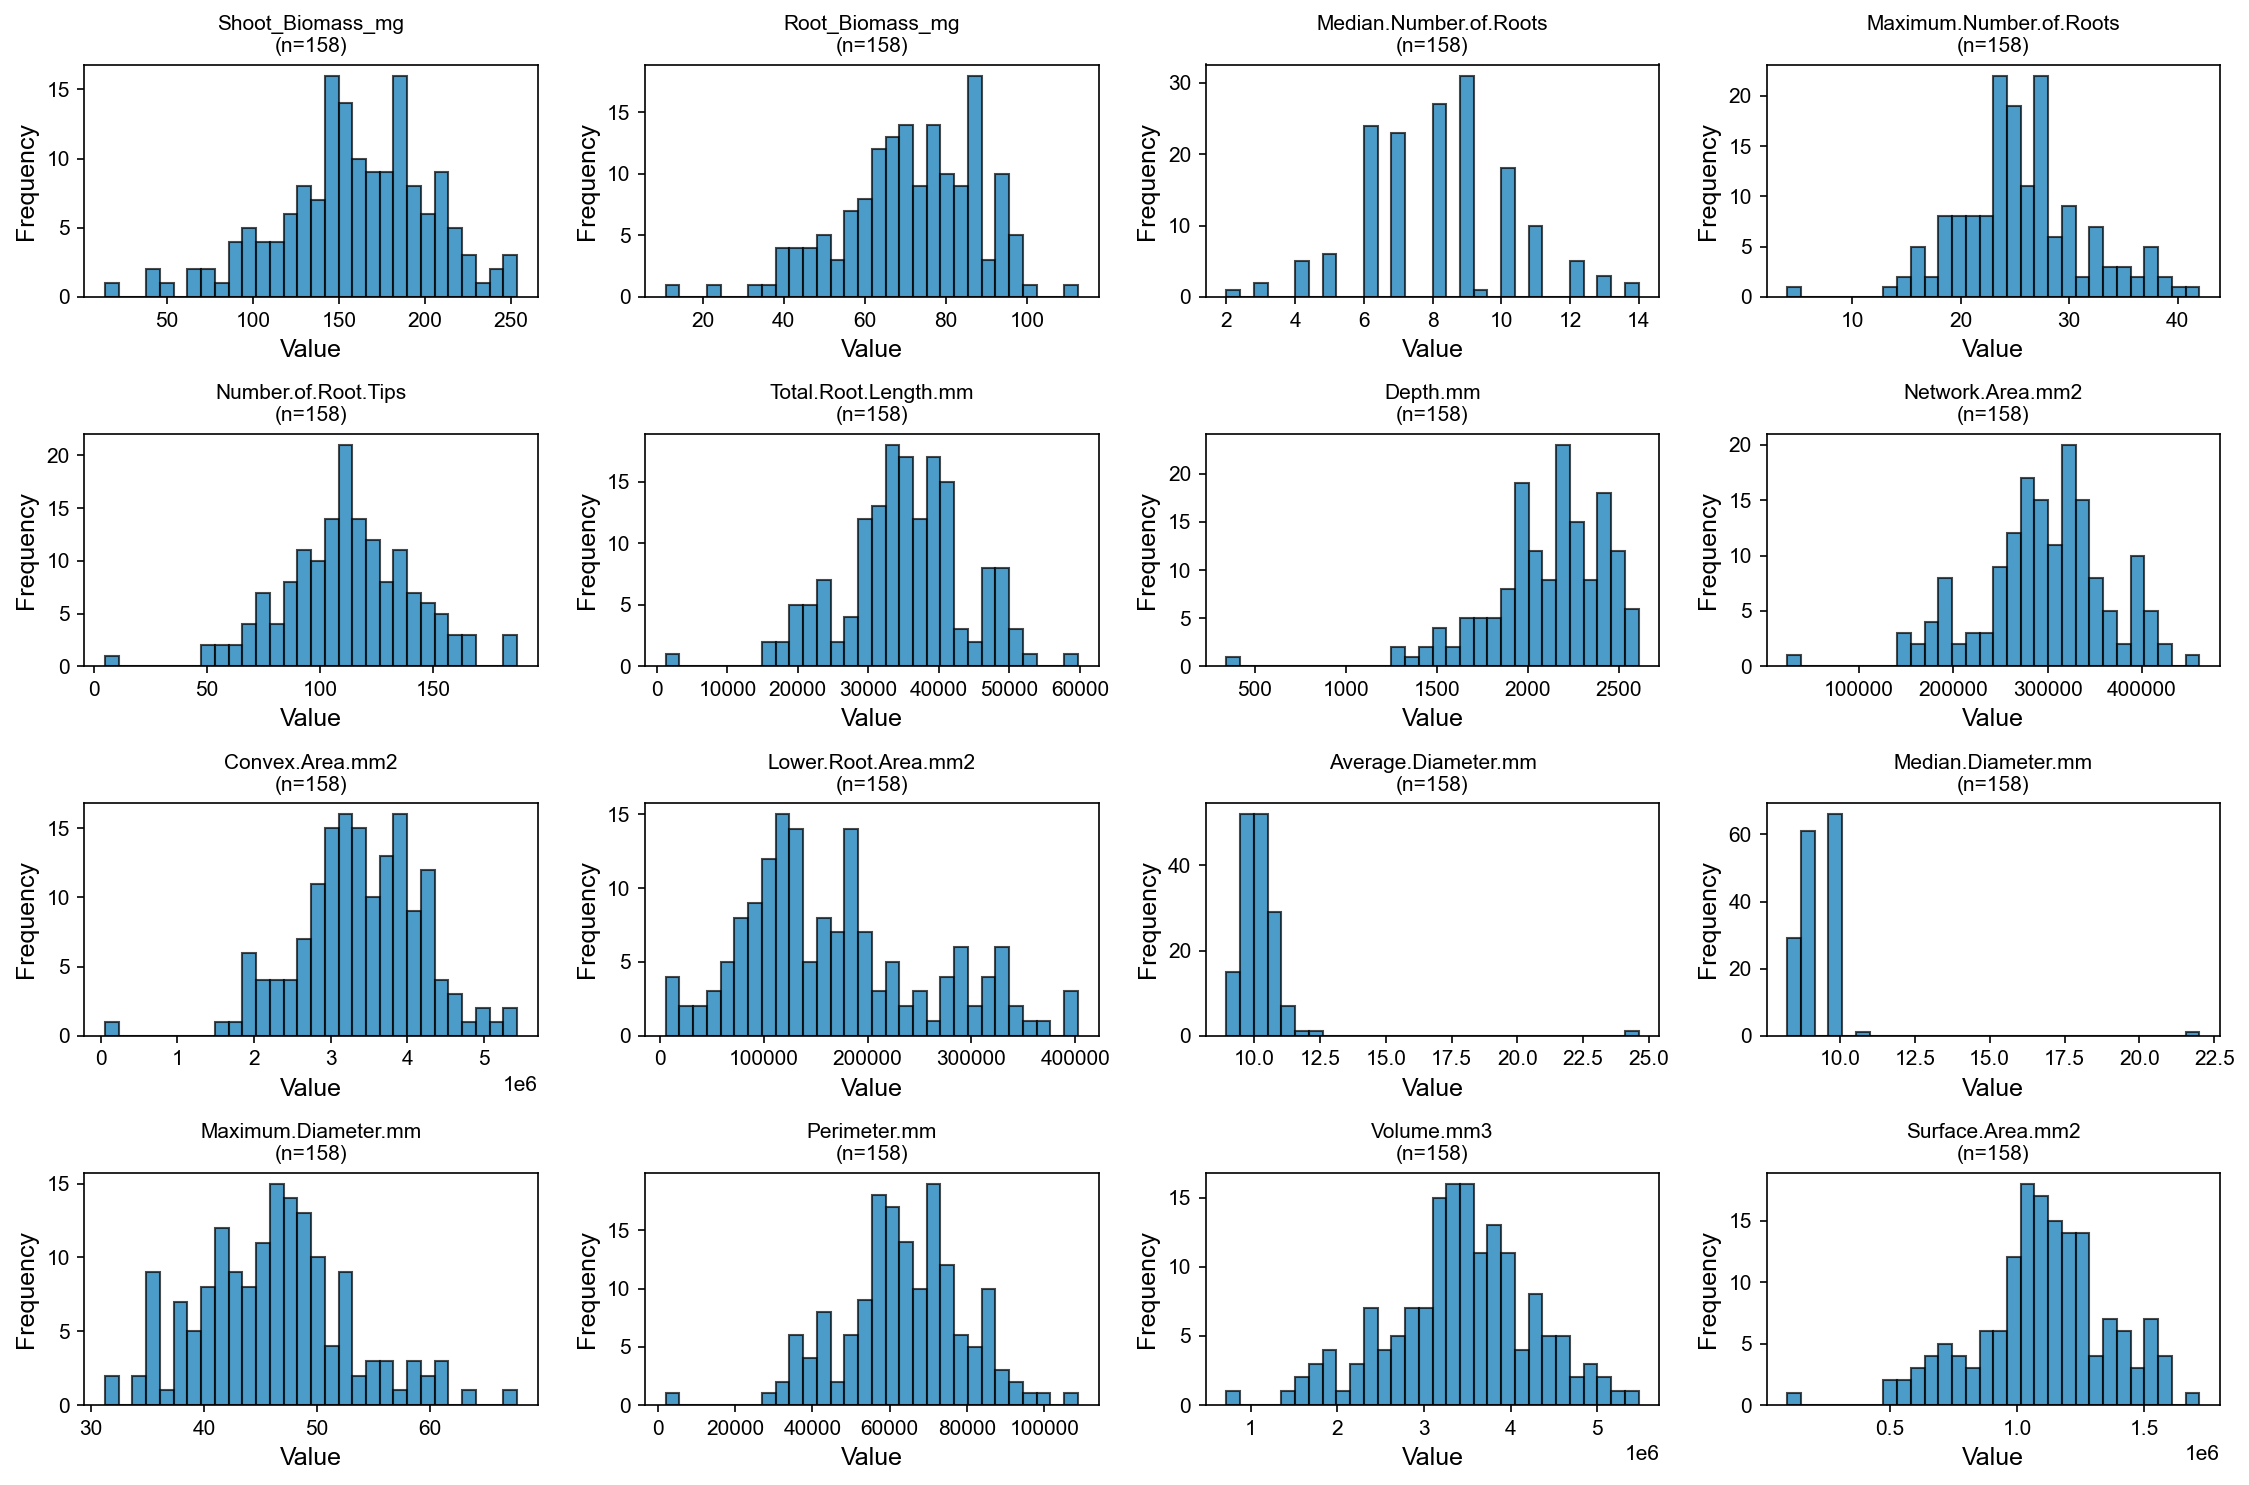

💾 Saved to: eda_trait_distributions_101854.png

📊 Missing Data Pattern


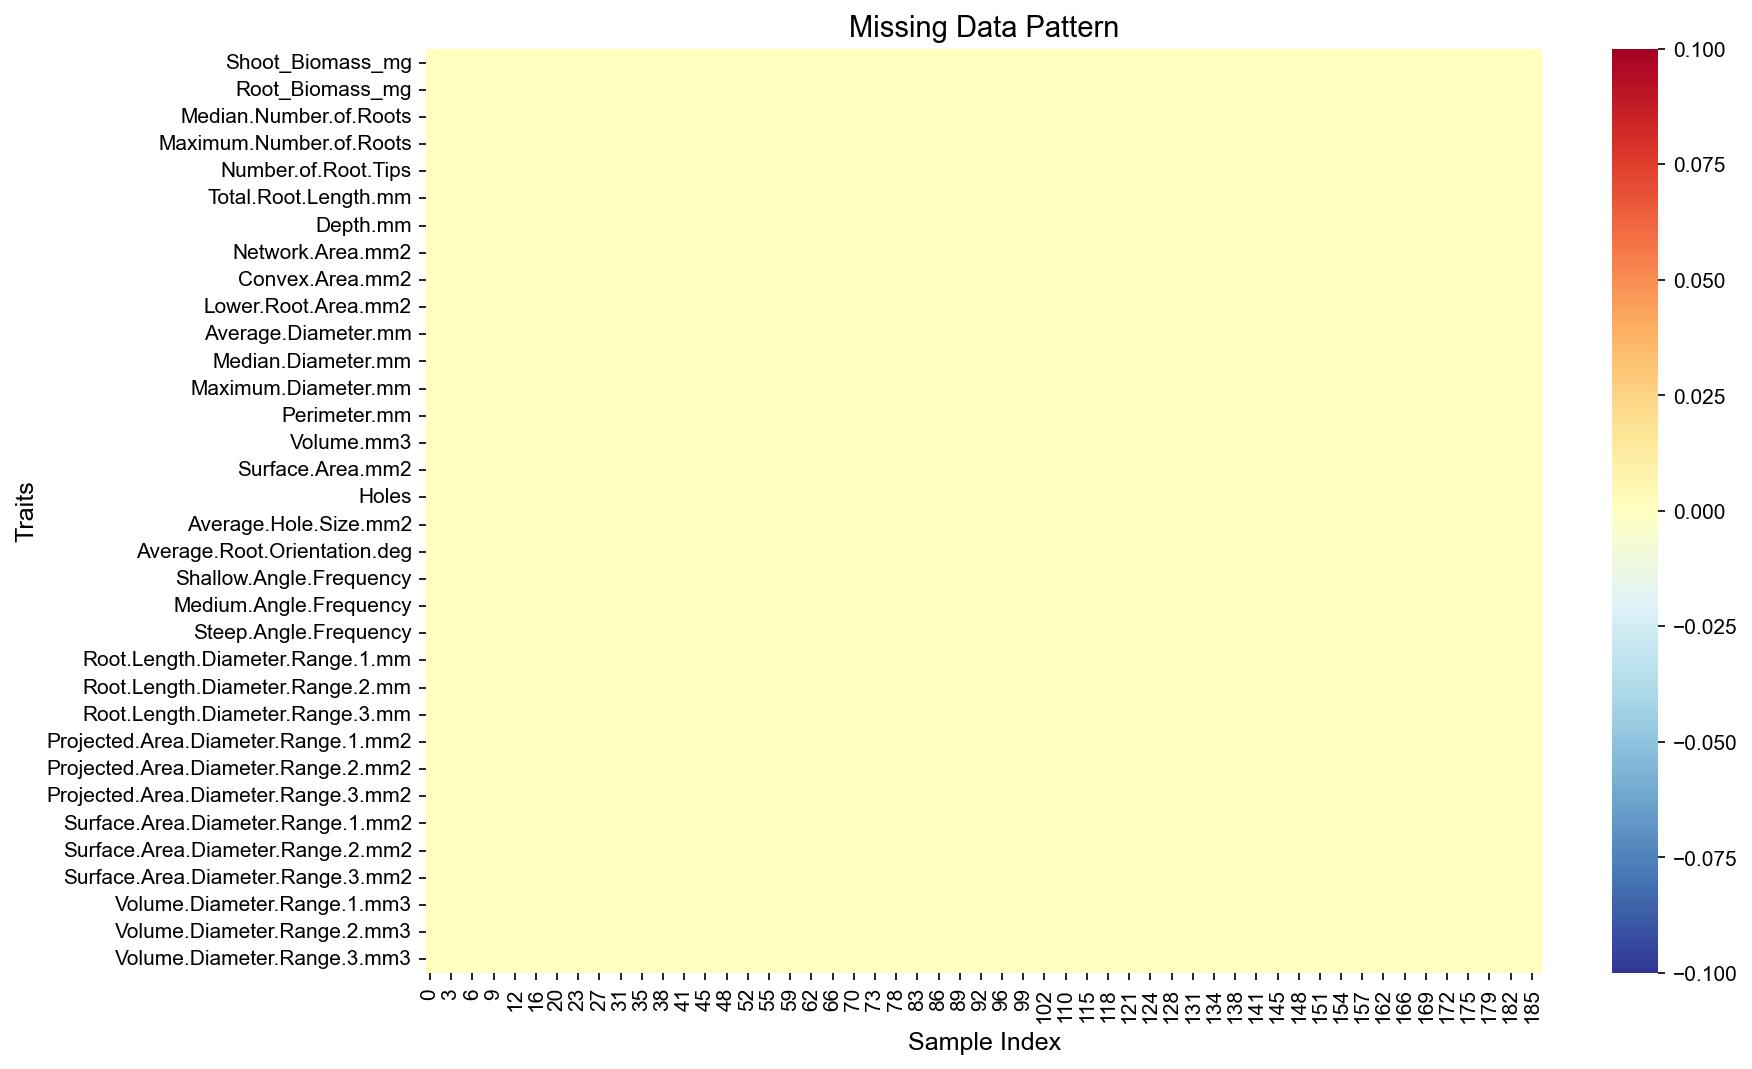

💾 Saved to: eda_missing_data_pattern_101856.png

📊 Trait Ranges By Genotype


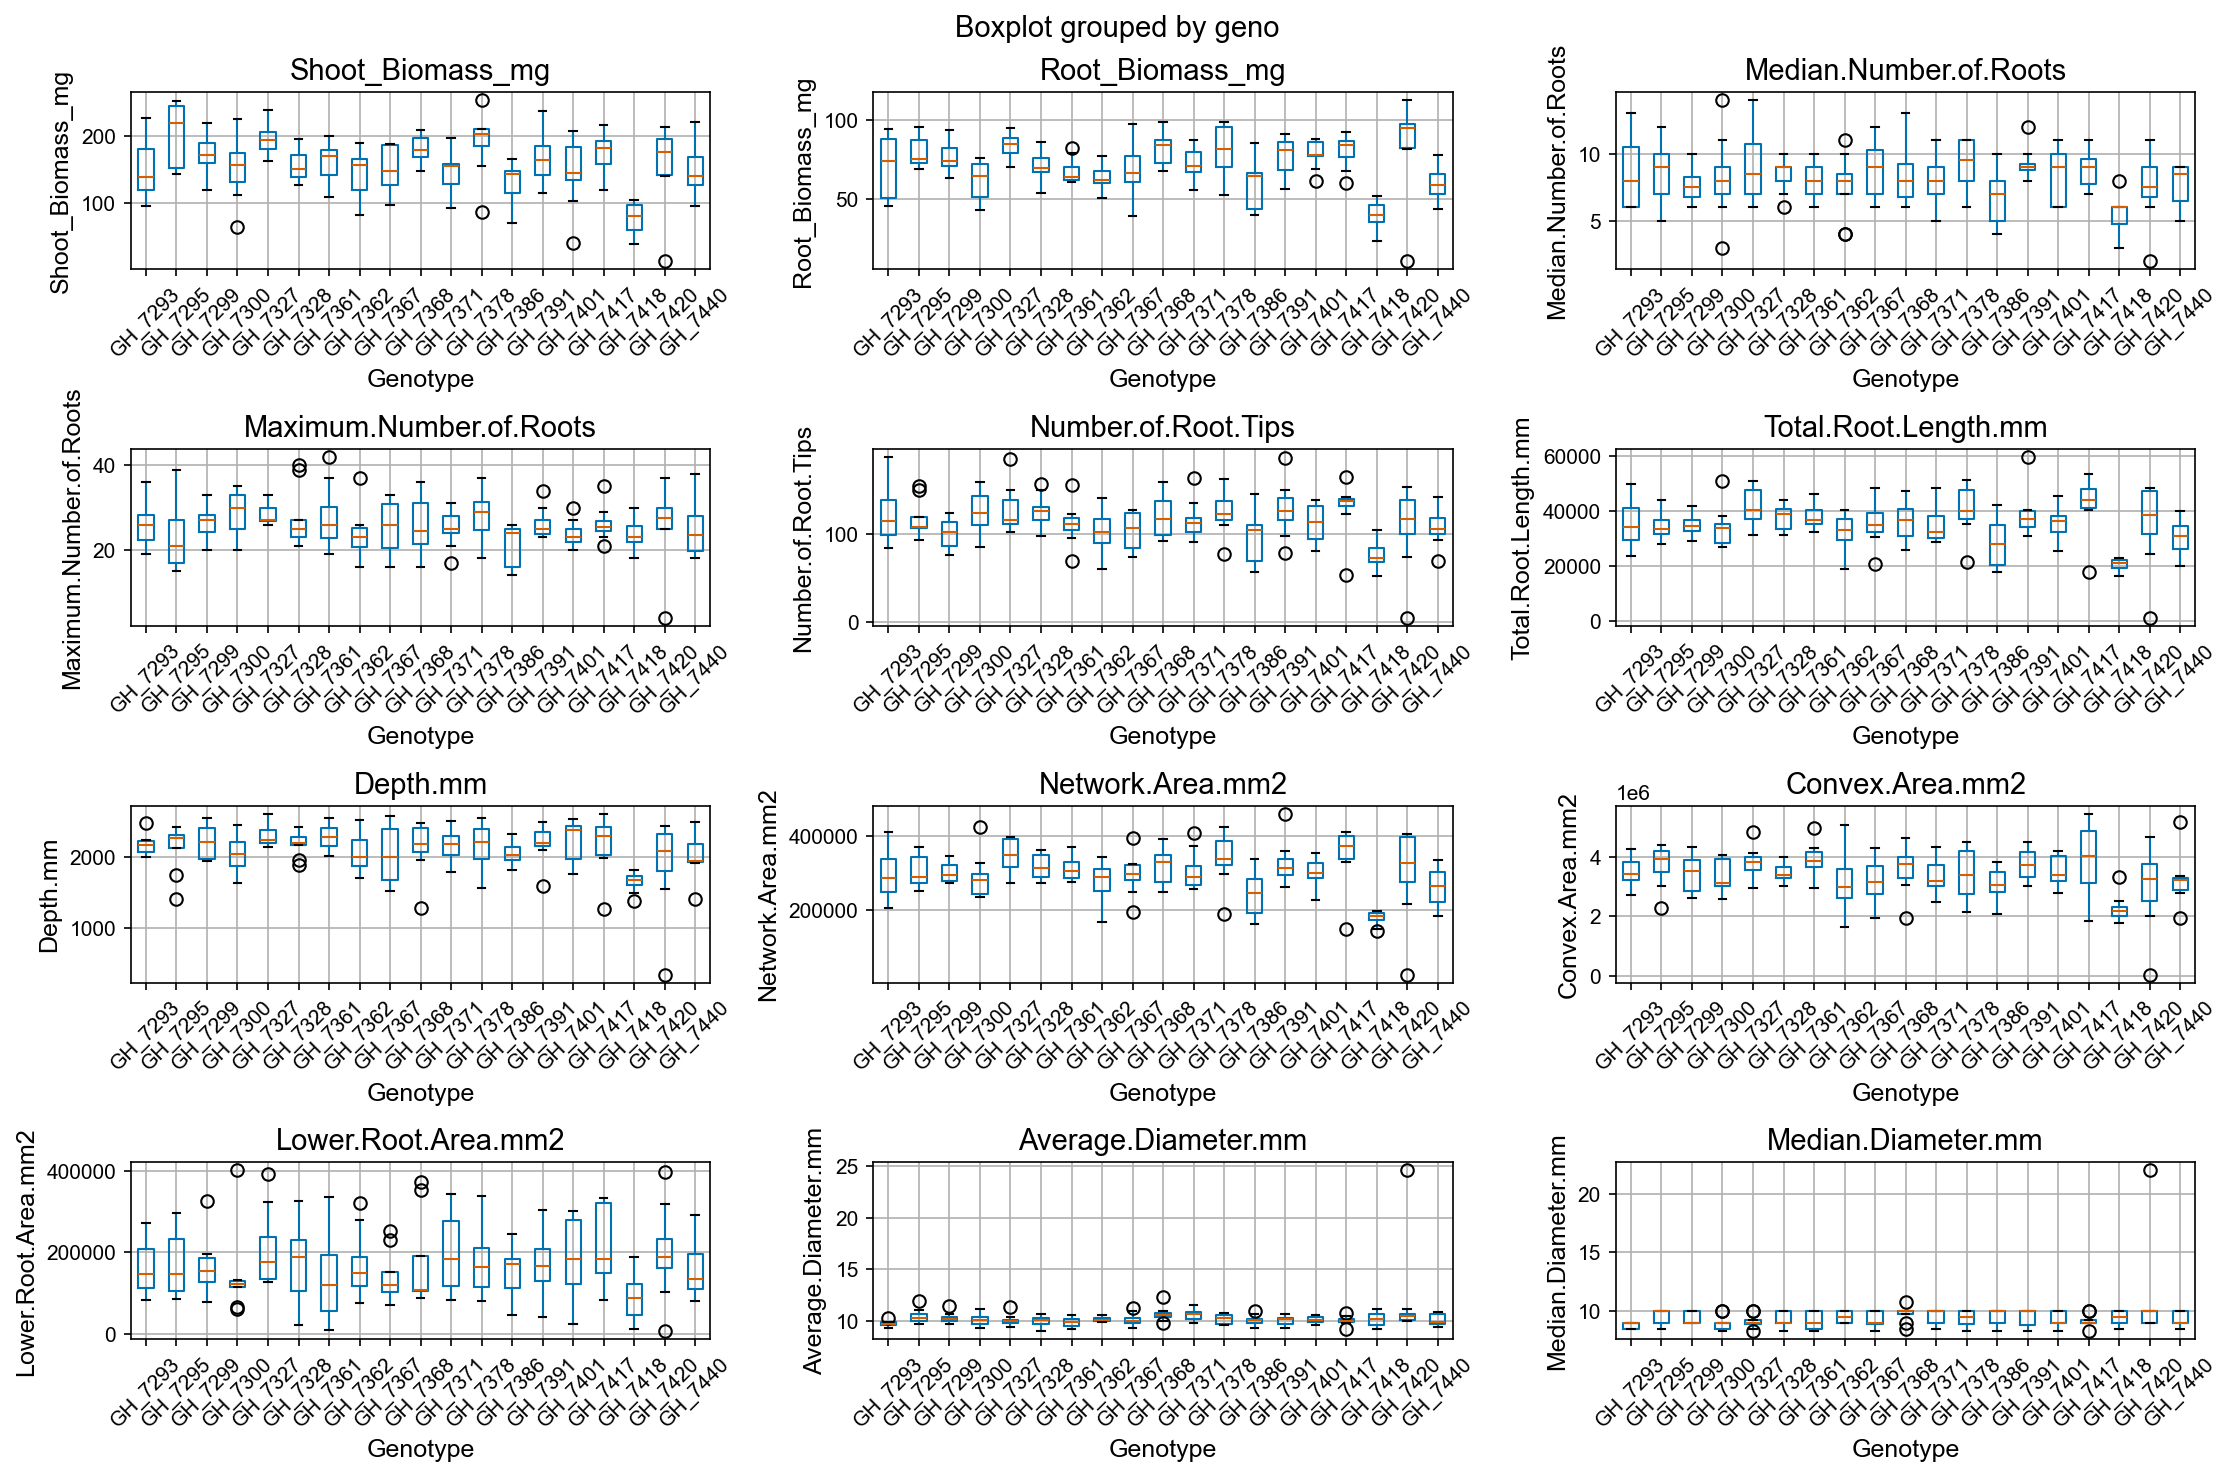

💾 Saved to: eda_trait_ranges_by_genotype_101857.png

📊 Samples Per Genotype


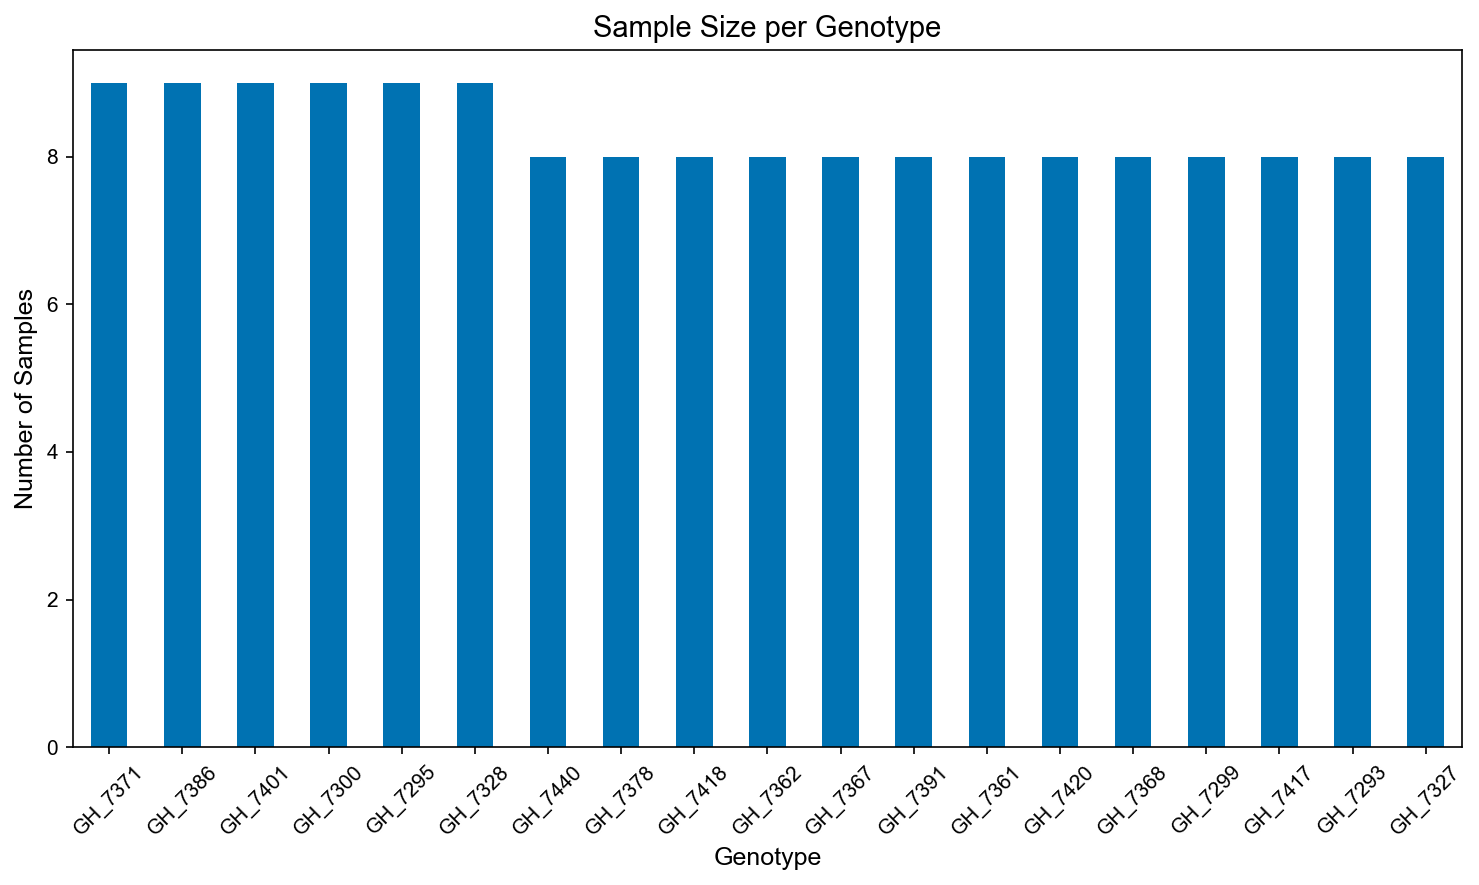

💾 Saved to: eda_samples_per_genotype_101859.png

📊 Trait Correlations


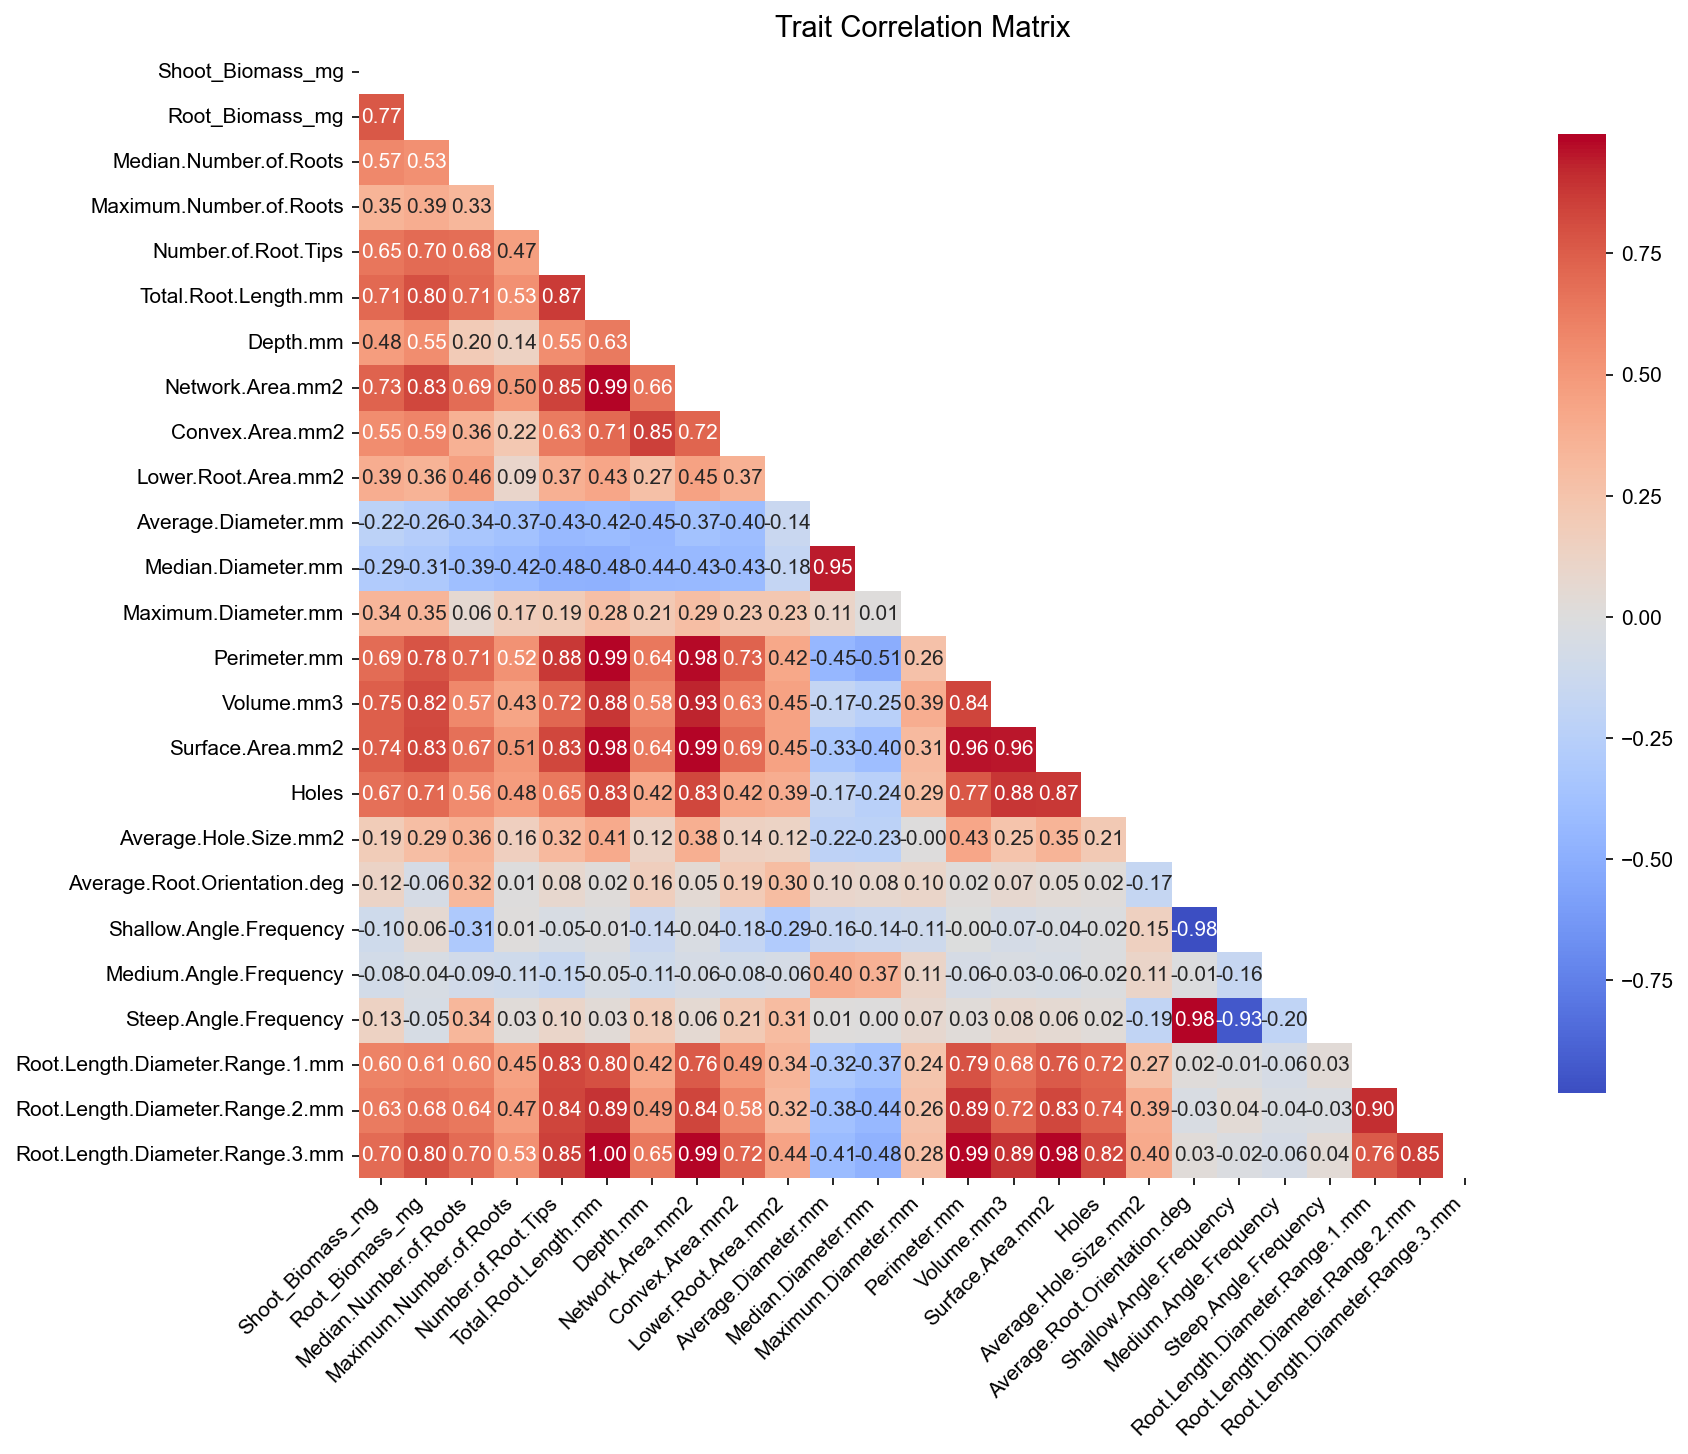

💾 Saved to: eda_trait_correlations_101859.png

✅ Generated and saved 5 EDA plots


In [10]:
# Create comprehensive EDA plots
eda_figures = create_exploratory_summary_plots(df_traits, trait_cols, "geno")

# Display and save each figure
for fig_name, fig in eda_figures.items():
    if fig is not None:
        print(f"\n📊 {fig_name.replace('_', ' ').title()}")
        display(fig)
        # Save figure
        fig_path = save_figure_with_unique_name(fig, FIGURES_DIR, f"eda_{fig_name}")
        print(f"💾 Saved to: {fig_path.name}")
        plt.close(fig)

print(f"\n✅ Generated and saved {len(eda_figures)} EDA plots")


📊 Creating additional plots for all 34 traits...

📊 Trait Distributions Batch 1/3


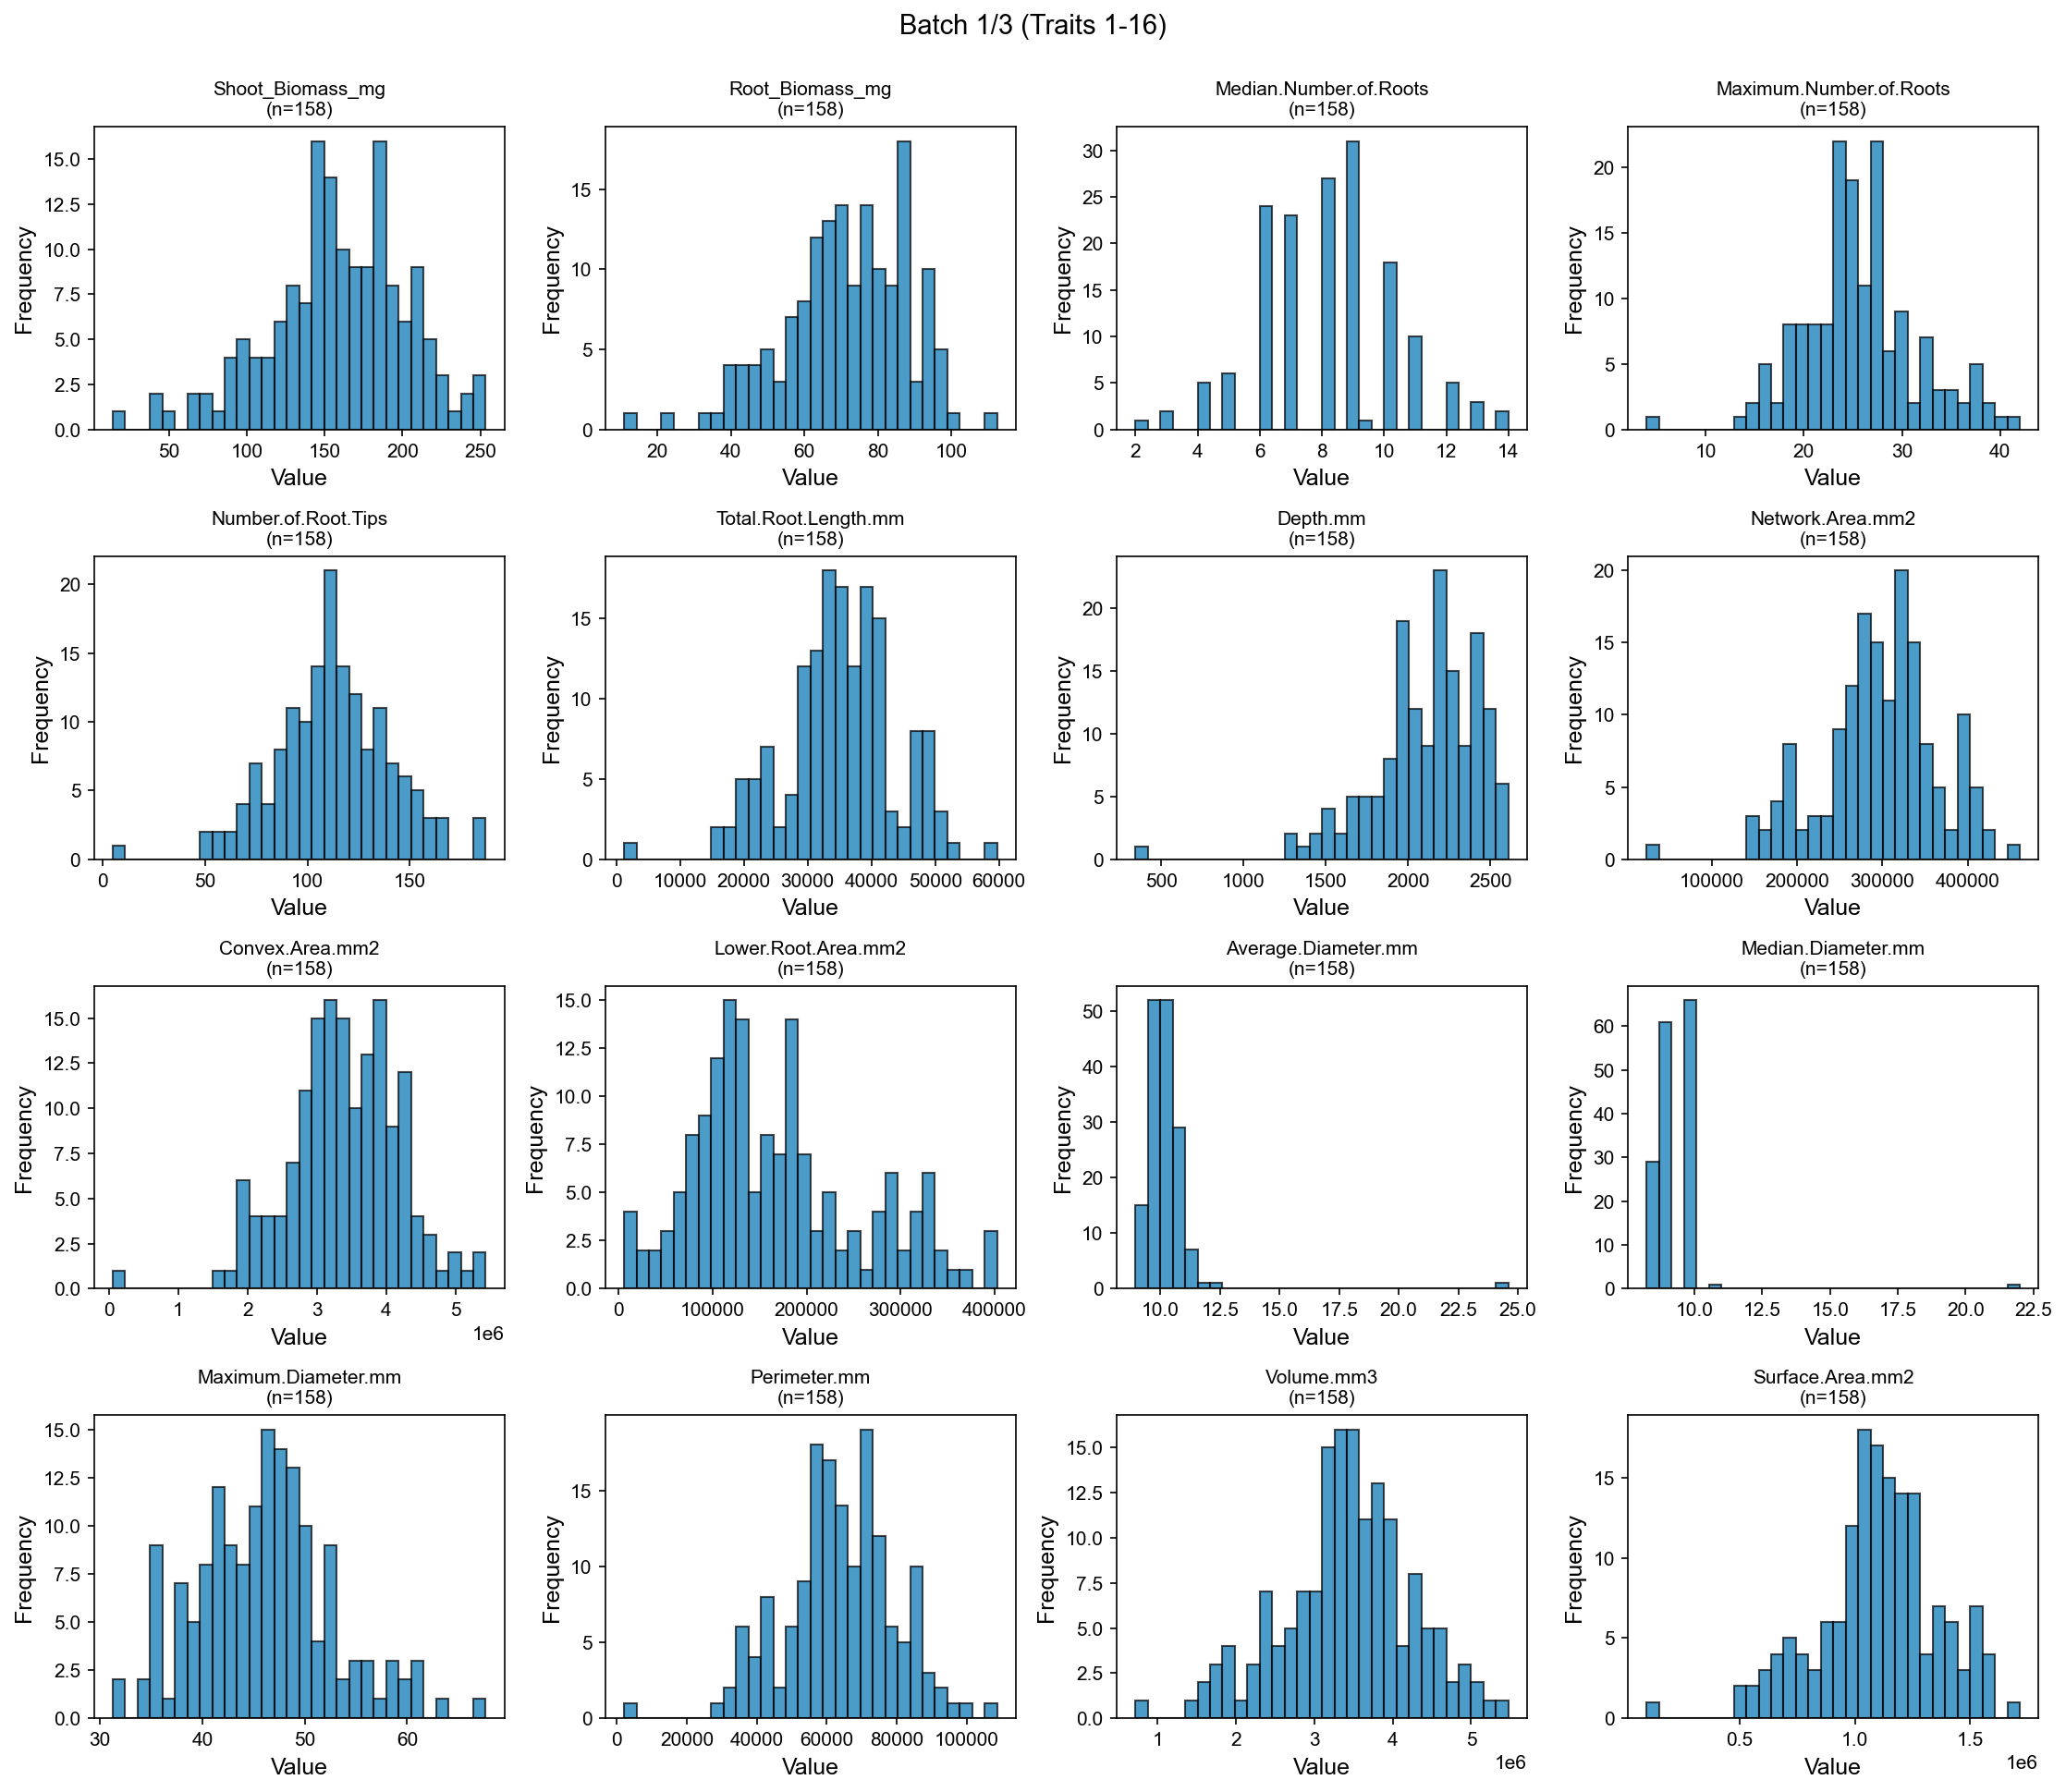

💾 Saved to: trait_distributions_batch_1_101902.png

📊 Trait Distributions Batch 2/3


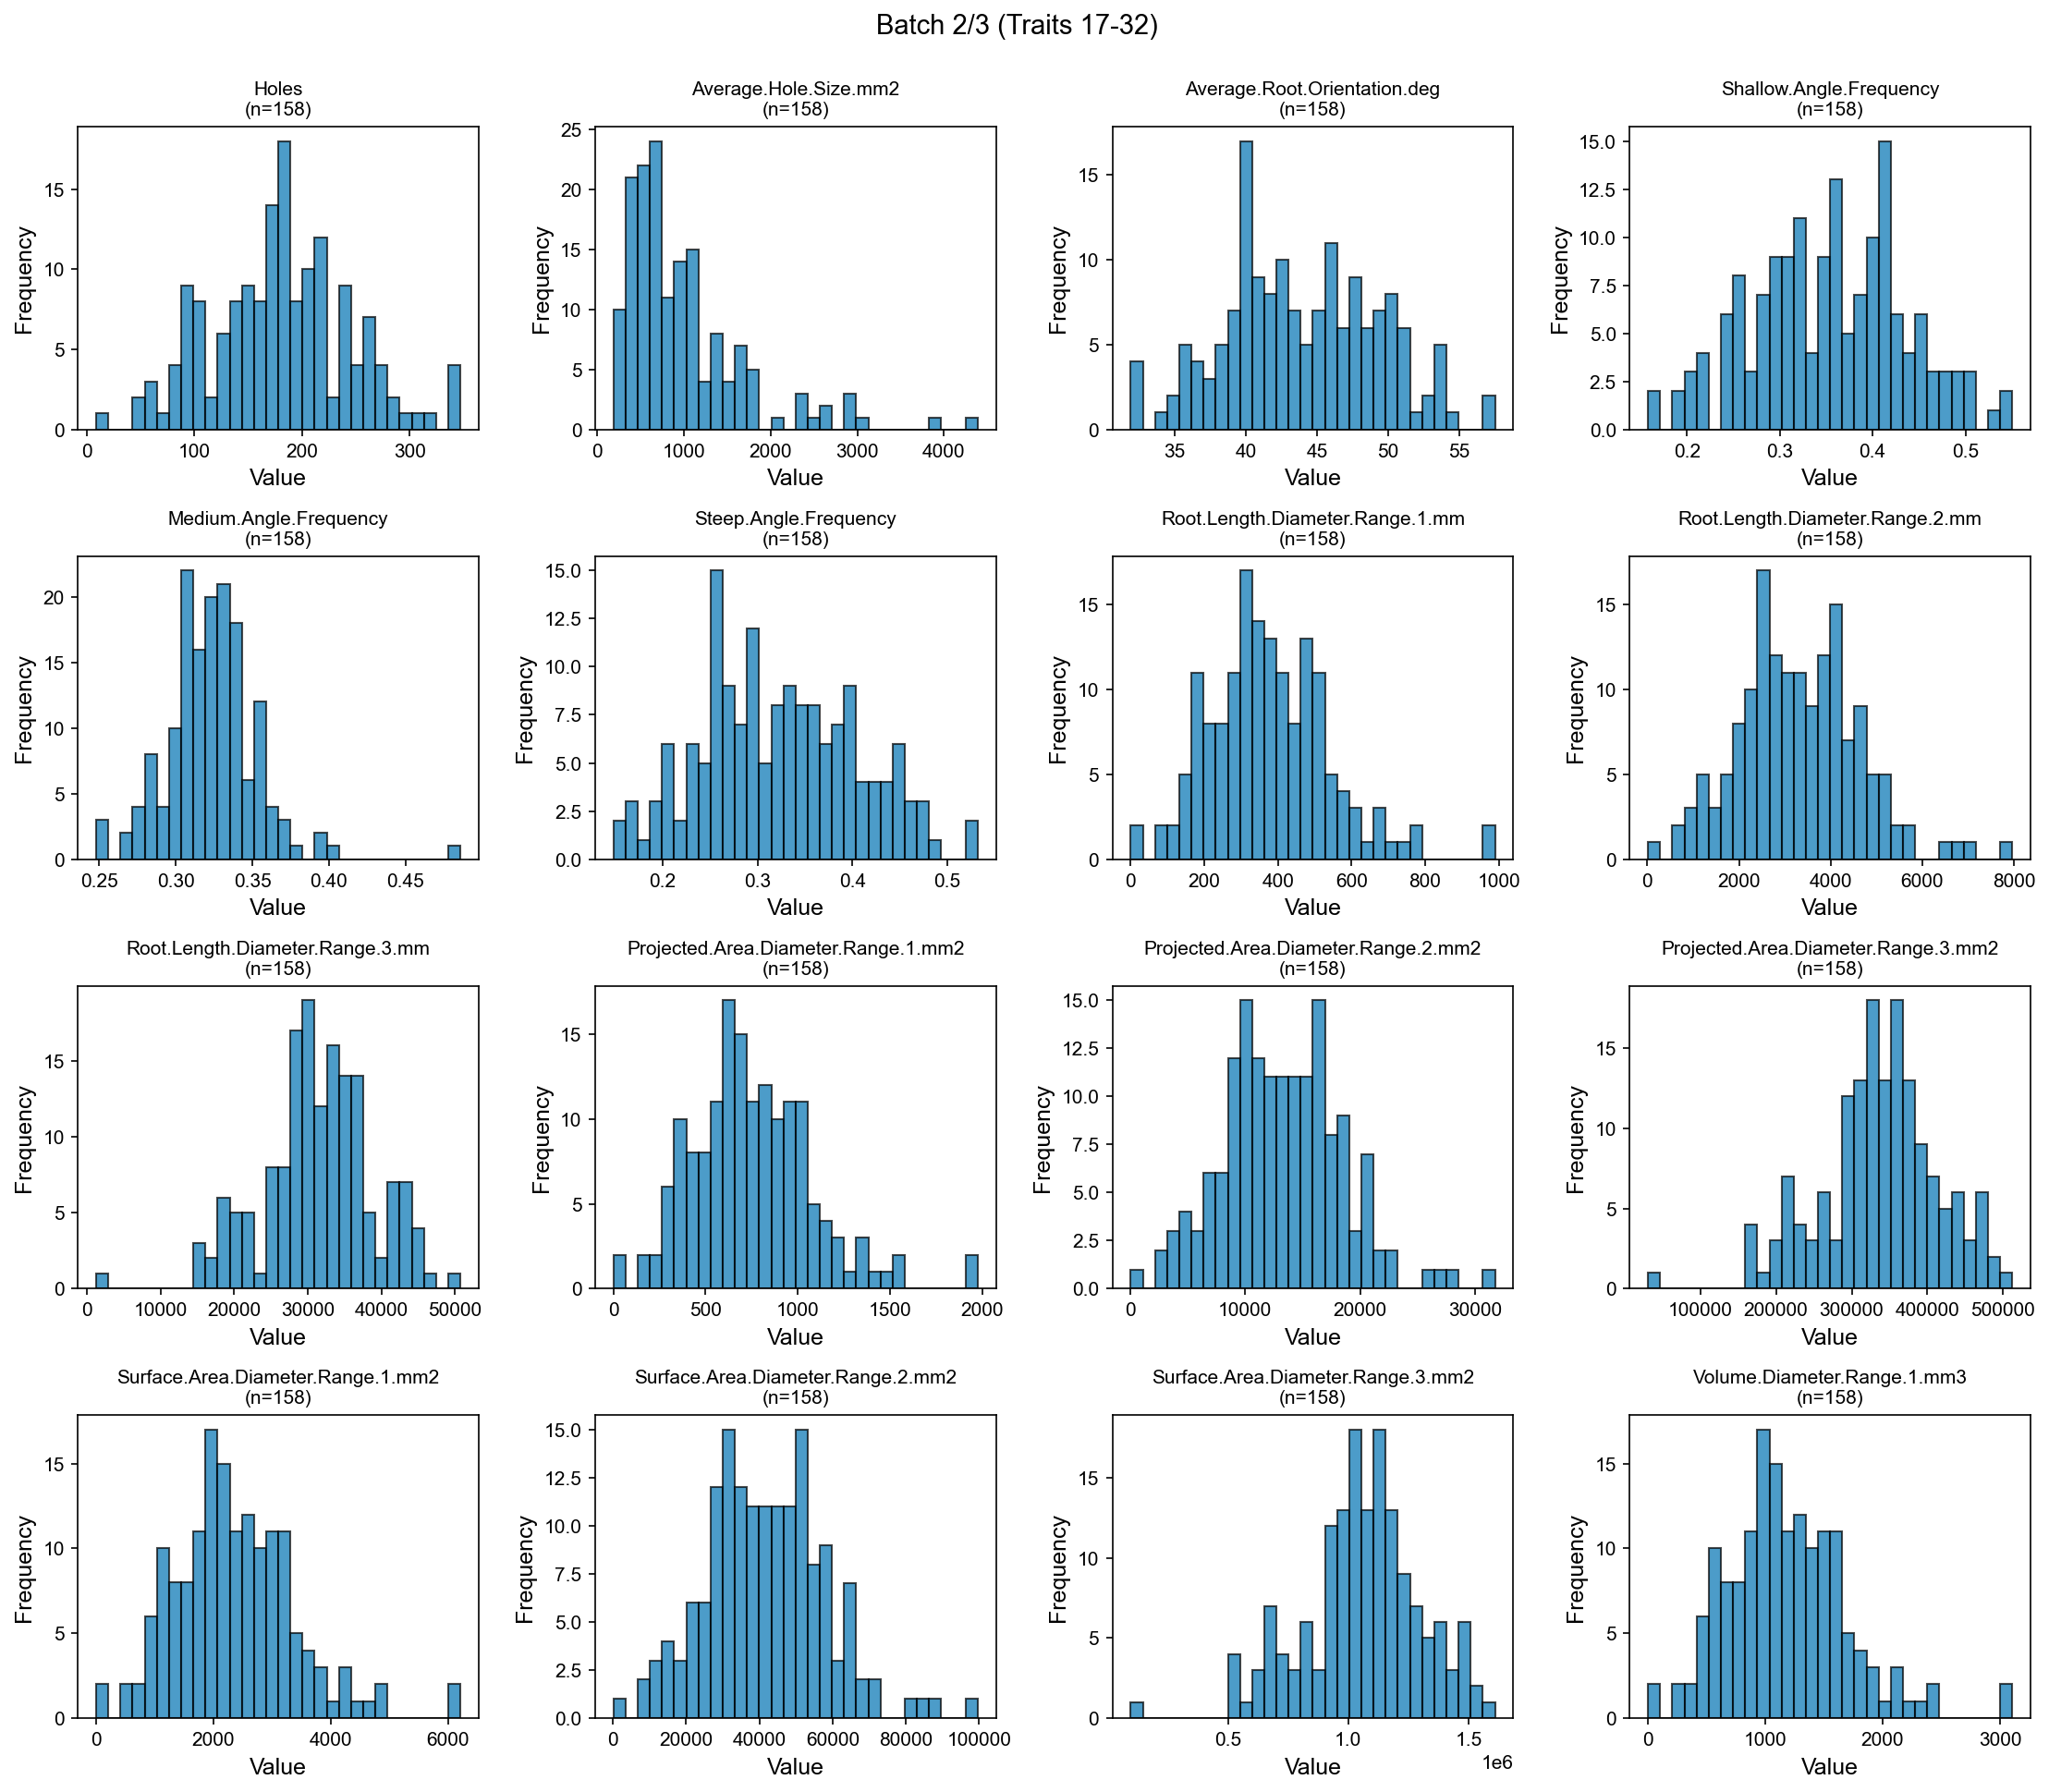

💾 Saved to: trait_distributions_batch_2_101905.png

📊 Trait Distributions Batch 3/3


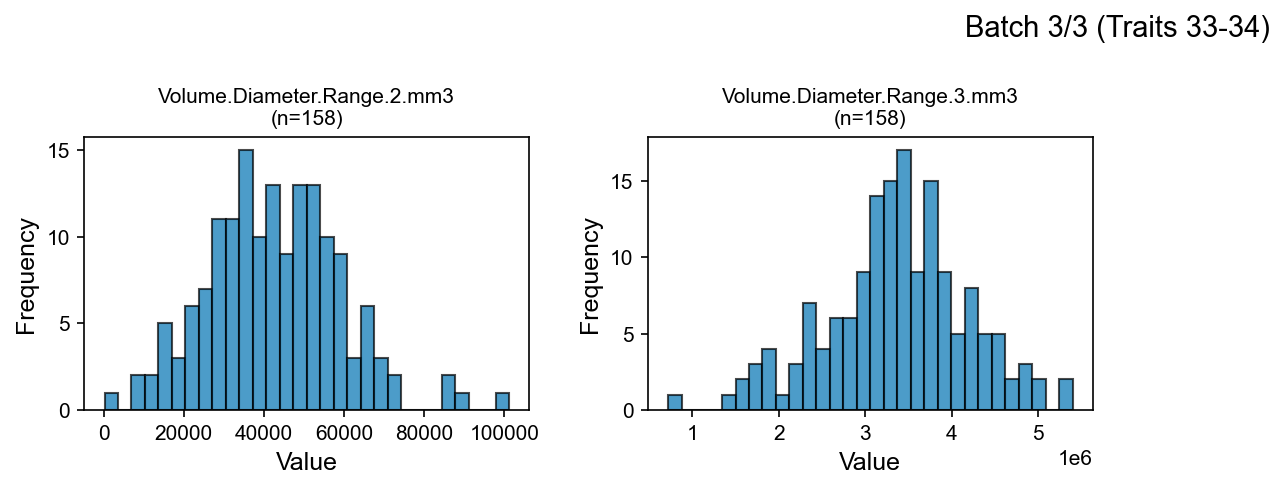

💾 Saved to: trait_distributions_batch_3_101906.png

📊 Trait Boxplots Batch 1/3


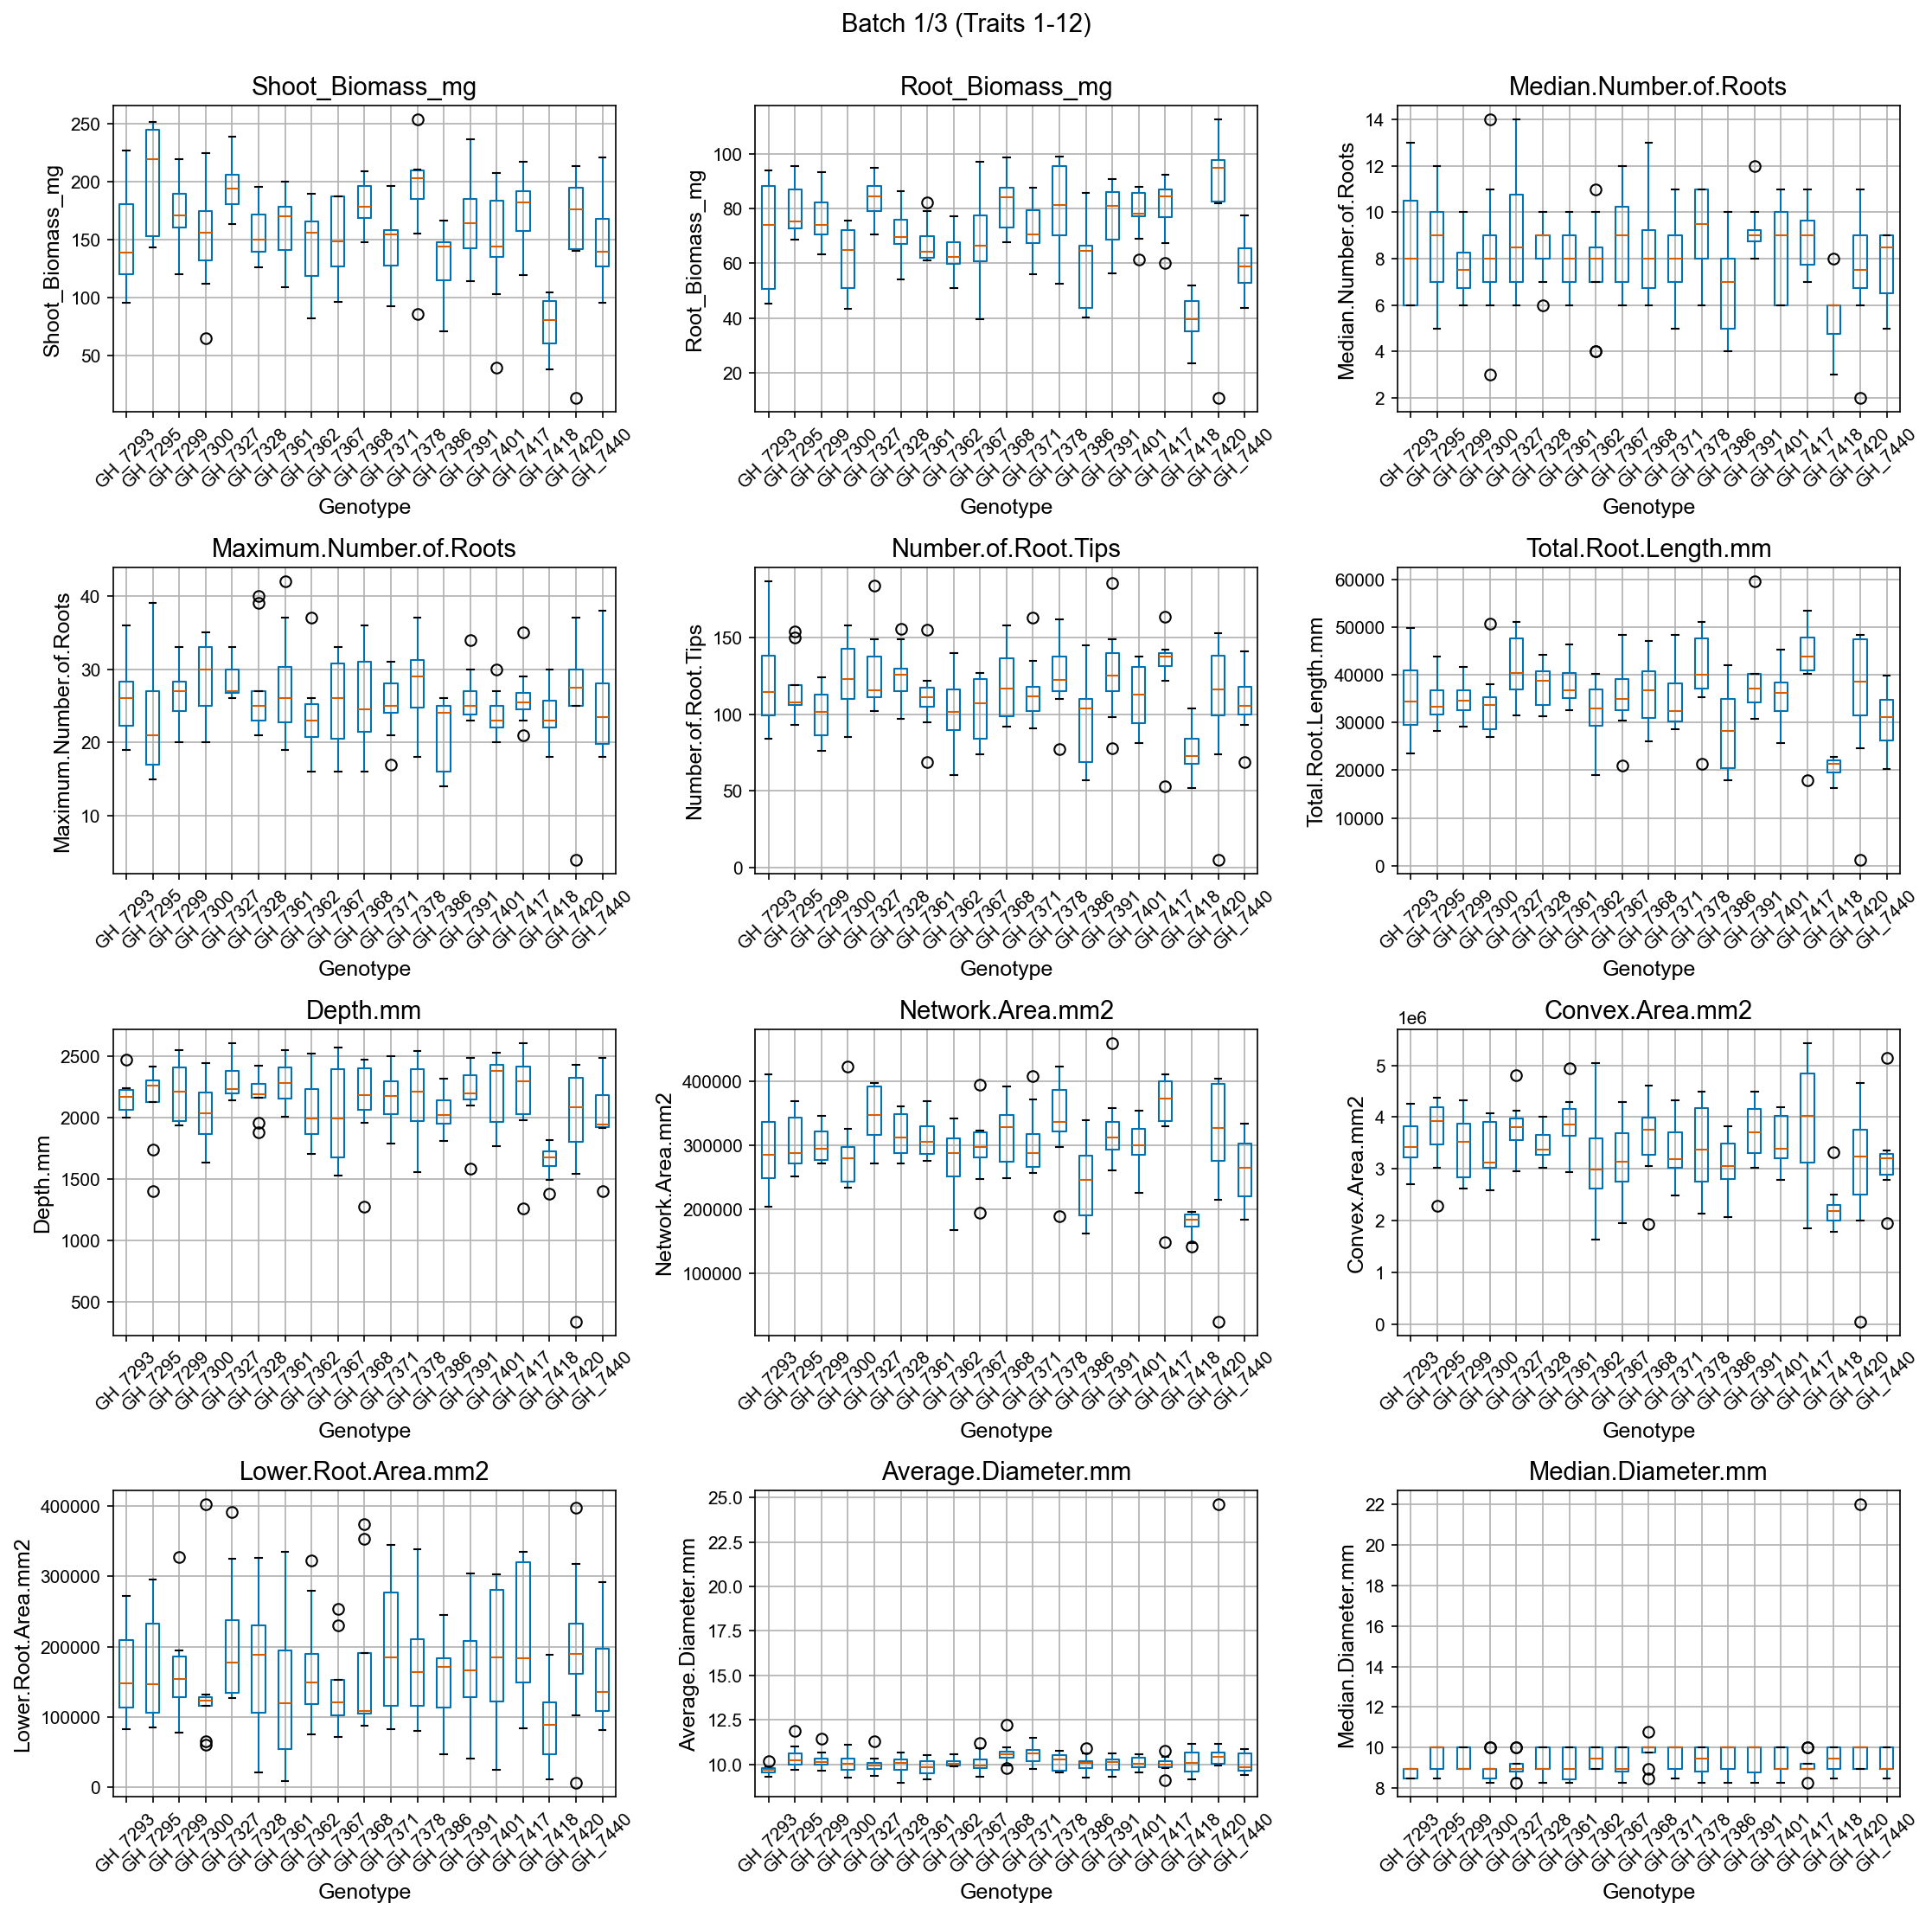

💾 Saved to: trait_boxplots_batch_1_101909.png

📊 Trait Boxplots Batch 2/3


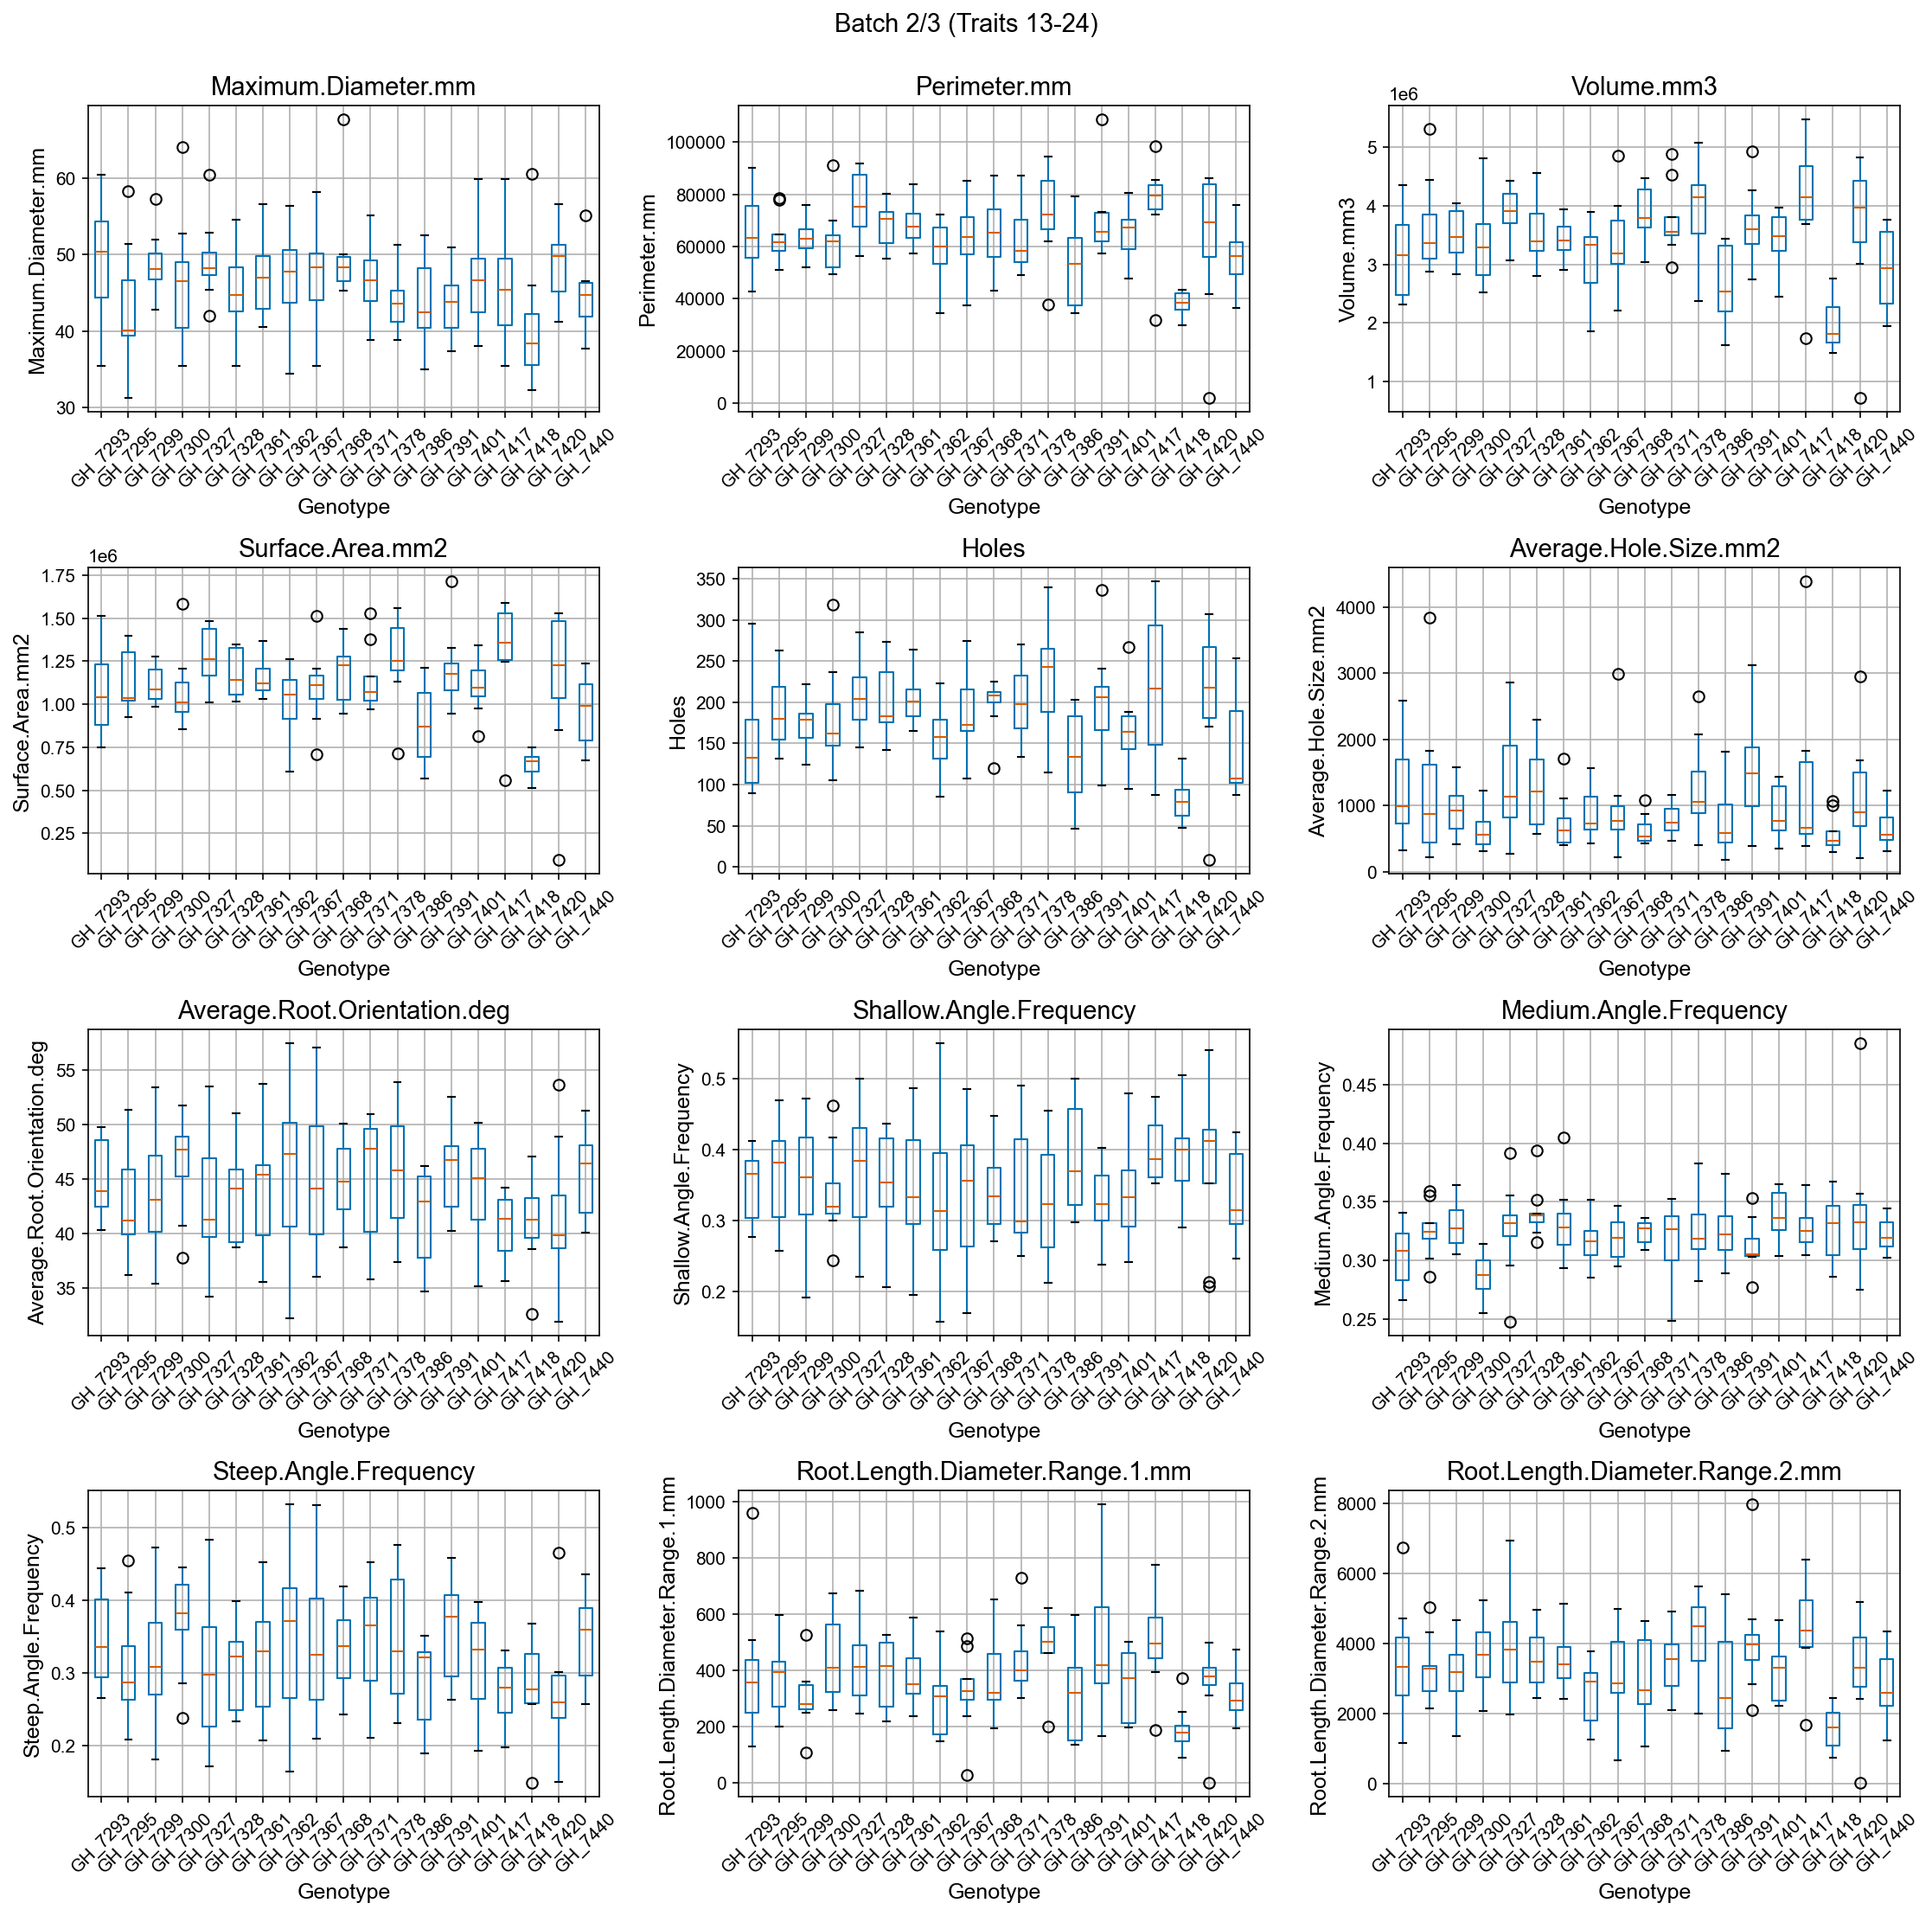

💾 Saved to: trait_boxplots_batch_2_101914.png

📊 Trait Boxplots Batch 3/3


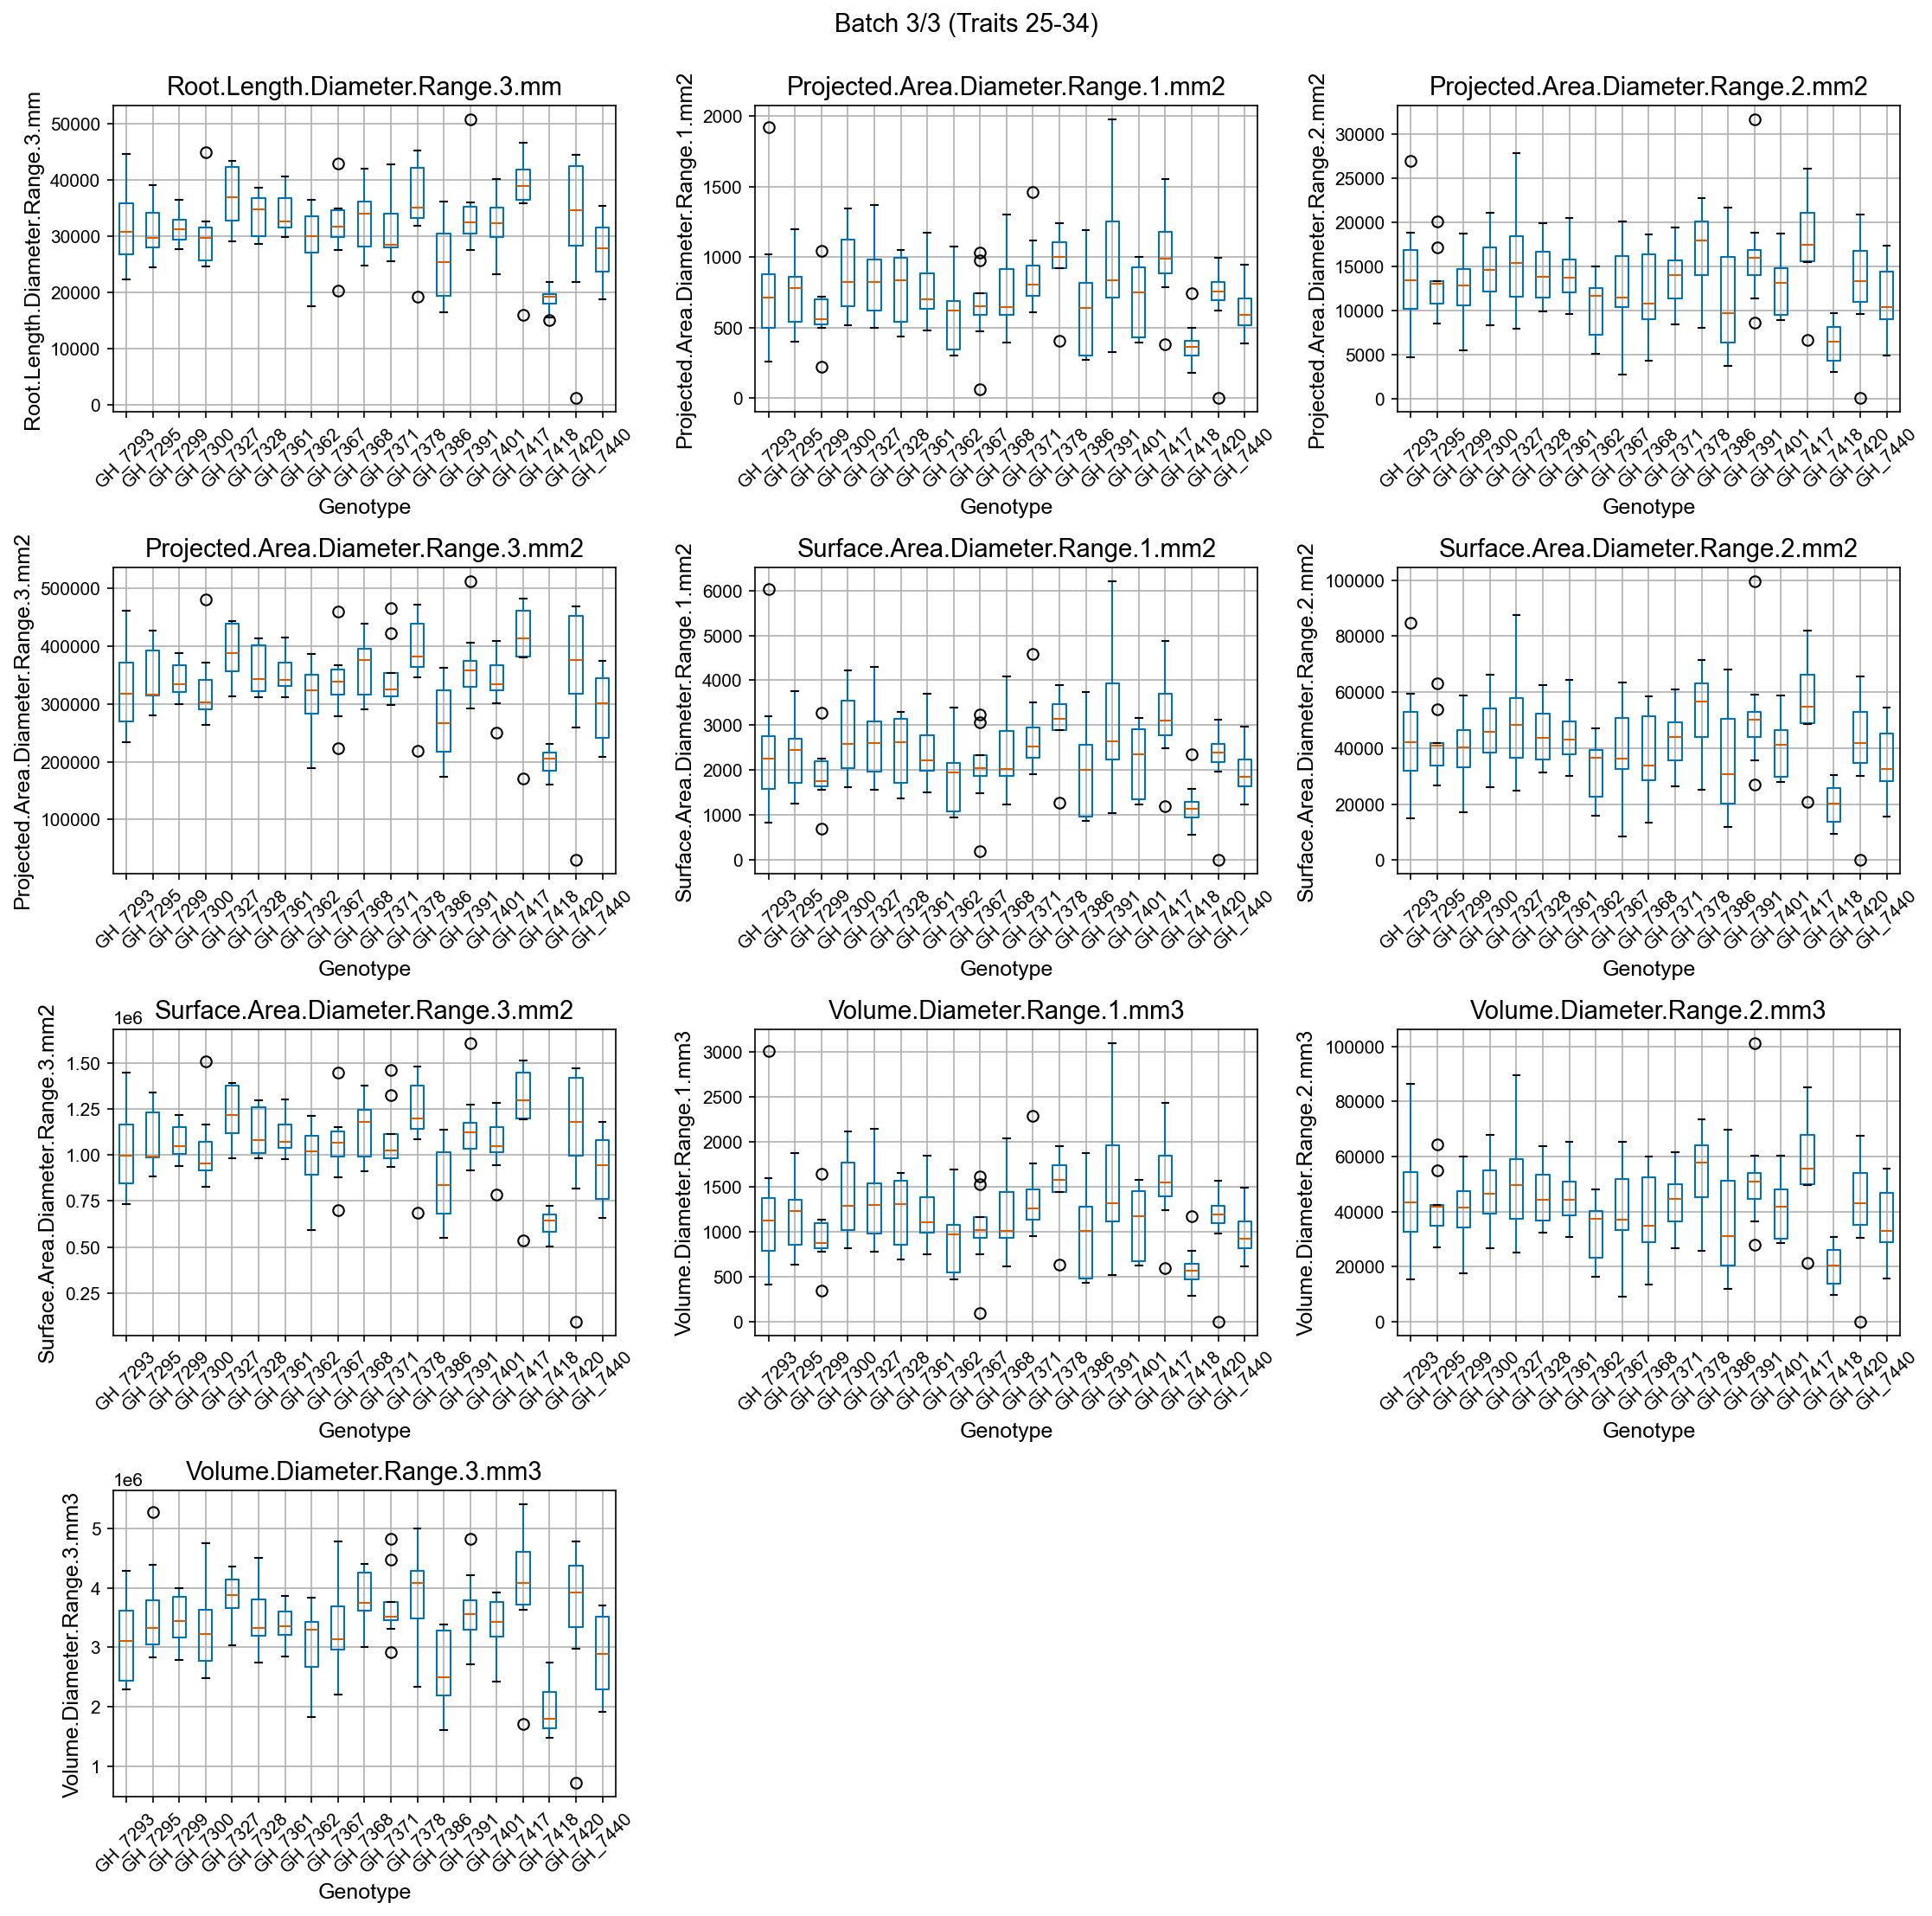

💾 Saved to: trait_boxplots_batch_3_101917.png

✅ Created additional plots to show all 34 traits


In [11]:
# Create additional plots to show ALL traits (not just first 16)
if len(trait_cols) > 16:
    print(f"\n📊 Creating additional plots for all {len(trait_cols)} traits...")
    
    # Create histograms for all traits in batches
    n_traits = len(trait_cols)
    batch_size = 16
    n_batches = (n_traits + batch_size - 1) // batch_size
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_traits)
        batch_traits = trait_cols[start_idx:end_idx]
        n_traits_in_batch = len(batch_traits)
        
        # Adjust figure size for last batch if it has fewer traits
        n_cols = 4
        n_rows = (n_traits_in_batch + n_cols - 1) // n_cols
        figsize = (15, n_rows * 3.5)  # 3.5 inches per row
        
        # Create histogram figure for this batch
        fig = create_trait_histograms(df_traits, batch_traits, n_cols=n_cols, figsize=figsize)
        fig.suptitle(f"Batch {i+1}/{n_batches} (Traits {start_idx+1}-{end_idx})", fontsize=14, y=0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for title
        
        print(f"\n📊 Trait Distributions Batch {i+1}/{n_batches}")
        display(fig)
        
        # Save figure
        fig_path = save_figure_with_unique_name(fig, FIGURES_DIR, f"trait_distributions_batch_{i+1}")
        print(f"💾 Saved to: {fig_path.name}")
        plt.close(fig)
    
    # Similarly for boxplots if needed
    if len(trait_cols) > 12:
        batch_size = 12
        n_batches = (n_traits + batch_size - 1) // batch_size
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_traits)
            batch_traits = trait_cols[start_idx:end_idx]
            n_traits_in_batch = len(batch_traits)
            
            # Adjust figure size for last batch if it has fewer traits
            n_cols = 3
            n_rows = (n_traits_in_batch + n_cols - 1) // n_cols
            figsize = (15, n_rows * 4)  # 4 inches per row for boxplots
            
            # Create boxplot figure for this batch
            fig = create_trait_boxplots_by_genotype(df_traits, batch_traits, "geno", n_cols=n_cols, figsize=figsize)
            fig.suptitle(f"Batch {i+1}/{n_batches} (Traits {start_idx+1}-{end_idx})", fontsize=14, y=0.95)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for title
            
            print(f"\n📊 Trait Boxplots Batch {i+1}/{n_batches}")
            display(fig)
            
            # Save figure
            fig_path = save_figure_with_unique_name(fig, FIGURES_DIR, f"trait_boxplots_batch_{i+1}")
            print(f"💾 Saved to: {fig_path.name}")
            plt.close(fig)
    
    print(f"\n✅ Created additional plots to show all {len(trait_cols)} traits")


📊 Trait Eda Overview


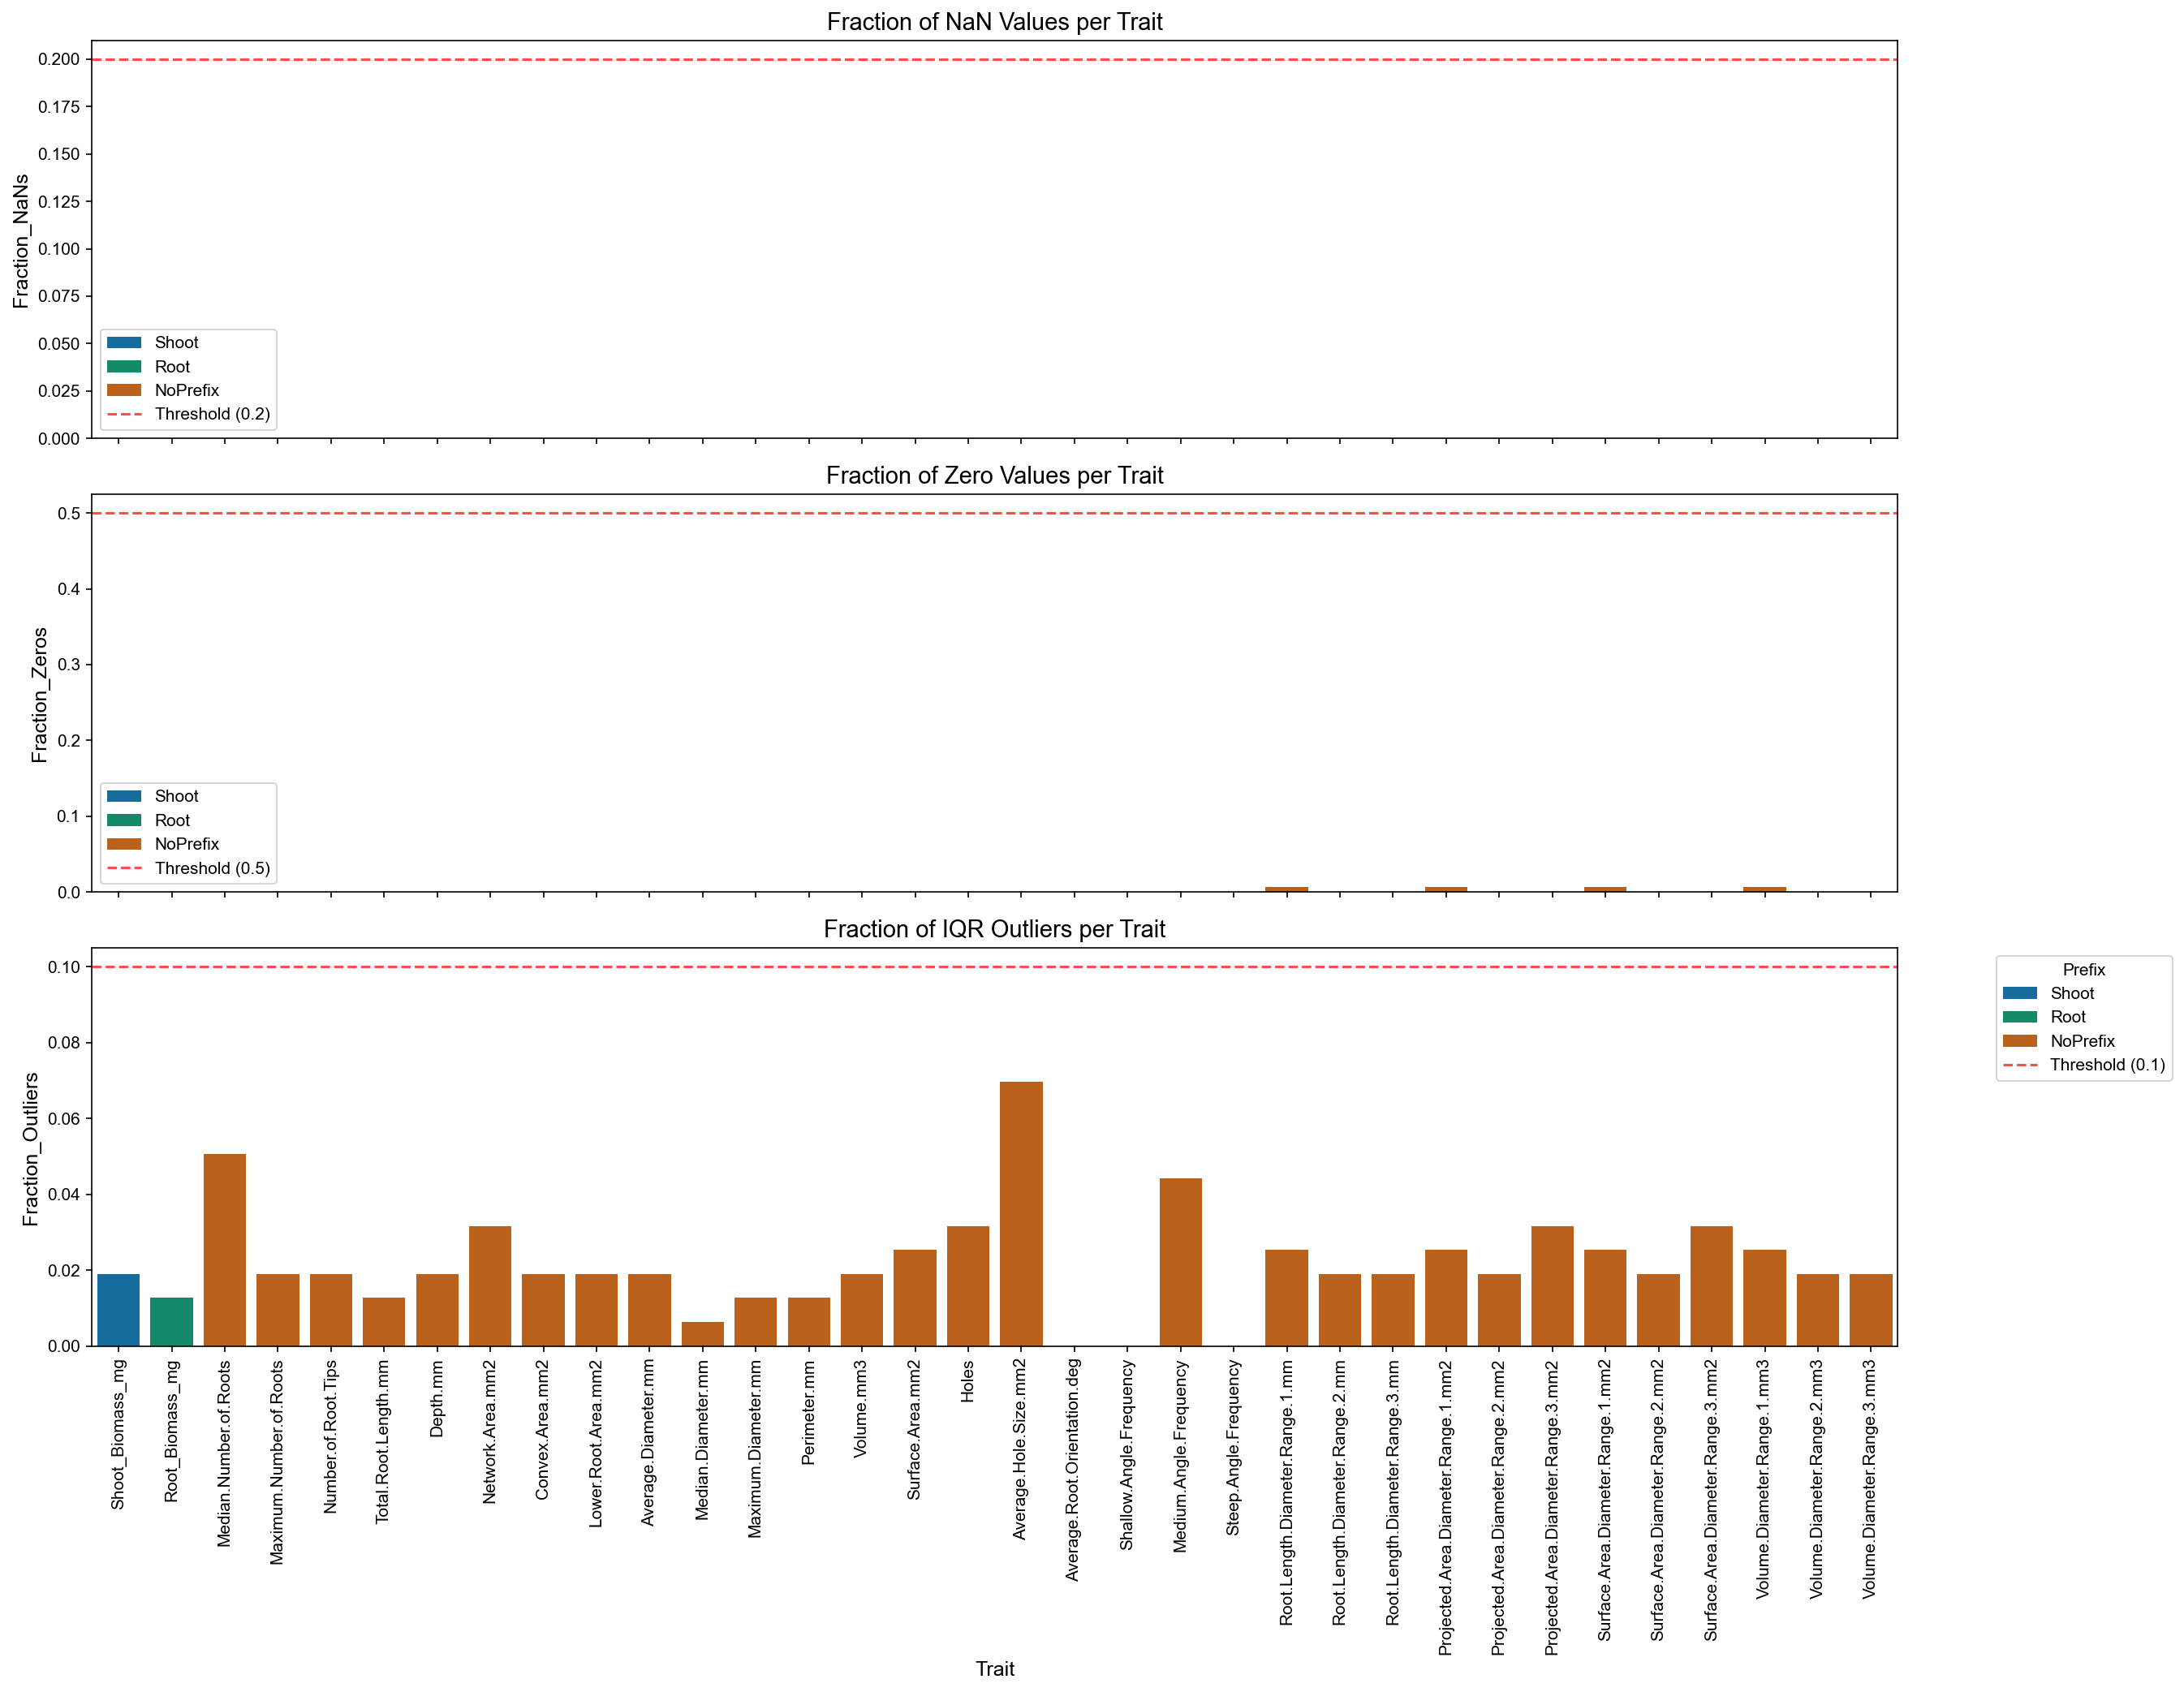

💾 Saved to: trait_trait_eda_overview_101920.png

📊 Variance Distribution


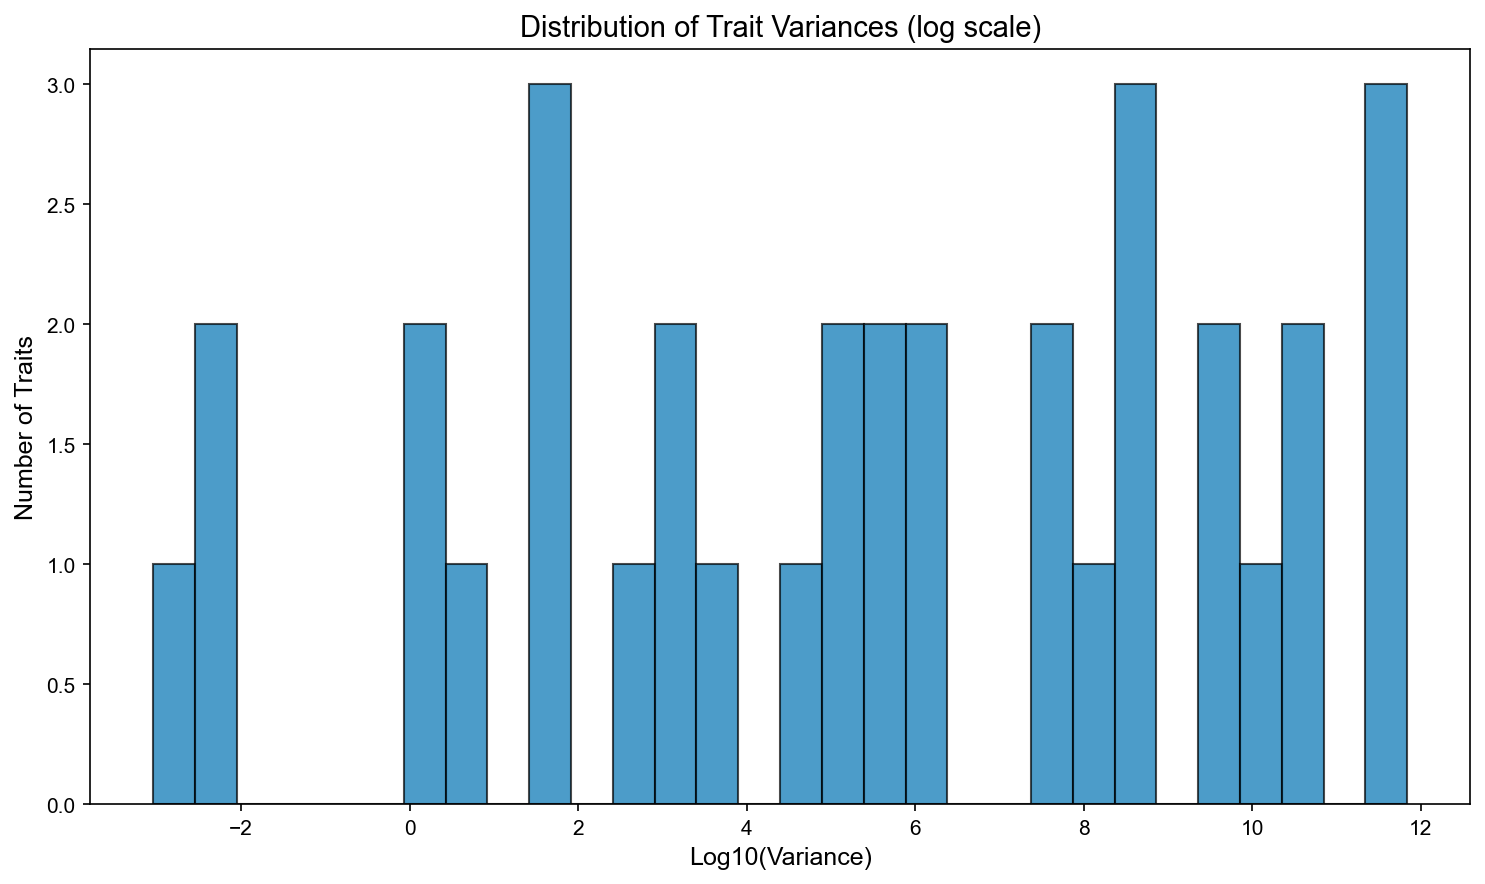

💾 Saved to: trait_variance_distribution_101921.png

✅ Generated and saved 2 trait quality plots


In [12]:
# Create trait quality analysis plots
thresholds = {
    "nan": MAX_NANS_PER_TRAIT,
    "zero": MAX_ZEROS_PER_TRAIT,
    "outlier": 0.1,
}

trait_eda_figures = create_trait_eda_plots(df_traits, trait_cols, thresholds)

# Display and save each figure
for fig_name, fig in trait_eda_figures.items():
    if fig is not None:
        print(f"\n📊 {fig_name.replace('_', ' ').title()}")
        display(fig)
        # Save figure
        fig_path = save_figure_with_unique_name(fig, FIGURES_DIR, f"trait_{fig_name}")
        print(f"💾 Saved to: {fig_path.name}")
        plt.close(fig)

print(f"\n✅ Generated and saved {len(trait_eda_figures)} trait quality plots")

## 4. Outlier Detection and Removal

Apply multiple outlier detection methods and remove outliers BEFORE calculating heritability to ensure clean data for genetic analysis. Methods include:
- PCA reconstruction error
- Isolation Forest
- Mahalanobis distance (χ² threshold)
- K-means clustering
- Gaussian Mixture Model
- Minimum Covariance Determinant
- IQR per trait

In [13]:
# Get numeric trait data
numeric_traits = get_numeric_traits_only(df_traits)

if not numeric_traits.empty:
    print(f"\n🔍 Running outlier detection on {len(numeric_traits)} samples with complete data...")
    
    # 1. PCA-based outlier detection
    pca_results = detect_outliers_pca(
        numeric_traits,
        explained_variance_threshold=EXPLAINED_VARIANCE,
        outlier_threshold=PCA_OUTLIER_THRESHOLD,
    )
    print(f"✓ PCA: {len(pca_results['outlier_indices'])} outliers")
    
    # 2. Isolation Forest
    iso_results = detect_outliers_isolation_forest(
        numeric_traits, contamination=CONTAMINATION_RATE
    )
    print(f"✓ Isolation Forest: {len(iso_results['outlier_indices'])} outliers")
    
    # 3. Mahalanobis distance
    mahalanobis_results = detect_outliers_mahalanobis(
        numeric_traits,
        variance_threshold=MAHAL_VARIANCE_THRESHOLD,
        use_chi_squared=MAHAL_USE_CHI_SQUARED,
        chi2_percentile=MAHAL_CHI2_PERCENTILE,
        distance_threshold=MAHAL_DISTANCE_THRESHOLD,
    )
    print(f"✓ Mahalanobis: {len(mahalanobis_results['outlier_indices'])} outliers")
    
    # 4. K-means clustering
    kmeans_results = detect_outliers_kmeans(
        numeric_traits, n_clusters=3, distance_threshold=2.0
    )
    print(f"✓ K-means: {len(kmeans_results['outlier_indices'])} outliers")
    
    # 5. GMM
    gmm_results = detect_outliers_gmm(
        numeric_traits,
        n_components=3,
        percentile_threshold=GMM_PERCENTILE,
    )
    print(f"✓ GMM: {len(gmm_results['outlier_indices'])} outliers")
    
    # 6. MinCovDet
    mcd_results = detect_outliers_mincovdet(
        numeric_traits, support_fraction=0.75
    )
    print(f"✓ MinCovDet: {len(mcd_results['outlier_indices'])} outliers")
    
    # 7. IQR per trait
    iqr_results = detect_outliers_iqr_per_trait(
        numeric_traits, iqr_multiplier=IQR_MULTIPLIER
    )
    print(f"✓ IQR per trait: {len(iqr_results['outlier_indices'])} outliers")
    
    # Combine all results
    all_outlier_results = {
        "pca": pca_results,
        "isolation_forest": iso_results,
        "mahalanobis": mahalanobis_results,
        "kmeans": kmeans_results,
        "gmm": gmm_results,
        "mincovdet": mcd_results,
        "iqr_per_trait": iqr_results,
    }
    
    # Combine using consensus with all 7 methods
    combined_results = combine_outlier_methods(
        pca_results,
        iso_results,
        mahalanobis_results,
        kmeans_results,
        gmm_results,
        mcd_results,
        iqr_results,
        consensus_threshold=CONSENSUS_THRESHOLD,
    )
    
    print(f"\n📊 Consensus Results:")
    if "agreement_summary" in combined_results:
        print(f"  - Methods compared: {', '.join(combined_results['agreement_summary']['methods_compared'])}")
        print(f"  - Consensus rule: {combined_results['agreement_summary']['consensus_rule']}")
    print(f"  - Consensus outliers: {len(combined_results['consensus_outliers'])} samples")
    
    # Show agreement distribution
    if "outlier_agreement_count" in combined_results:
        agreement_counts = {}
        for idx, count in combined_results["outlier_agreement_count"].items():
            if count not in agreement_counts:
                agreement_counts[count] = 0
            agreement_counts[count] += 1
        print(f"  - Agreement distribution:")
        for count in sorted(agreement_counts.keys()):
            print(f"    • {agreement_counts[count]} samples flagged by {count} method(s)")
else:
    print("⚠️ No valid data for outlier detection")
    all_outlier_results = {}
    combined_results = {}


🔍 Running outlier detection on 158 samples with complete data...
✓ PCA: 4 outliers
✓ Isolation Forest: 16 outliers
✓ Mahalanobis: 4 outliers
✓ K-means: 2 outliers
✓ GMM: 2 outliers
✓ MinCovDet: 9 outliers
✓ IQR per trait: 9 outliers

📊 Consensus Results:
  - Methods compared: pca, isolation_forest, mahalanobis, kmeans, gmm, mincovdet, iqr_per_trait
  - Consensus rule: Agreed by at least 50% of methods (3 out of 7)
  - Consensus outliers: 3 samples
  - Agreement distribution:
    • 13 samples flagged by 1 method(s)
    • 6 samples flagged by 2 method(s)
    • 2 samples flagged by 3 method(s)
    • 1 samples flagged by 4 method(s)
    • 1 samples flagged by 5 method(s)
    • 1 samples flagged by 6 method(s)


In [14]:
# Select outliers to remove based on the chosen method
if 'all_outlier_results' in locals() and all_outlier_results:
    if OUTLIER_REMOVAL_METHOD == "consensus":
        outliers_to_remove = combined_results.get('consensus_outliers', [])
        print(f"\n🎯 Using consensus method - removing {len(outliers_to_remove)} outliers")
    elif OUTLIER_REMOVAL_METHOD in all_outlier_results:
        method_results = all_outlier_results[OUTLIER_REMOVAL_METHOD]
        outliers_to_remove = method_results.get('outlier_indices', [])
        print(f"\n🎯 Using {OUTLIER_REMOVAL_METHOD} method - removing {len(outliers_to_remove)} outliers")
    else:
        print(f"⚠️ Method '{OUTLIER_REMOVAL_METHOD}' not found in results. Available methods:")
        print(f"   {', '.join(all_outlier_results.keys())}")
        outliers_to_remove = []
else:
    outliers_to_remove = []
    print("⚠️ No outlier detection results available")

if outliers_to_remove:
    # Show which samples will be removed
    # The outlier indices are already DataFrame indices, not positional indices
    outlier_df = df_traits.loc[outliers_to_remove][['Barcode', 'geno', 'rep']].copy()
    print(f"\nSamples to be removed using {OUTLIER_REMOVAL_METHOD} method:")
    display(outlier_df)


🎯 Using mahalanobis method - removing 4 outliers

Samples to be removed using mahalanobis method:


Barcode     geno  rep
19   7CDTAJKGCQ  GH_7361    7
30   9R7ATZEAZ4  GH_7420    7
88   I462RKXHHN  GH_7295    1
158  UKAZXAPALS  GH_7417    7

### 4.1 Outlier Visualization

Create detailed visualizations for each outlier detection method to understand their behavior and results.


📊 Pca Outlier Detection


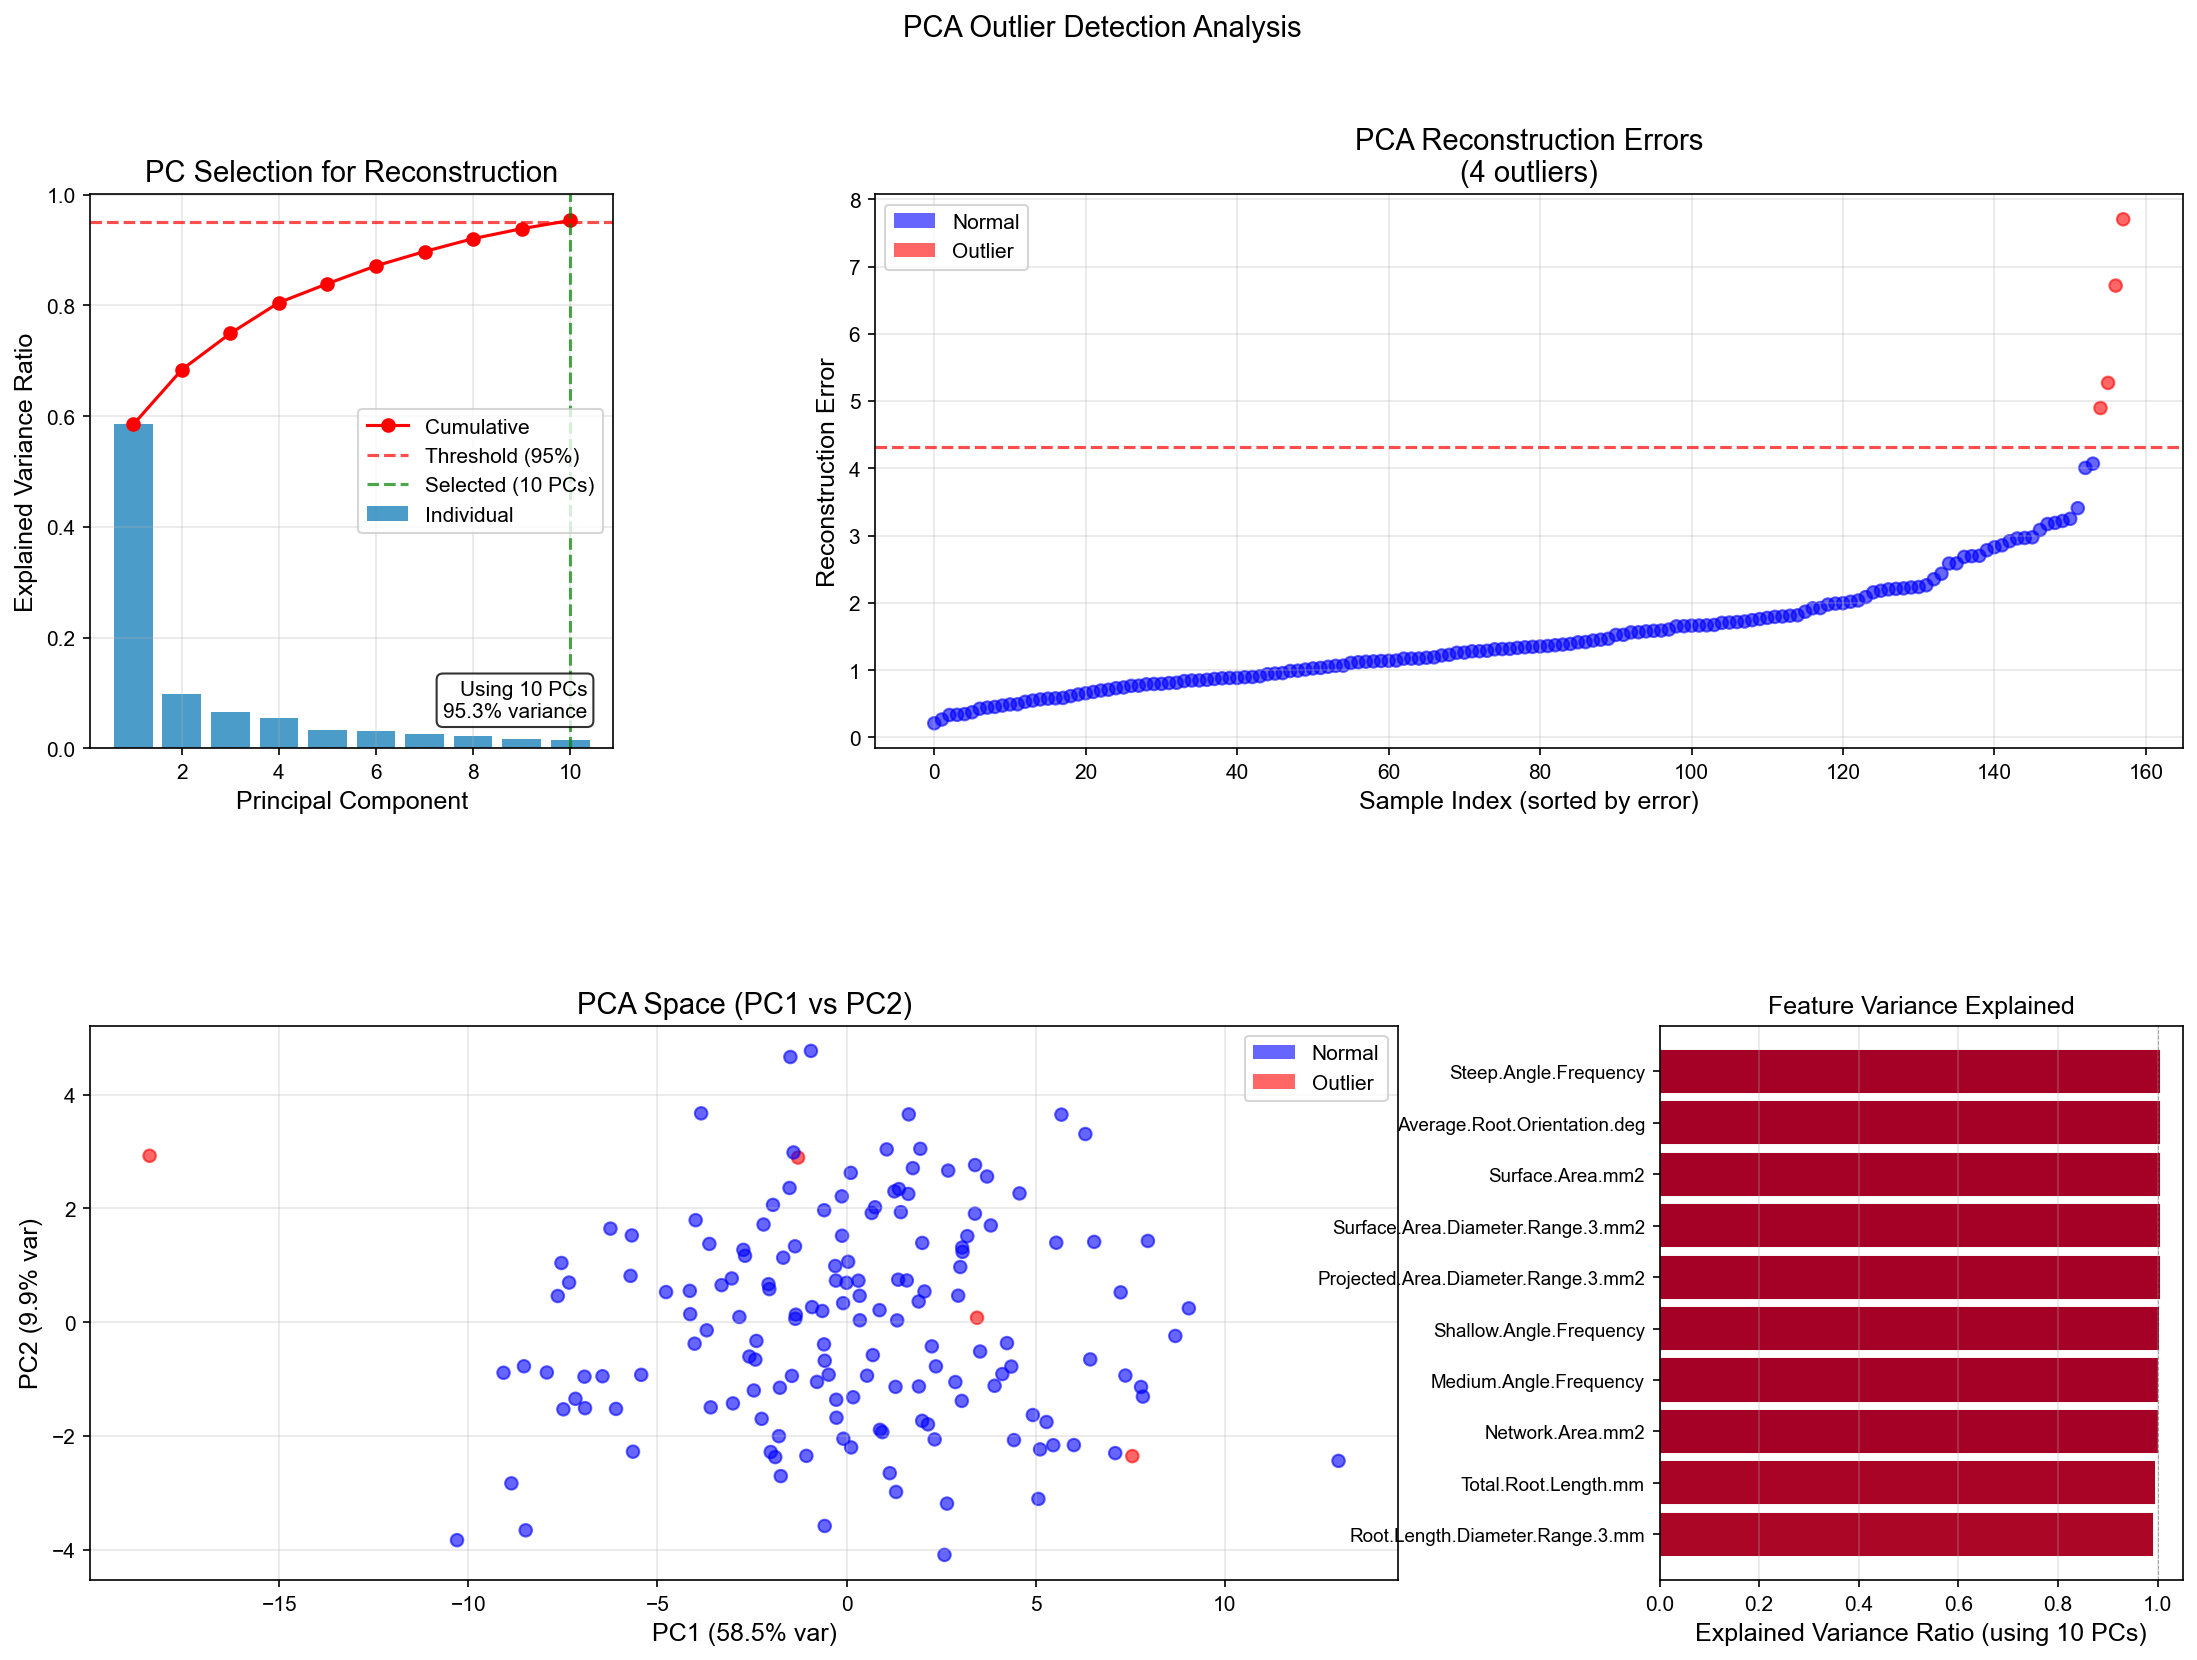

💾 Saved to: outlier_pca_outlier_detection_101925.png

📊 Isolation Forest Analysis


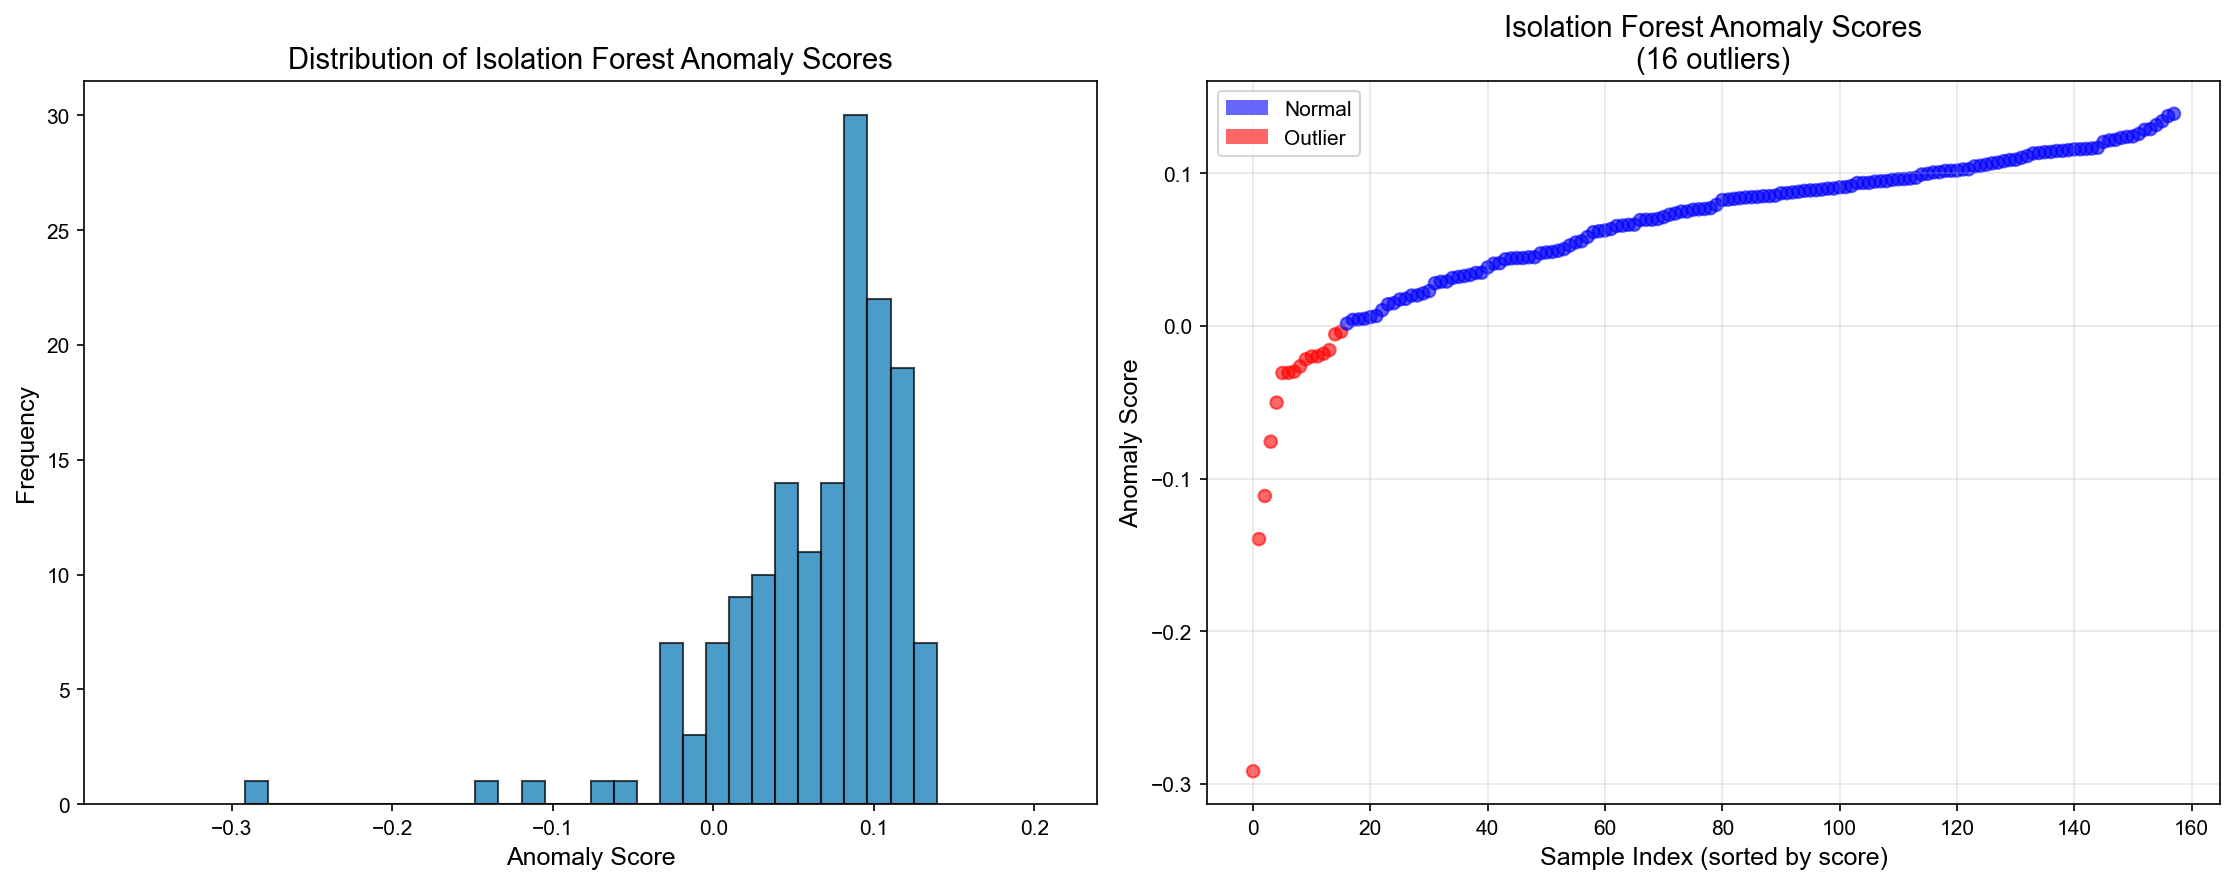

💾 Saved to: outlier_isolation_forest_analysis_101925.png

📊 Kmeans Outlier Analysis


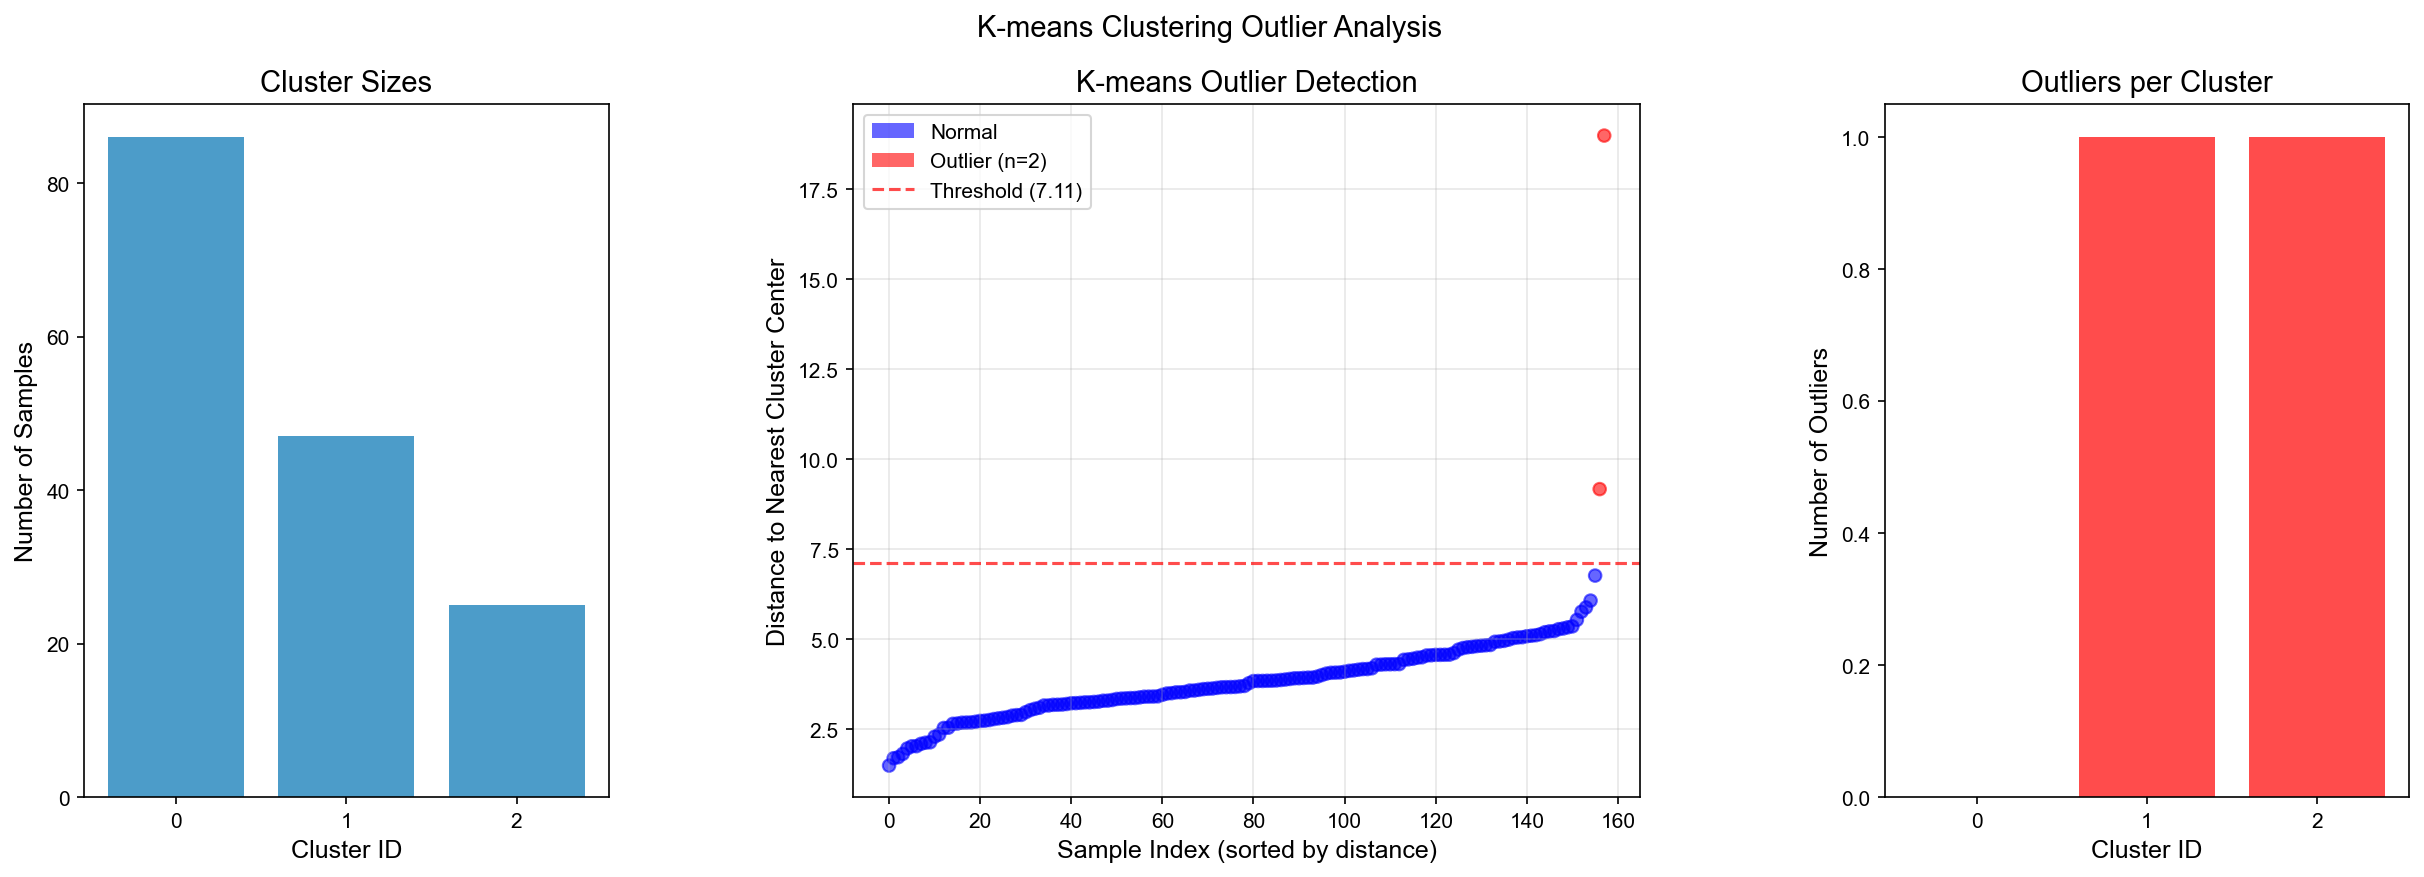

💾 Saved to: outlier_kmeans_outlier_analysis_101926.png

📊 Kmeans Clustering Viz


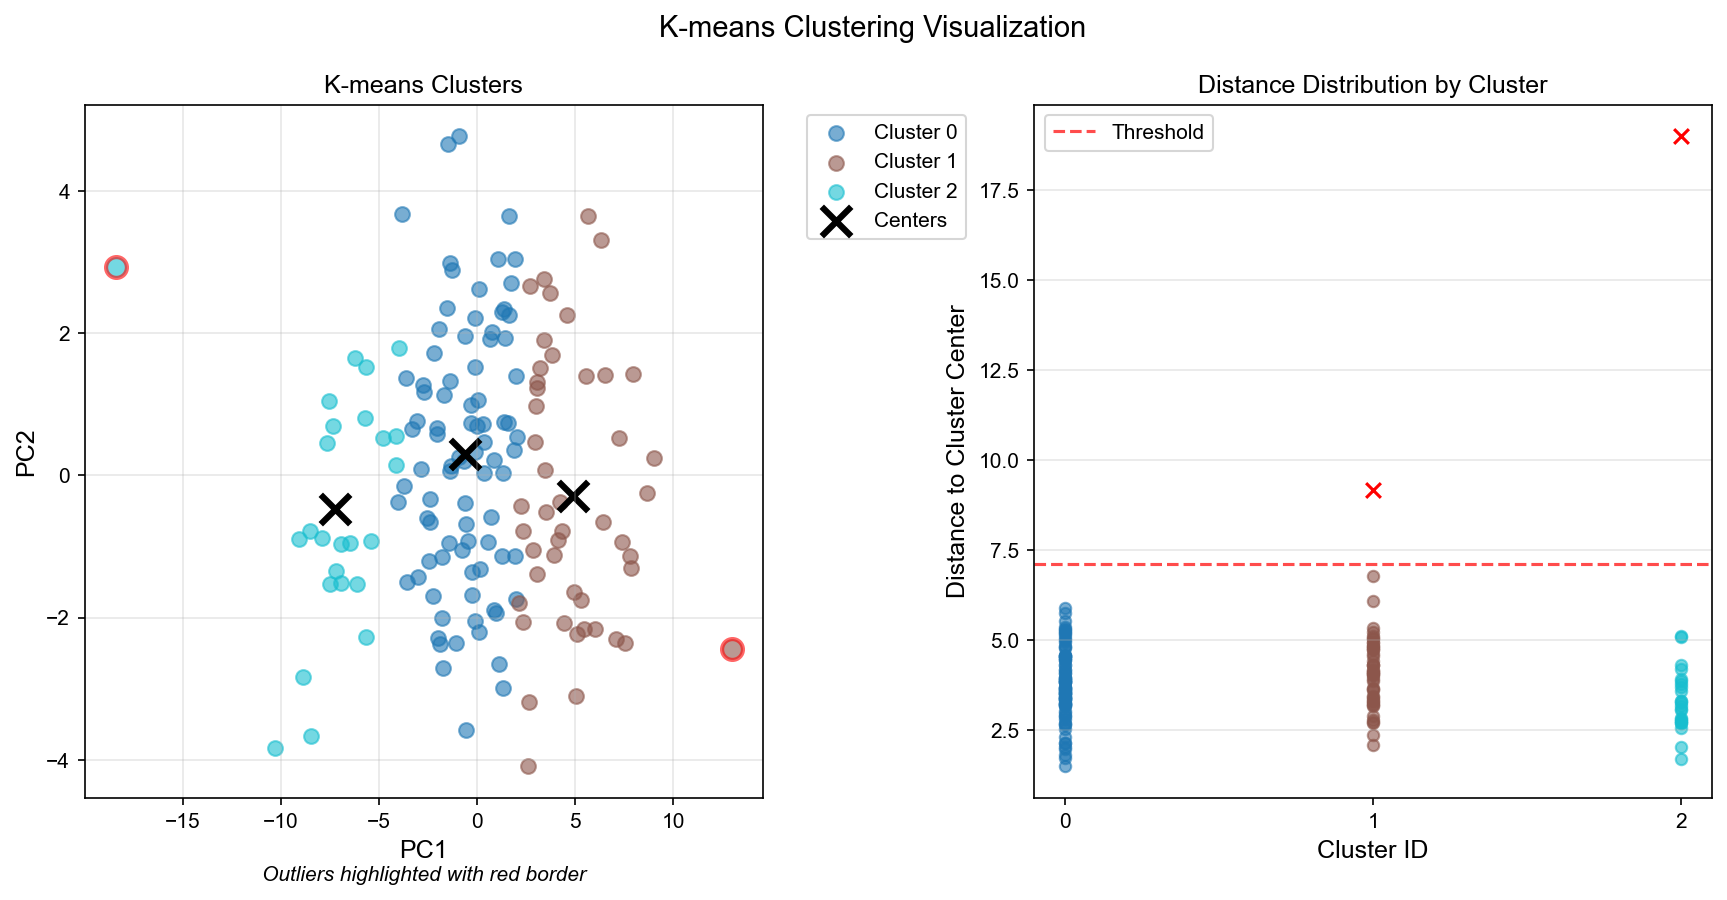

💾 Saved to: outlier_kmeans_clustering_viz_101927.png

📊 Gmm Score Analysis


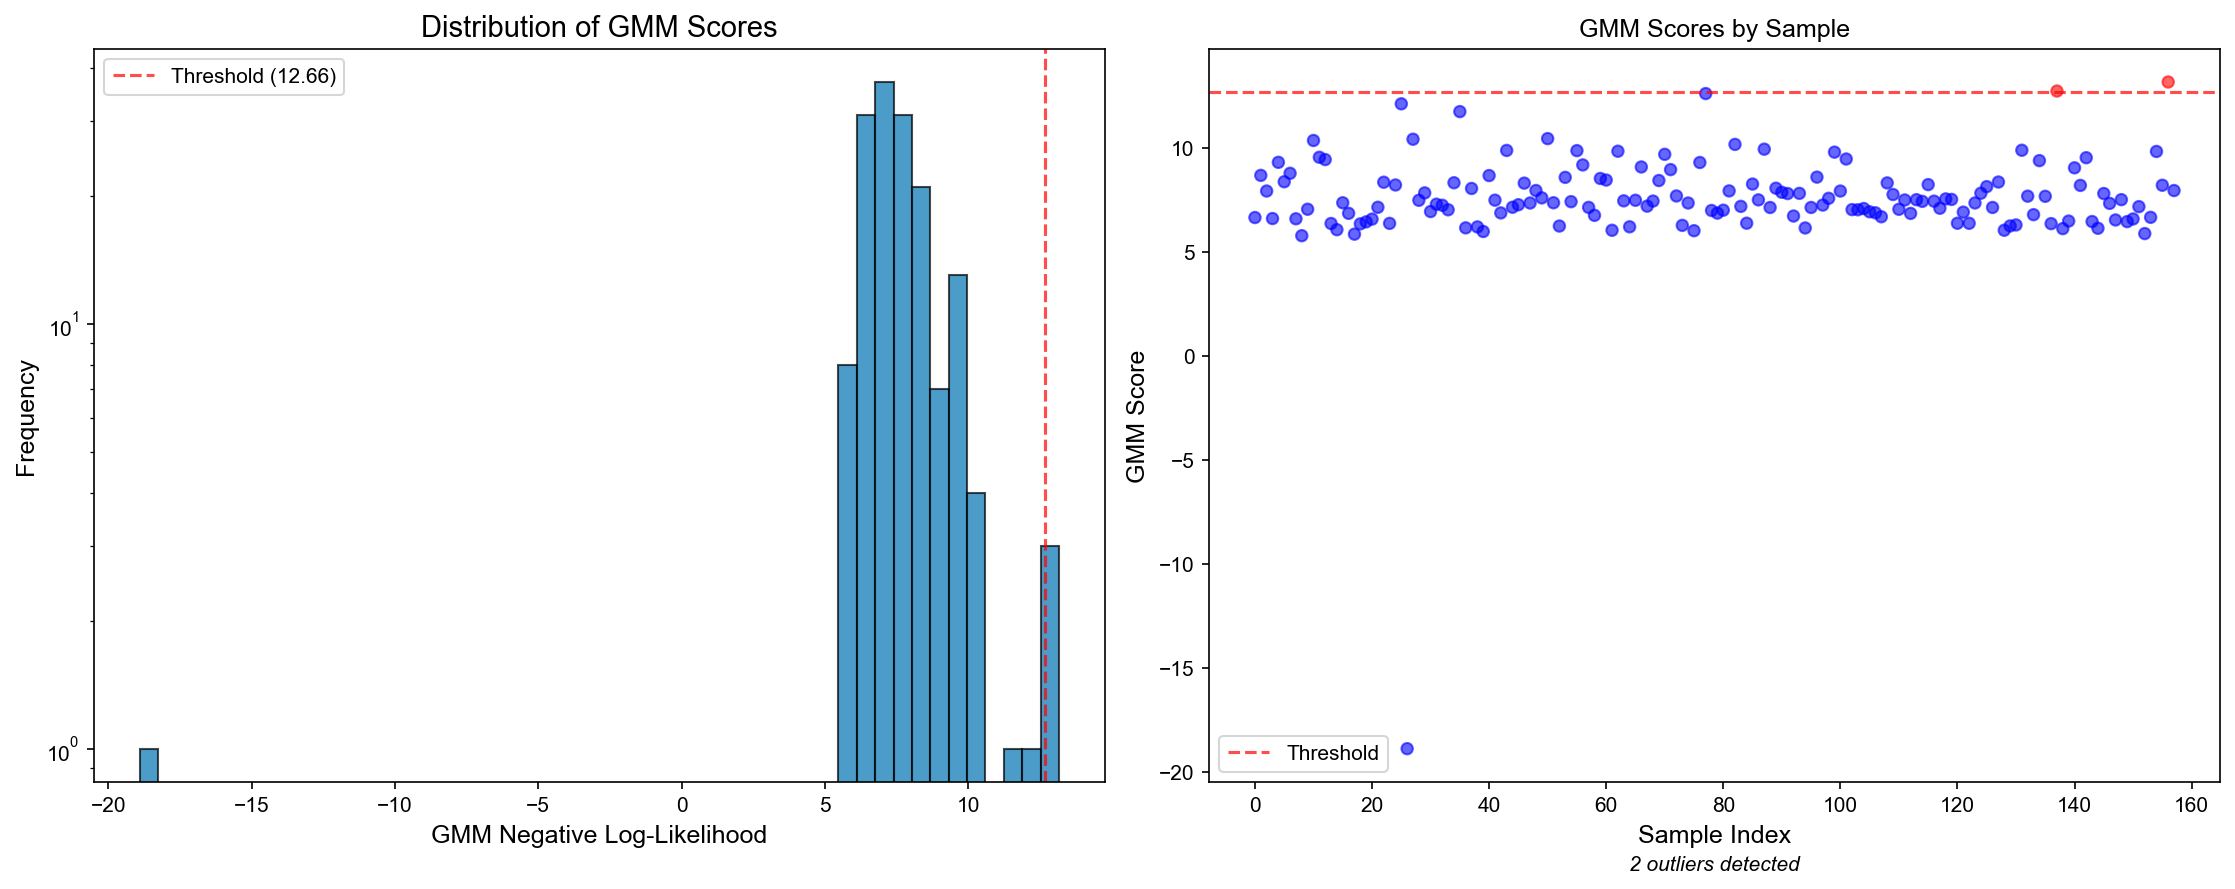

💾 Saved to: outlier_gmm_score_analysis_101927.png

📊 Iqr Outlier Counts


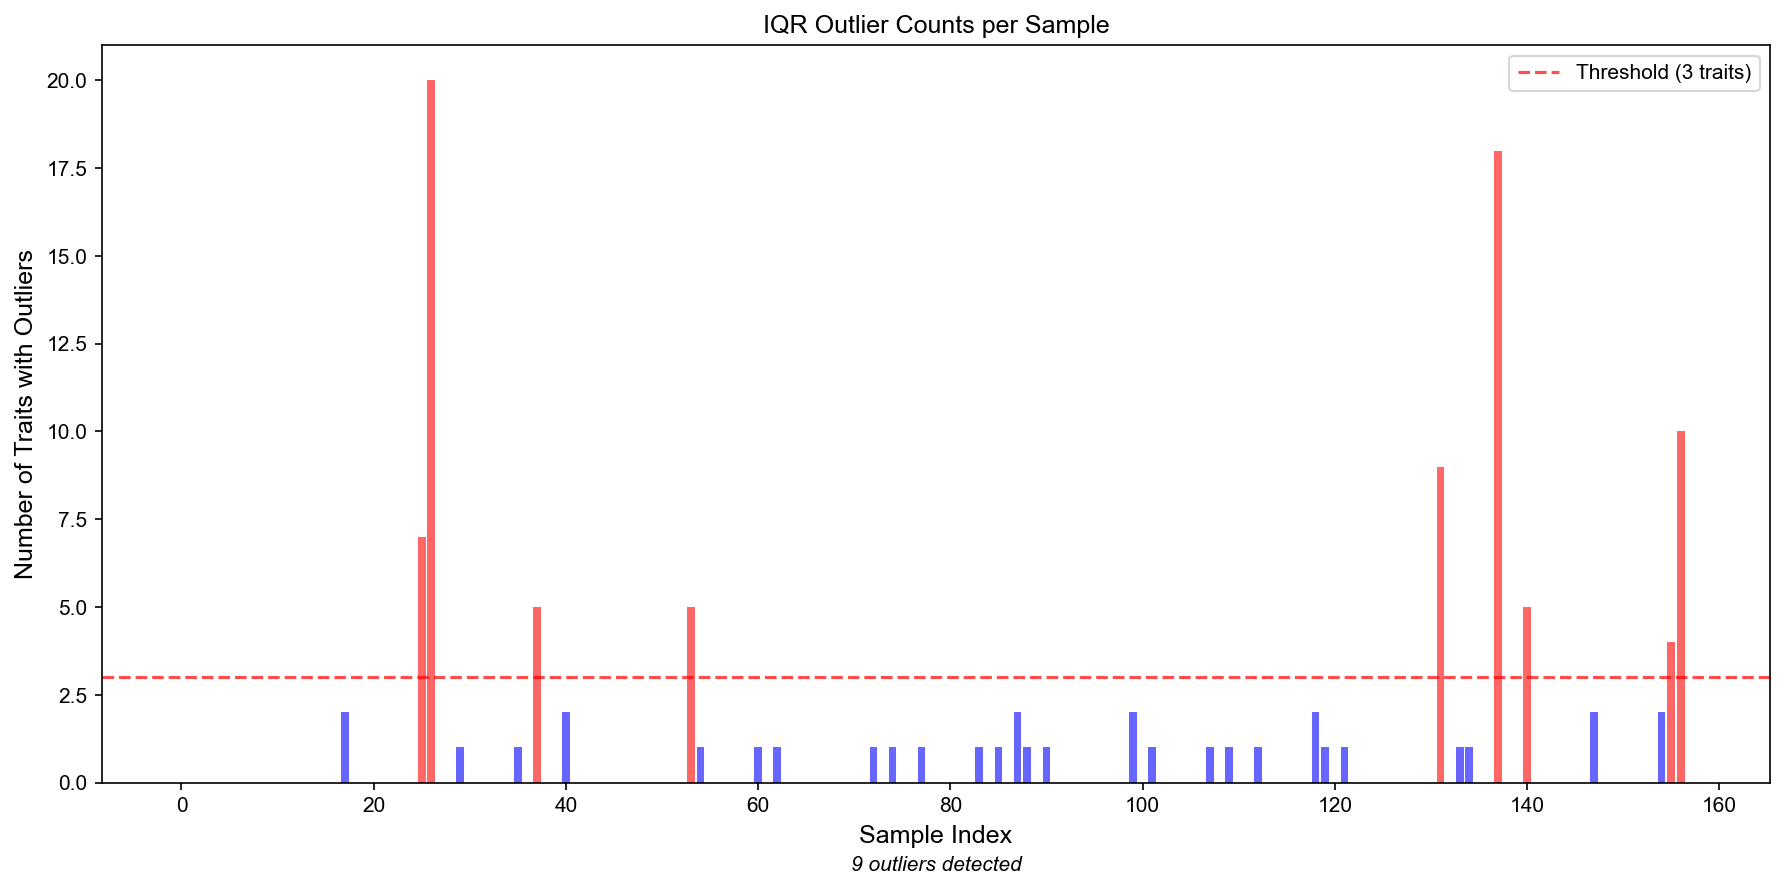

💾 Saved to: outlier_iqr_outlier_counts_101928.png

📊 Iqr Traits With Outliers


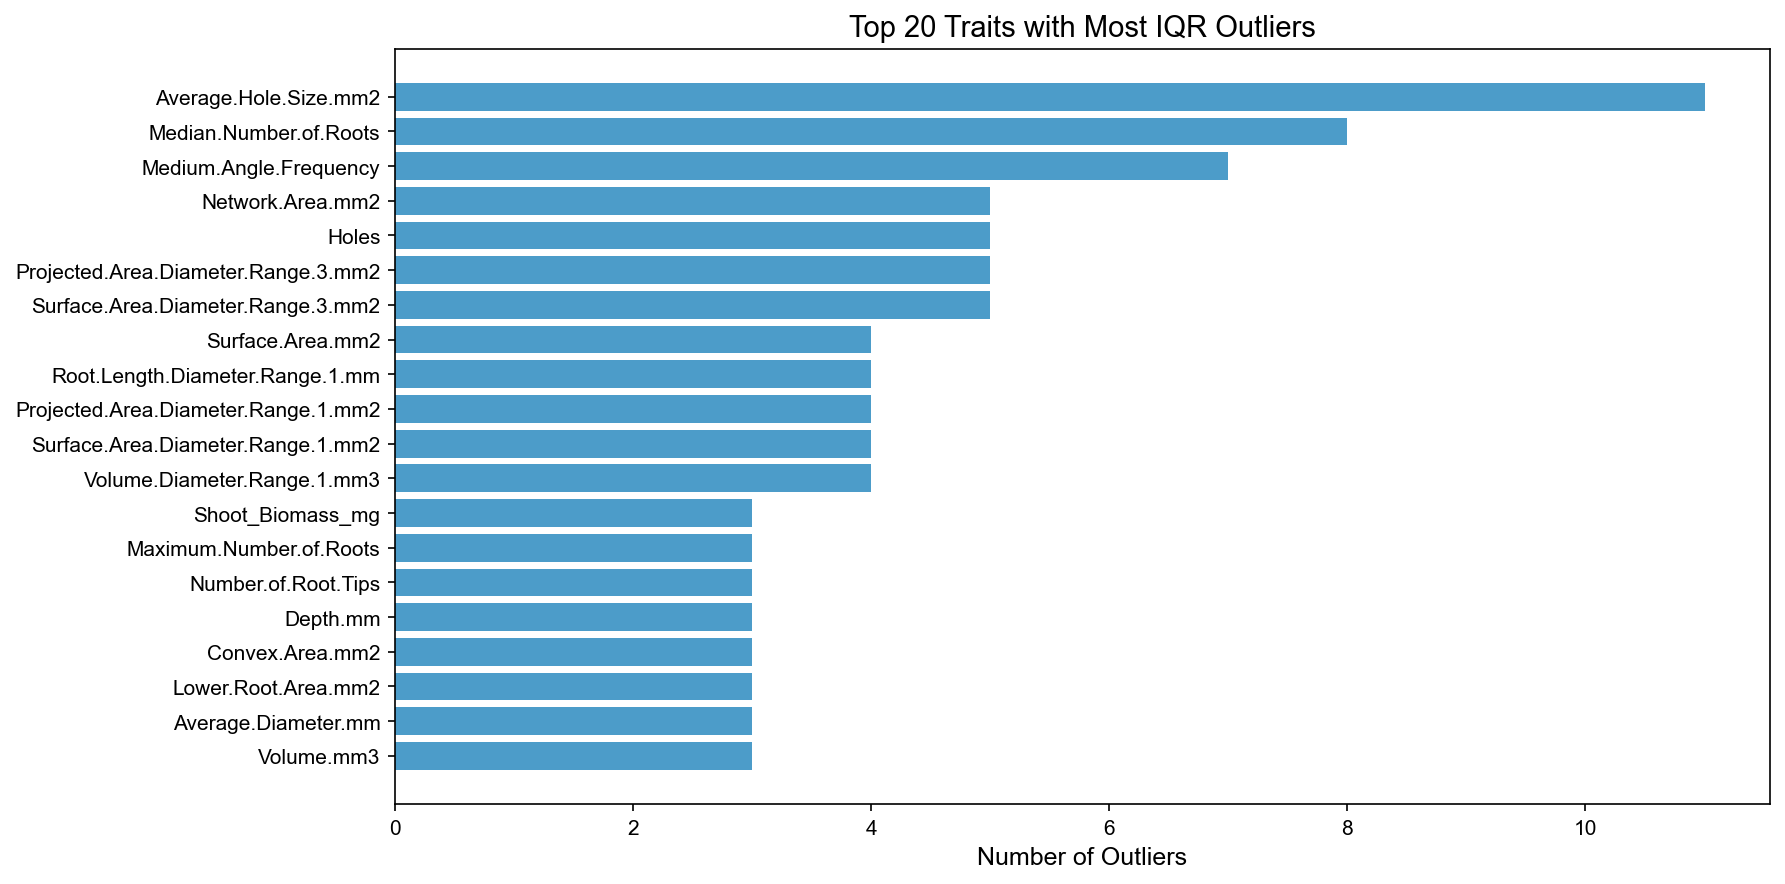

💾 Saved to: outlier_iqr_traits_with_outliers_101928.png

📊 Mahalanobis Outlier Detection


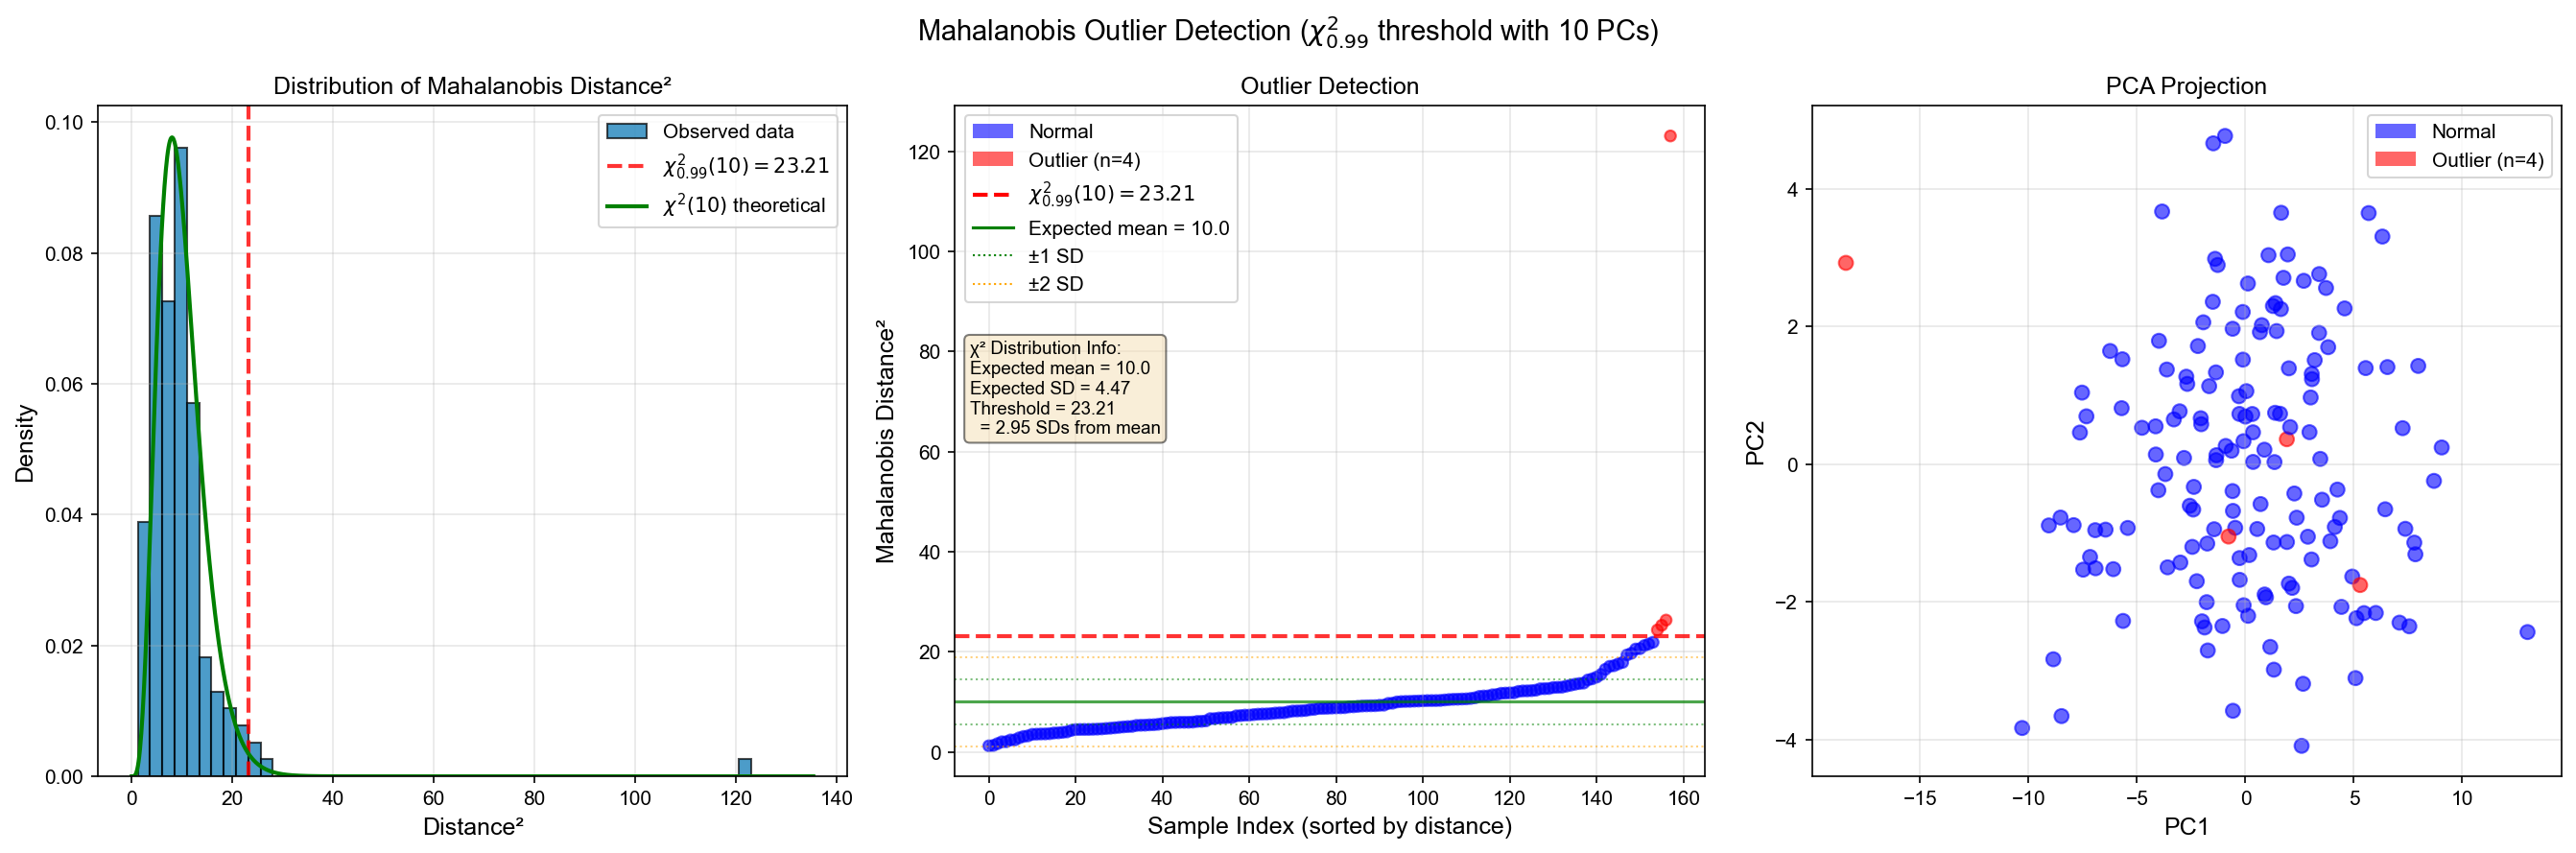

💾 Saved to: outlier_mahalanobis_outlier_detection_101929.png

📊 Mahalanobis Pc Analysis


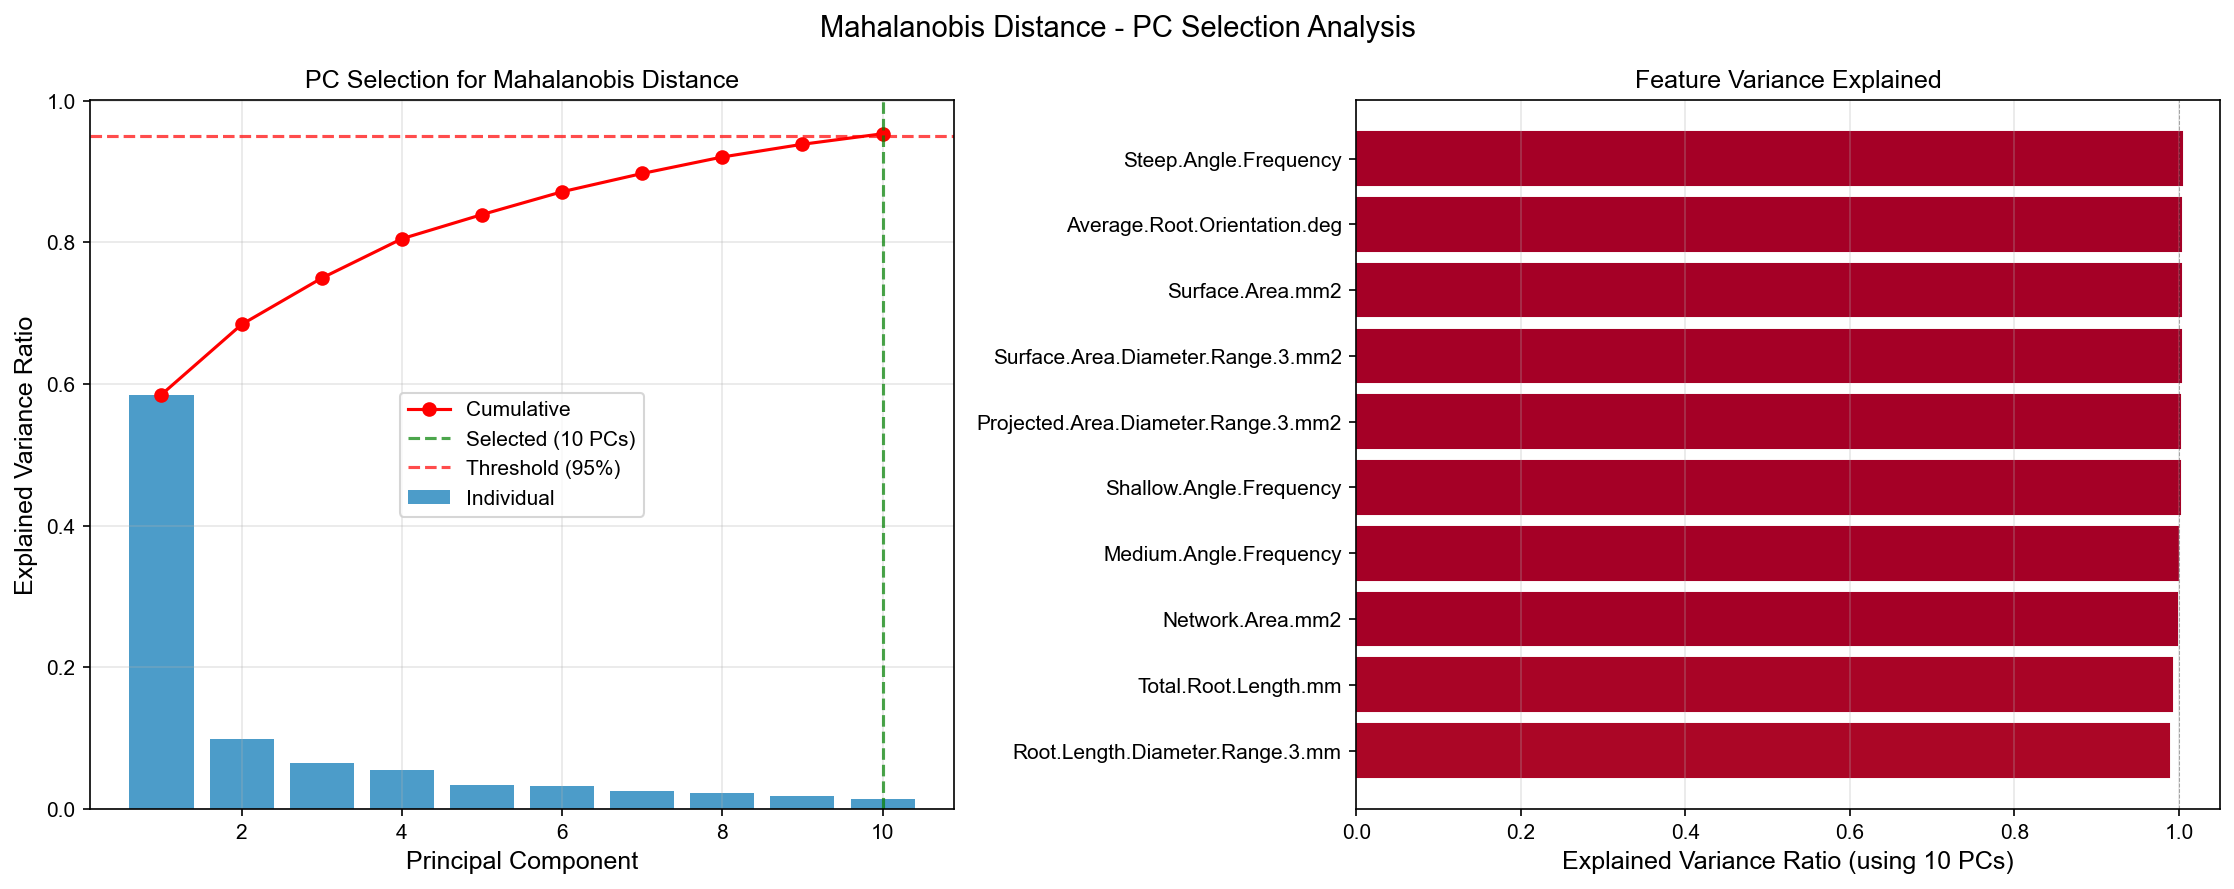

💾 Saved to: outlier_mahalanobis_pc_analysis_101929.png

📊 Mahalanobis Threshold Analysis


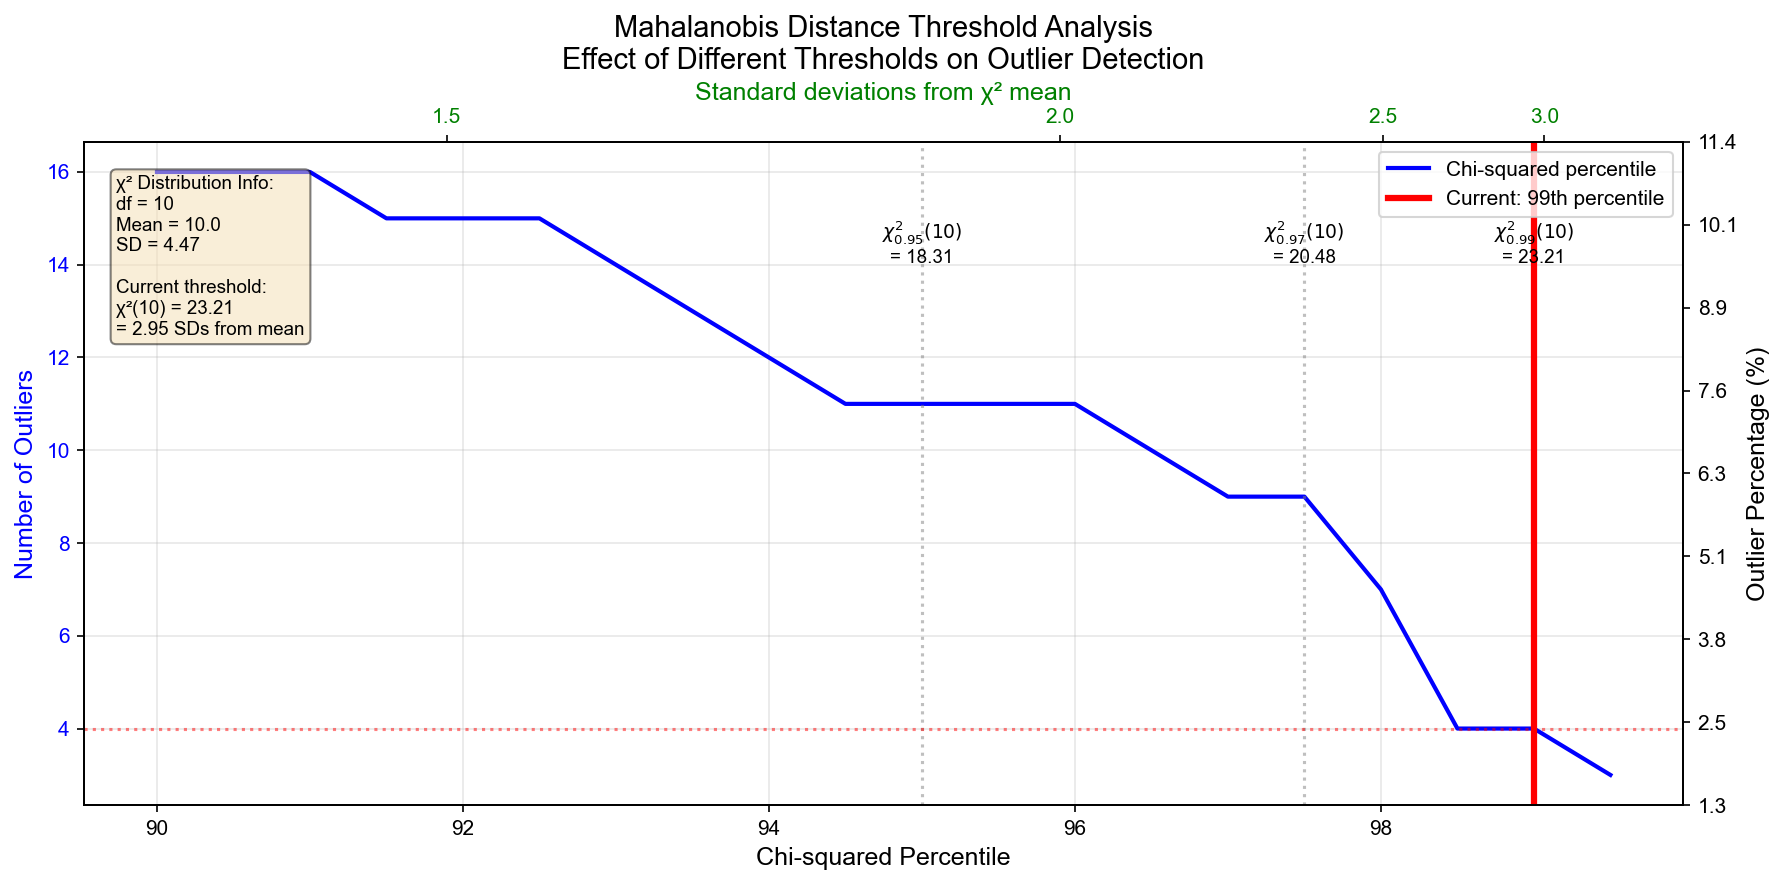

💾 Saved to: outlier_mahalanobis_threshold_analysis_101930.png

📊 Outlier Comparison


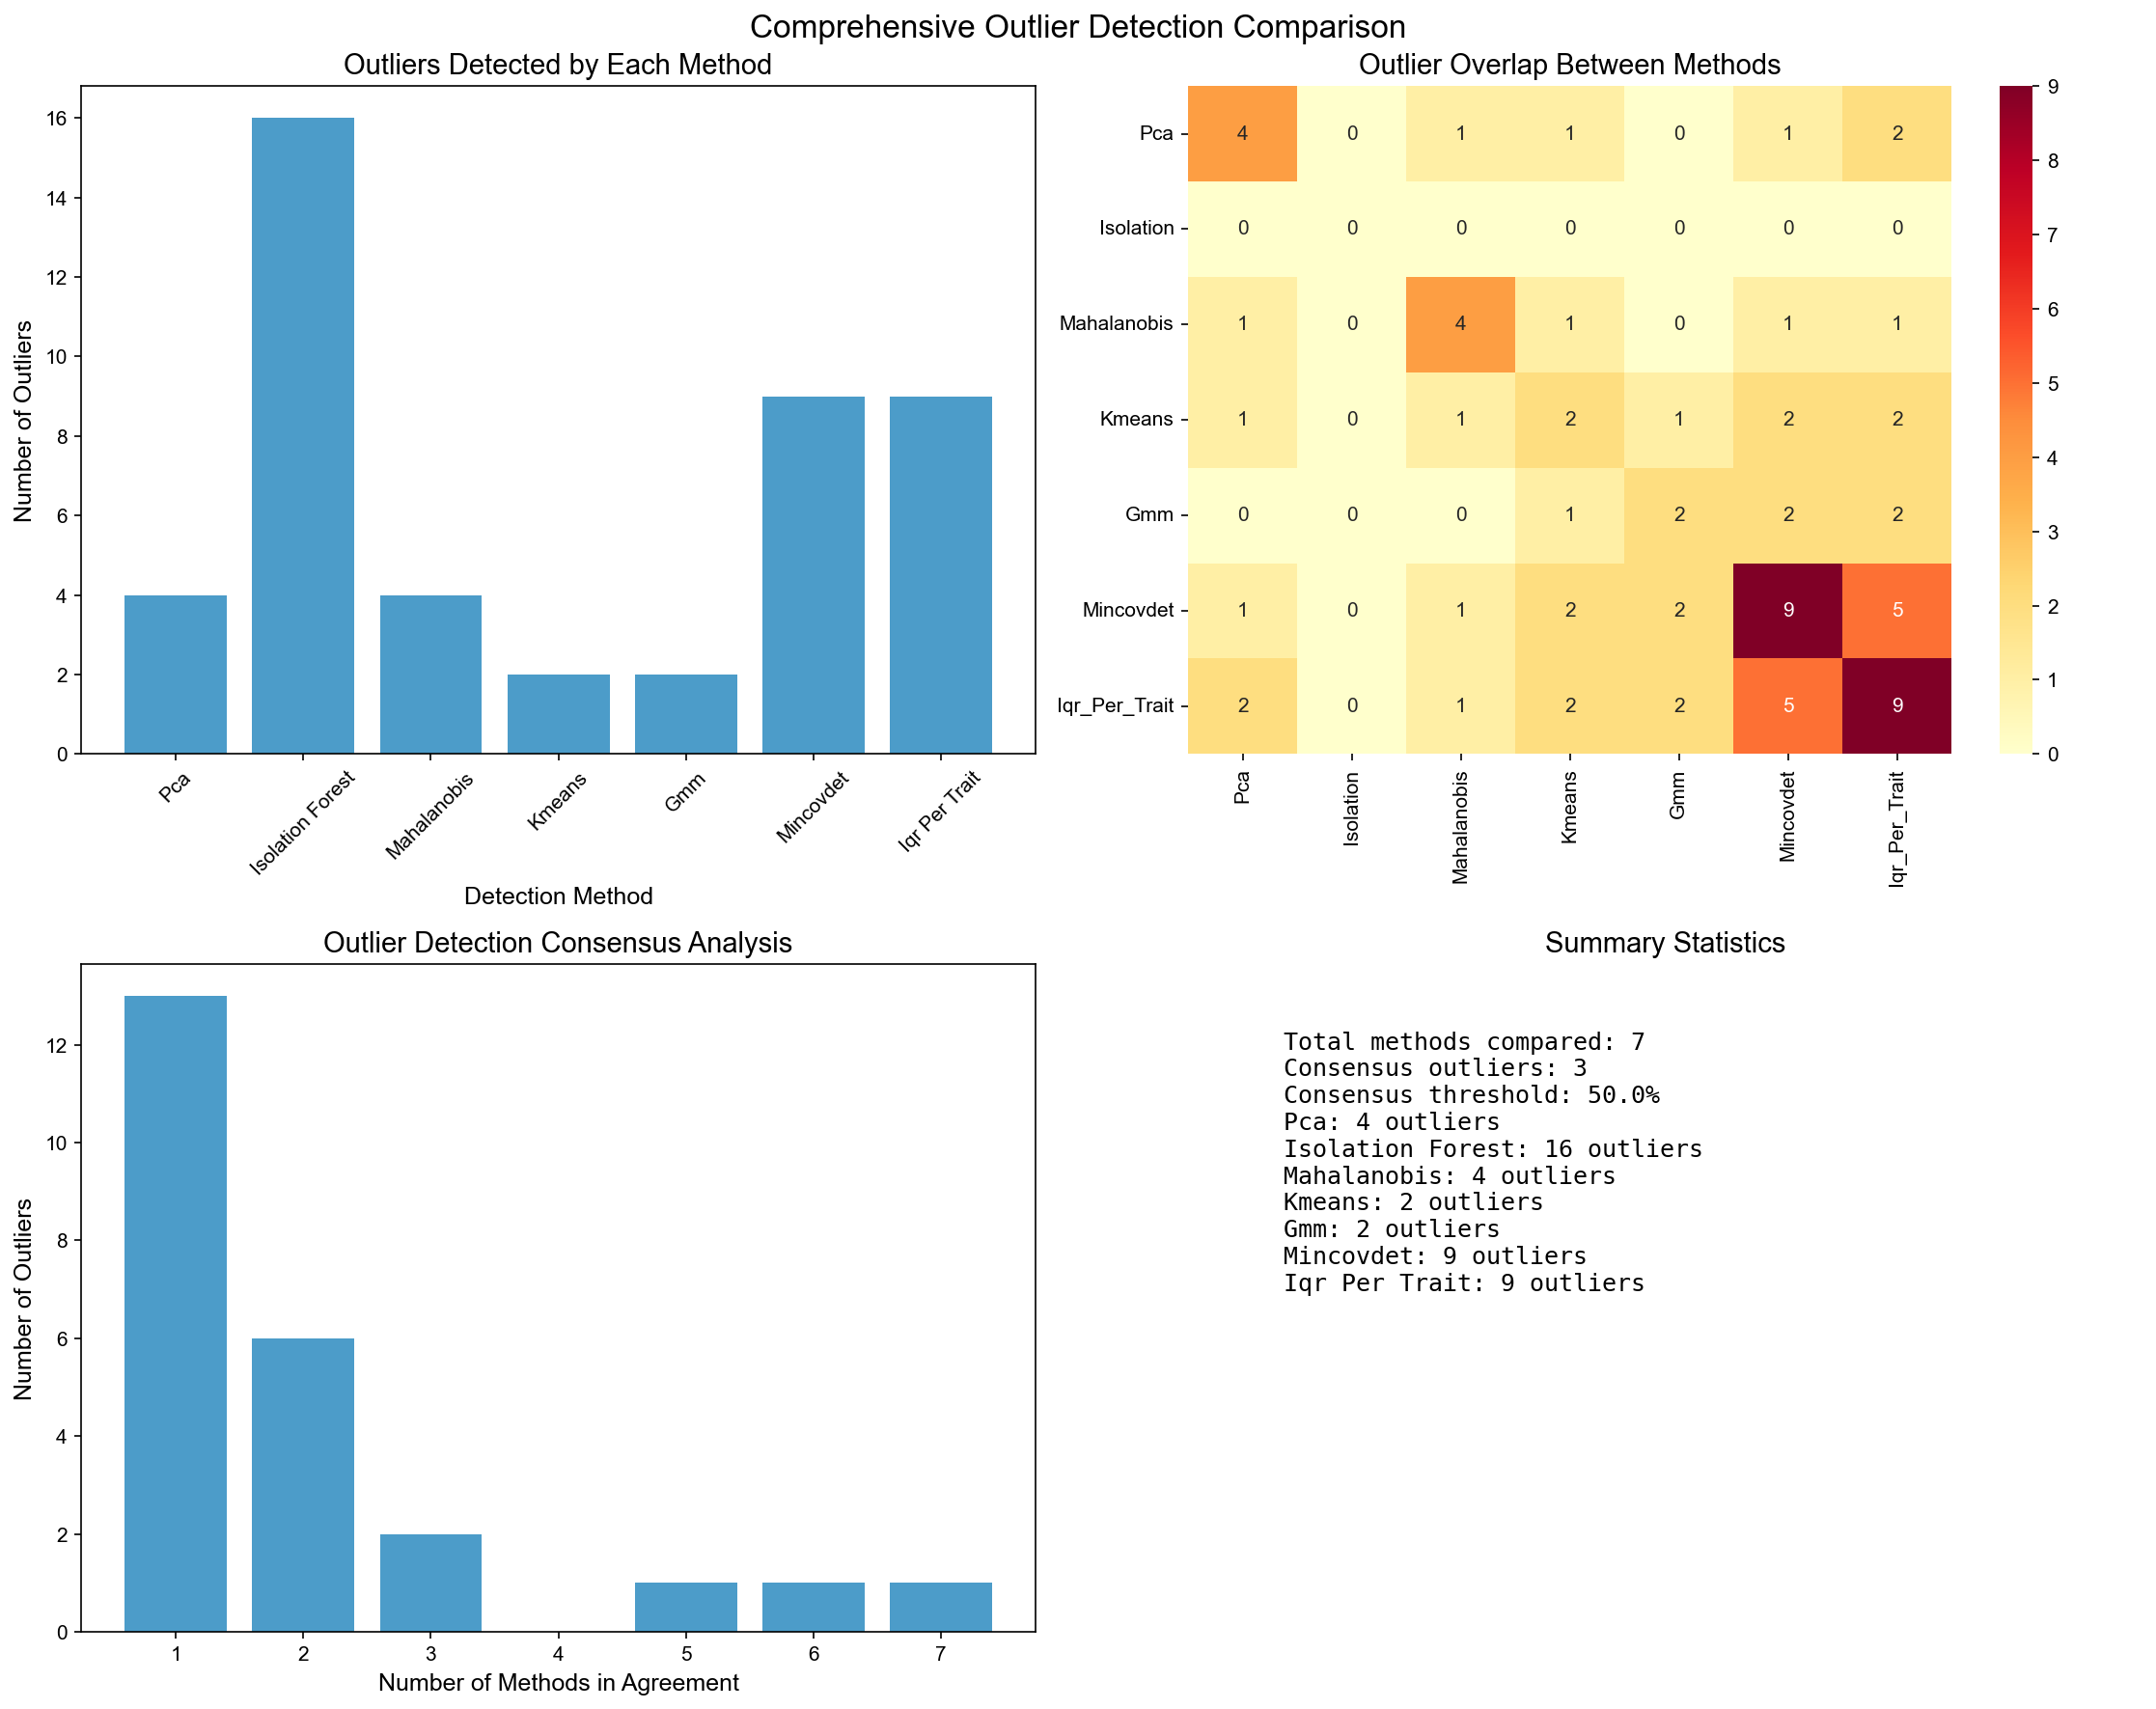

💾 Saved to: outlier_outlier_comparison_101930.png

📊 Outlier Overlap Heatmap


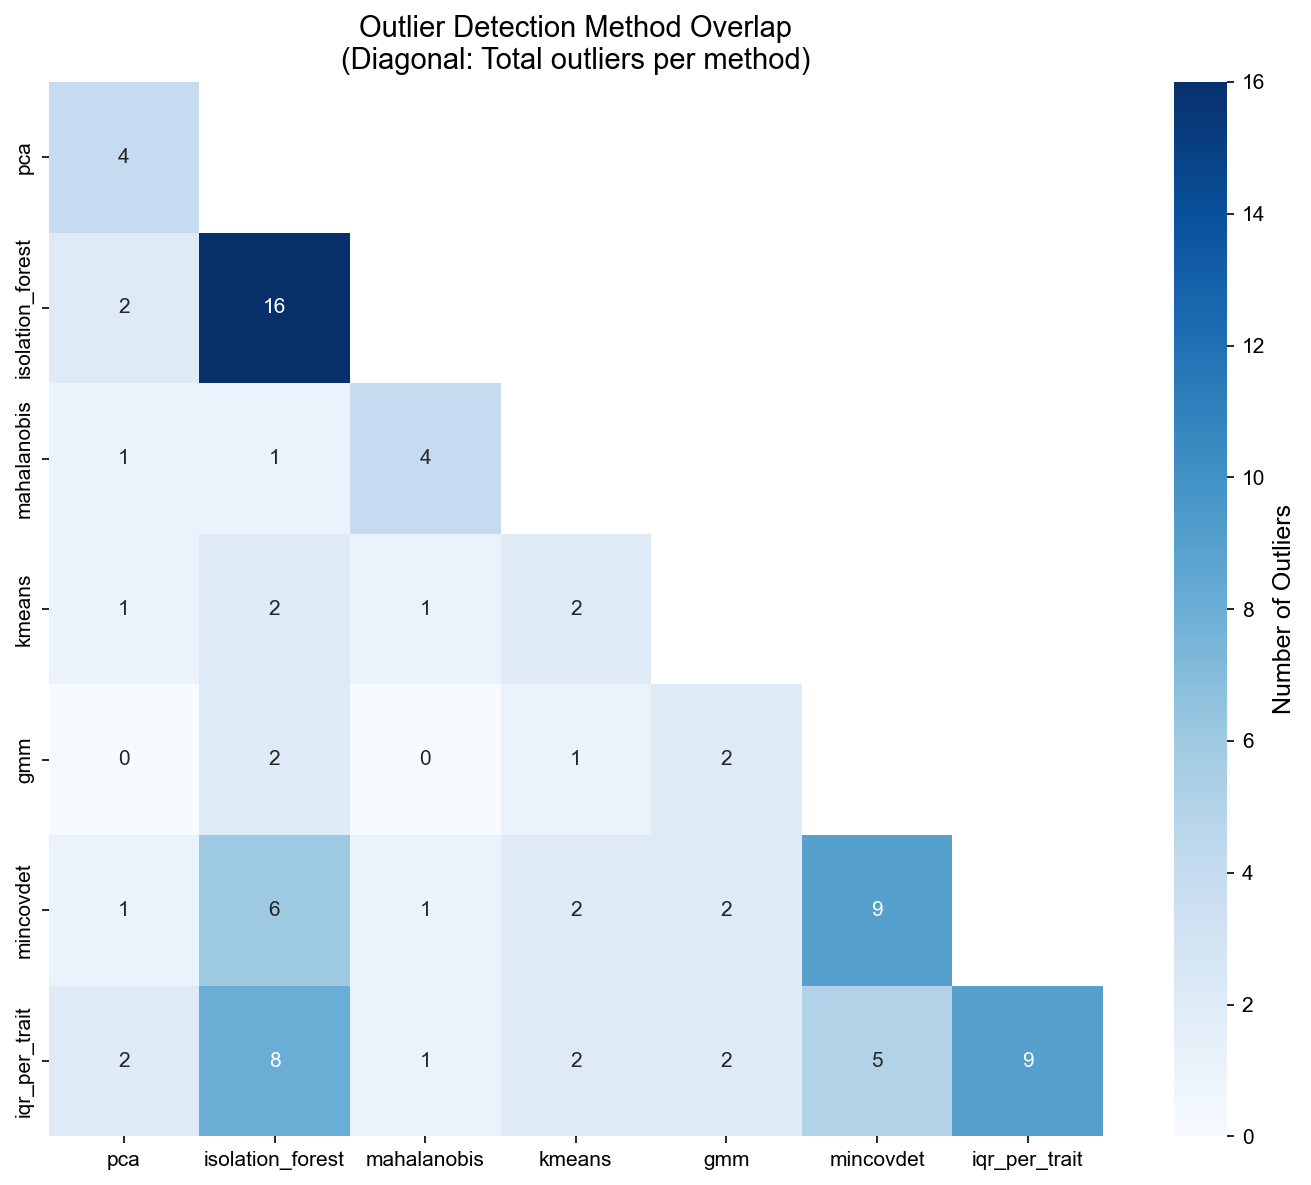

💾 Saved to: outlier_outlier_overlap_heatmap_101931.png

📊 Outliers Per Genotype


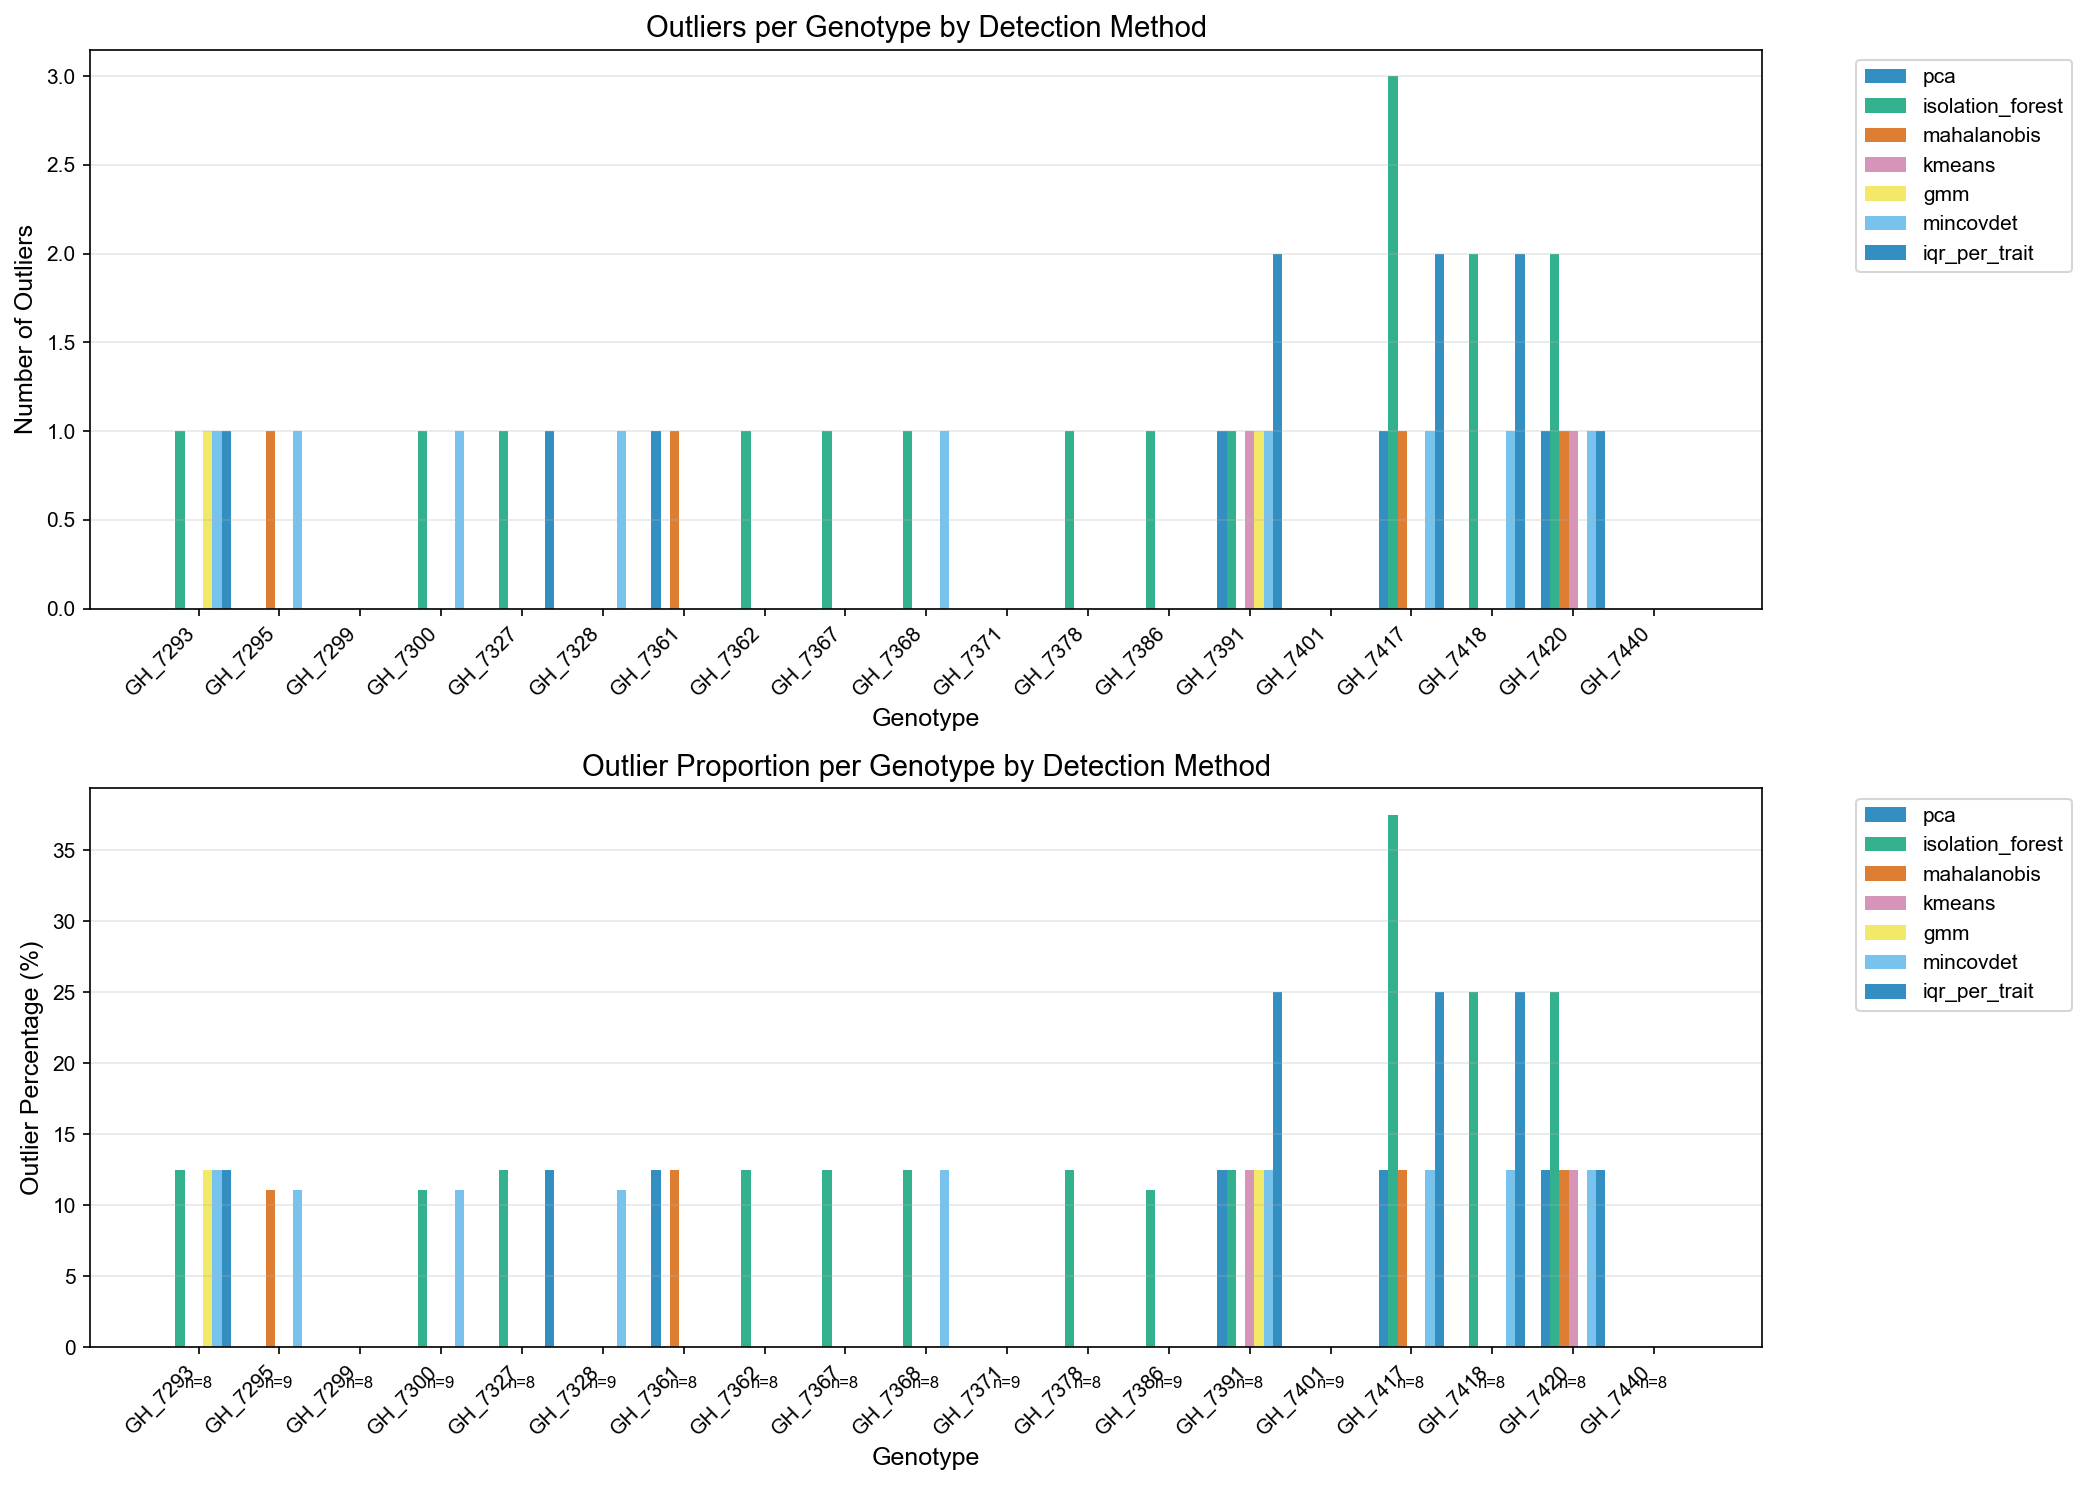

💾 Saved to: outlier_outliers_per_genotype_101931.png

📊 Method Comparison


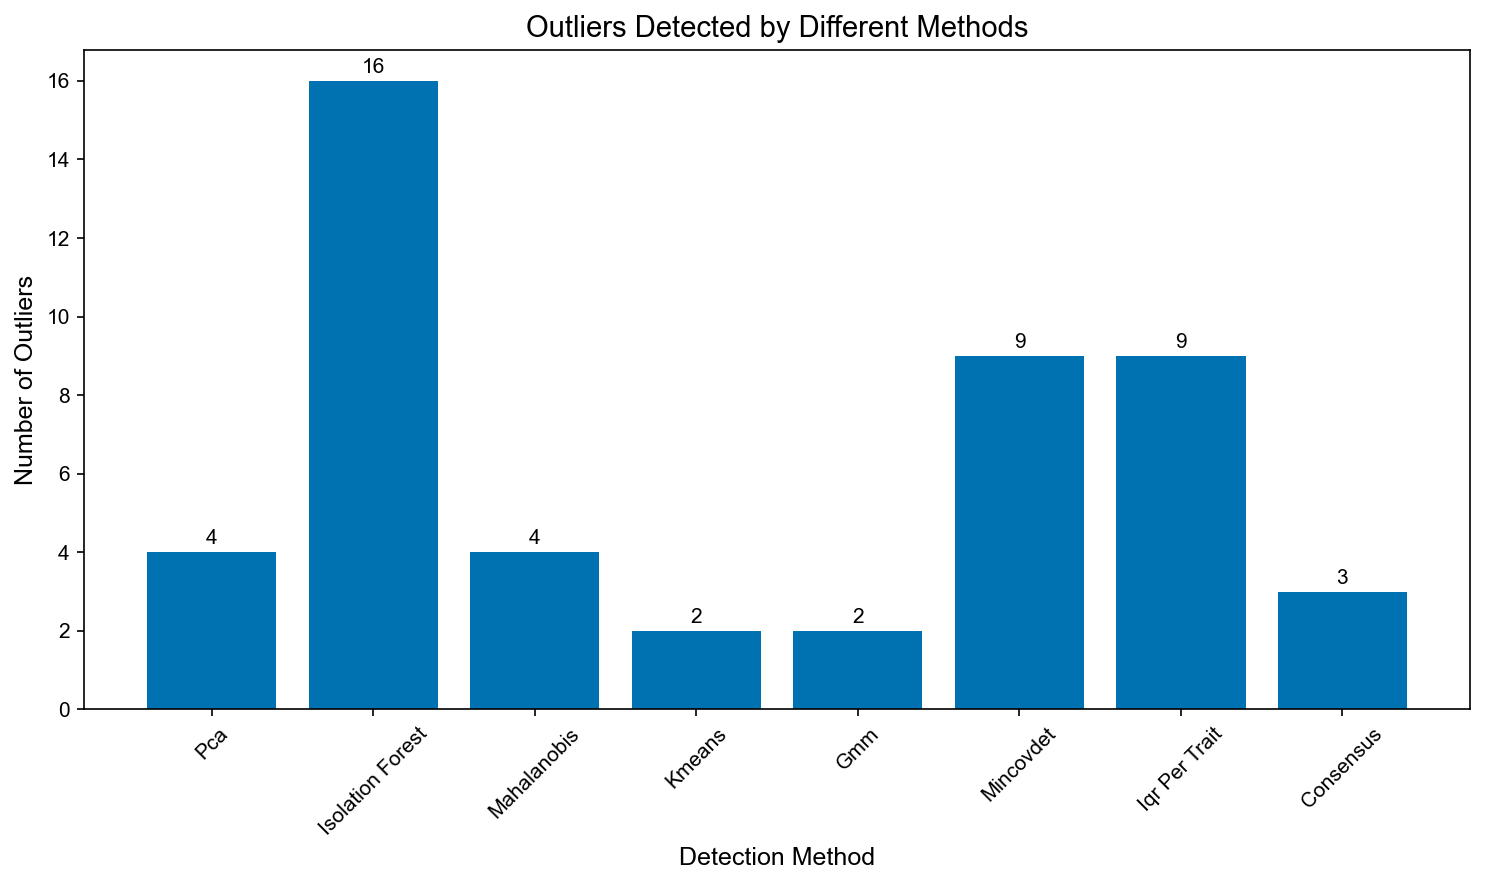

💾 Saved to: outlier_method_comparison_101932.png

✅ Generated and saved 14 outlier detection plots


In [15]:
# Create outlier visualizations
if 'all_outlier_results' in locals() and all_outlier_results:
    # First update all_outlier_results to include the combined results
    if 'combined_results' in locals() and combined_results:
        all_outlier_results["combined"] = combined_results
    
    # Now create the plots
    outlier_figures = {}
    
    # Individual method plots
    if "pca" in all_outlier_results:
        try:
            fig = create_pca_outlier_plot(df_traits, all_outlier_results["pca"])
            if fig is not None:
                outlier_figures["pca_outlier_detection"] = fig
        except Exception as e:
            print(f"⚠️ Could not create PCA plot: {e}")
    
    # Isolation Forest plots
    if "isolation_forest" in all_outlier_results:
        try:
            iso_figures = create_isolation_forest_plots(df_traits, all_outlier_results["isolation_forest"])
            outlier_figures.update(iso_figures)
        except Exception as e:
            print(f"⚠️ Could not create Isolation Forest plots: {e}")
    
    # K-means plots
    if "kmeans" in all_outlier_results:
        try:
            kmeans_figures = create_kmeans_outlier_plots(df_traits, all_outlier_results["kmeans"])
            outlier_figures.update(kmeans_figures)
        except Exception as e:
            print(f"⚠️ Could not create K-means plots: {e}")
    
    # Add method-specific plots
    if "gmm" in all_outlier_results:
        try:
            gmm_figures = create_gmm_outlier_plots(df_traits, all_outlier_results["gmm"])
            outlier_figures.update(gmm_figures)
        except Exception as e:
            print(f"⚠️ Could not create GMM plots: {e}")
    
    if "mincovdet" in all_outlier_results:
        try:
            mcd_figures = create_mincovdet_plots(df_traits, all_outlier_results["mincovdet"])
            outlier_figures.update(mcd_figures)
        except Exception as e:
            print(f"⚠️ Could not create MinCovDet plots: {e}")
    
    if "iqr_per_trait" in all_outlier_results:
        try:
            iqr_figures = create_iqr_outlier_plots(df_traits, all_outlier_results["iqr_per_trait"])
            outlier_figures.update(iqr_figures)
        except Exception as e:
            print(f"⚠️ Could not create IQR plots: {e}")
    
    if "mahalanobis" in all_outlier_results:
        try:
            mahal_figures = create_mahalanobis_outlier_plots(df_traits, all_outlier_results["mahalanobis"])
            outlier_figures.update(mahal_figures)
        except Exception as e:
            print(f"⚠️ Could not create Mahalanobis plots: {e}")
    
    # Add comprehensive comparison
    try:
        comp_fig = create_comprehensive_outlier_comparison(all_outlier_results)
        if comp_fig is not None:
            outlier_figures["outlier_comparison"] = comp_fig
    except Exception as e:
        print(f"⚠️ Could not create comparison plot: {e}")
    
    # Add overlap heatmap
    try:
        overlap_fig = create_outlier_overlap_heatmap(all_outlier_results)
        if overlap_fig is not None:
            outlier_figures["outlier_overlap_heatmap"] = overlap_fig
    except Exception as e:
        print(f"⚠️ Could not create overlap heatmap: {e}")
    
    # Add outliers per genotype plot
    try:
        genotype_fig = create_outliers_per_genotype_plot(df_traits, all_outlier_results, "geno")
        if genotype_fig is not None:
            outlier_figures["outliers_per_genotype"] = genotype_fig
    except Exception as e:
        print(f"⚠️ Could not create outliers per genotype plot: {e}")
    
    # Method comparison plot
    if "combined" in all_outlier_results:
        try:
            combined = all_outlier_results["combined"]
            method_names = []
            method_counts = []
            
            for key, outliers in combined.items():
                if key.endswith("_outliers") and isinstance(outliers, list):
                    method_name = key.replace("_outliers", "").replace("_", " ").title()
                    method_names.append(method_name)
                    method_counts.append(len(outliers))
            
            if method_names:
                fig, ax = plt.subplots(figsize=(10, 6))
                bars = ax.bar(method_names, method_counts)
                ax.set_title("Outliers Detected by Different Methods", fontsize=TITLE_FONTSIZE)
                ax.set_xlabel("Detection Method", fontsize=LABEL_FONTSIZE)
                ax.set_ylabel("Number of Outliers", fontsize=LABEL_FONTSIZE)
                ax.tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar, count in zip(bars, method_counts):
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_height() + 0.1,
                        str(count),
                        ha="center",
                        va="bottom",
                        fontsize=TICK_FONTSIZE,
                    )
                
                plt.tight_layout()
                outlier_figures["method_comparison"] = fig
        except Exception as e:
            print(f"⚠️ Could not create method comparison plot: {e}")
    
    # Display and save figures
    for fig_name, fig in outlier_figures.items():
        if fig is not None:
            print(f"\n📊 {fig_name.replace('_', ' ').title()}")
            display(fig)
            # Save figure
            fig_path = save_figure_with_unique_name(fig, FIGURES_DIR, f"outlier_{fig_name}")
            print(f"💾 Saved to: {fig_path.name}")
            plt.close(fig)
    
    print(f"\n✅ Generated and saved {len(outlier_figures)} outlier detection plots")
else:
    print("⚠️ No outlier results available for visualization")

### 4.2 Remove Outliers

Remove identified outliers from the dataset before proceeding to heritability analysis.

In [16]:
# Remove outliers from the dataset using selected method
if 'outliers_to_remove' in locals() and outliers_to_remove:
    # The outlier indices are already DataFrame indices
    df_cleaned_outliers = df_traits.drop(index=outliers_to_remove)
    
    # Save outlier-removed data
    outlier_removed_data_path = RUN_DIR / "03_data_outliers_removed.csv"
    df_cleaned_outliers.to_csv(outlier_removed_data_path, index=False)
    print(f"✅ Removed {len(outliers_to_remove)} outliers using {OUTLIER_REMOVAL_METHOD} method")
    print(f"✅ Saved outlier-removed data to: {outlier_removed_data_path.name}")
    
    # Save outlier information
    outlier_rows = df_traits.loc[outliers_to_remove].copy()
    
    # Add outlier information - which methods detected each outlier
    outlier_info = []
    for idx in outliers_to_remove:
        methods_detected = []
        if 'all_outlier_results' in locals():
            for method, results in all_outlier_results.items():
                if method != "combined" and "outlier_indices" in results and idx in results["outlier_indices"]:
                    methods_detected.append(method)
        outlier_info.append(";".join(methods_detected))
    
    outlier_rows["outlier_methods"] = outlier_info
    outlier_rows["removal_method"] = OUTLIER_REMOVAL_METHOD
    outlier_rows["removal_reason"] = f"Detected by {OUTLIER_REMOVAL_METHOD} method"
    
    # Save removed outlier samples
    outlier_removed_samples_path = RUN_DIR / "03_outlier_removed_samples.csv"
    outlier_rows.to_csv(outlier_removed_samples_path, index=True)
    print(f"✅ Saved {len(outlier_rows)} outlier samples to: {outlier_removed_samples_path.name}")
    
    # Save outlier detection results
    outlier_results_path = RUN_DIR / "03_outlier_detection_results.json"
    with open(outlier_results_path, "w") as f:
        json.dump(_convert_to_json_serializable(all_outlier_results), f, indent=2)
    print(f"✅ Saved outlier detection results to: {outlier_results_path.name}")
    
    # Update working dataframe
    df_traits = df_cleaned_outliers.copy()
    
else:
    df_traits = df_traits.copy()
    print("ℹ️ No outliers removed")

print(f"\n📊 Outlier Removal Summary:")
print(f"  - Samples before outlier removal: {len(df_no_nan)}")
print(f"  - Samples after outlier removal: {len(df_traits)} ({len(df_traits)/len(df_no_nan)*100:.1f}%)")
print(f"  - Outliers removed: {len(outliers_to_remove) if 'outliers_to_remove' in locals() and outliers_to_remove else 0}")

✅ Removed 4 outliers using mahalanobis method
✅ Saved outlier-removed data to: 03_data_outliers_removed.csv
✅ Saved 4 outlier samples to: 03_outlier_removed_samples.csv
✅ Saved outlier detection results to: 03_outlier_detection_results.json

📊 Outlier Removal Summary:
  - Samples before outlier removal: 158
  - Samples after outlier removal: 154 (97.5%)
  - Outliers removed: 4


## 5. Statistical Analysis (Using Outlier-Cleaned Data)

### 5.1 ANOVA - Test for Genotype Effects
Perform one-way ANOVA for each trait to identify significant genotype effects using outlier-cleaned data.

In [17]:
# Perform ANOVA
anova_results = perform_anova_by_genotype(df_traits, trait_cols, "geno")

# Count significant traits
valid_anova = {
    k: v for k, v in anova_results.items()
    if isinstance(v, dict) and "significant" in v
}
n_significant = sum(1 for result in valid_anova.values() if result.get("significant", False))

print(f"\n📊 ANOVA Results:")
print(f"  - Traits analyzed: {len(anova_results)}")
print(f"  - Traits with significant genotype effects (p < 0.05): {n_significant}/{len(valid_anova)}")
if valid_anova:
    avg_f = sum(v.get('f_statistic', 0) for v in valid_anova.values()) / len(valid_anova)
    print(f"  - Average F-statistic: {avg_f:.2f}")


📊 ANOVA Results:
  - Traits analyzed: 34
  - Traits with significant genotype effects (p < 0.05): 25/34
  - Average F-statistic: 2.70


In [18]:
# Calculate heritability
heritability_results = calculate_heritability_estimates(
    df_traits, trait_cols, "geno", "rep"
)

# Count valid heritability estimates
valid_heritability = {
    k: v for k, v in heritability_results.items()
    if isinstance(v, dict) and "heritability" in v
}

# Check which model type was used (mixed model vs ANOVA fallback)
model_types_used = {}
for trait, result in valid_heritability.items():
    model_type = result.get("model_type", "unknown")
    if model_type not in model_types_used:
        model_types_used[model_type] = 0
    model_types_used[model_type] += 1

# Identify high heritability traits
high_h2_traits = identify_high_heritability_traits(
    heritability_results, threshold=HERITABILITY_THRESHOLD
)

# Calculate average heritability
avg_heritability = 0
if valid_heritability:
    avg_heritability = sum(
        v["heritability"] for v in valid_heritability.values()
    ) / len(valid_heritability)

print(f"\n🧬 Heritability Analysis:")
print(f"  - Traits with valid H² estimates: {len(valid_heritability)}/{len(trait_cols)}")
print(f"  - Average heritability: {avg_heritability:.3f}")
print(f"  - High heritability traits (H² ≥ {HERITABILITY_THRESHOLD}): {len(high_h2_traits)}")

# Show which model type was used
if model_types_used:
    print(f"\n📊 Model Type Used:")
    for model_type, count in model_types_used.items():
        print(f"  - {model_type}: {count} traits")
        
    # Show example of replicate distribution
    if valid_heritability:
        example_trait = list(valid_heritability.keys())[0]
        example_result = valid_heritability[example_trait]
        if "reps_per_geno_stats" in example_result:
            rep_stats = example_result["reps_per_geno_stats"]
            print(f"\n📈 Replicate Distribution (example from {example_trait}):")
            print(f"  - Mean reps per genotype: {rep_stats['mean']:.1f}")
            print(f"  - Range: {rep_stats['min']} - {rep_stats['max']}")
            if rep_stats['std'] > 0:
                print(f"  - Std dev: {rep_stats['std']:.2f} (unbalanced design)")

print(f"\n💡 Breeding Implications:")
print(f"  - Traits suitable for selection: {len(high_h2_traits)}")
genetic_gain = 'High' if len(high_h2_traits) > len(trait_cols)*0.3 else 'Moderate' if len(high_h2_traits) > 0 else 'Low'
print(f"  - Genetic gain potential: {genetic_gain}")

c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge


🧬 Heritability Analysis:
  - Traits with valid H² estimates: 34/34
  - Average heritability: 0.475
  - High heritability traits (H² ≥ 0.3): 26

📊 Model Type Used:
  - mixed_model: 34 traits

📈 Replicate Distribution (example from Shoot_Biomass_mg):
  - Mean reps per genotype: 8.1
  - Range: 7 - 9
  - Std dev: 0.66 (unbalanced design)

💡 Breeding Implications:
  - Traits suitable for selection: 26
  - Genetic gain potential: High


c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\miniforge3\envs\edpie_trait_qc_dev\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


### 5.2 Heritability Estimation (Using Outlier-Cleaned Data)
Calculate broad-sense heritability (H²) for each trait using mixed-effects model approach (similar to R lme4).

**Important**: We calculate heritability AFTER removing outliers to ensure that extreme values don't bias the genetic variance estimates.

The formula accounts for unbalanced designs:
H² = σ²_G / (σ²_G + σ²_E / mean_n_reps)

Where:
- σ²_G = Genetic variance (random effect variance)
- σ²_E = Residual variance
- mean_n_reps = Average number of replicates per genotype


🧬 Heritability Plot:


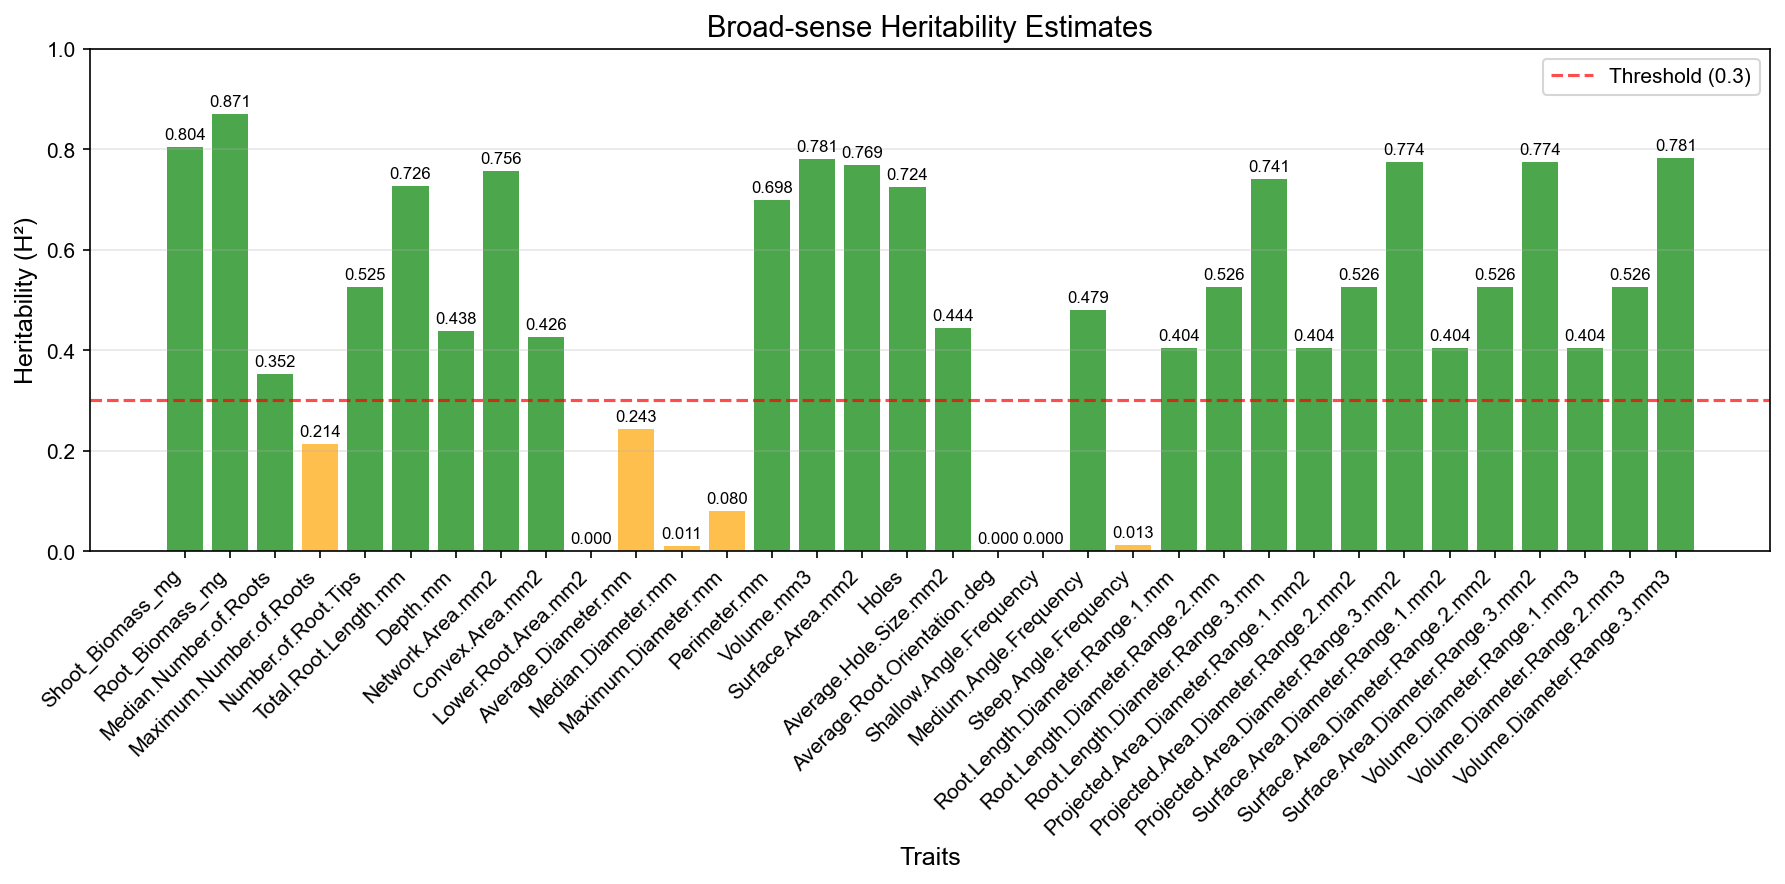

💾 Saved to: heritability_analysis_101937.png


In [19]:
# Create heritability plot
if heritability_results:
    h2_fig = create_heritability_plot(
        heritability_results, threshold=HERITABILITY_THRESHOLD
    )
    print("\n🧬 Heritability Plot:")
    display(h2_fig)
    # Save figure
    h2_path = save_figure_with_unique_name(h2_fig, FIGURES_DIR, "heritability_analysis")
    print(f"💾 Saved to: {h2_path.name}")
    plt.close(h2_fig)

### 5.3 Heritability-Based Trait Removal

Remove traits with low heritability (H² < threshold) to focus on traits with strong genetic contribution suitable for breeding programs.

🔍 Analyzing heritability threshold impact...

📊 Heritability Threshold Analysis:


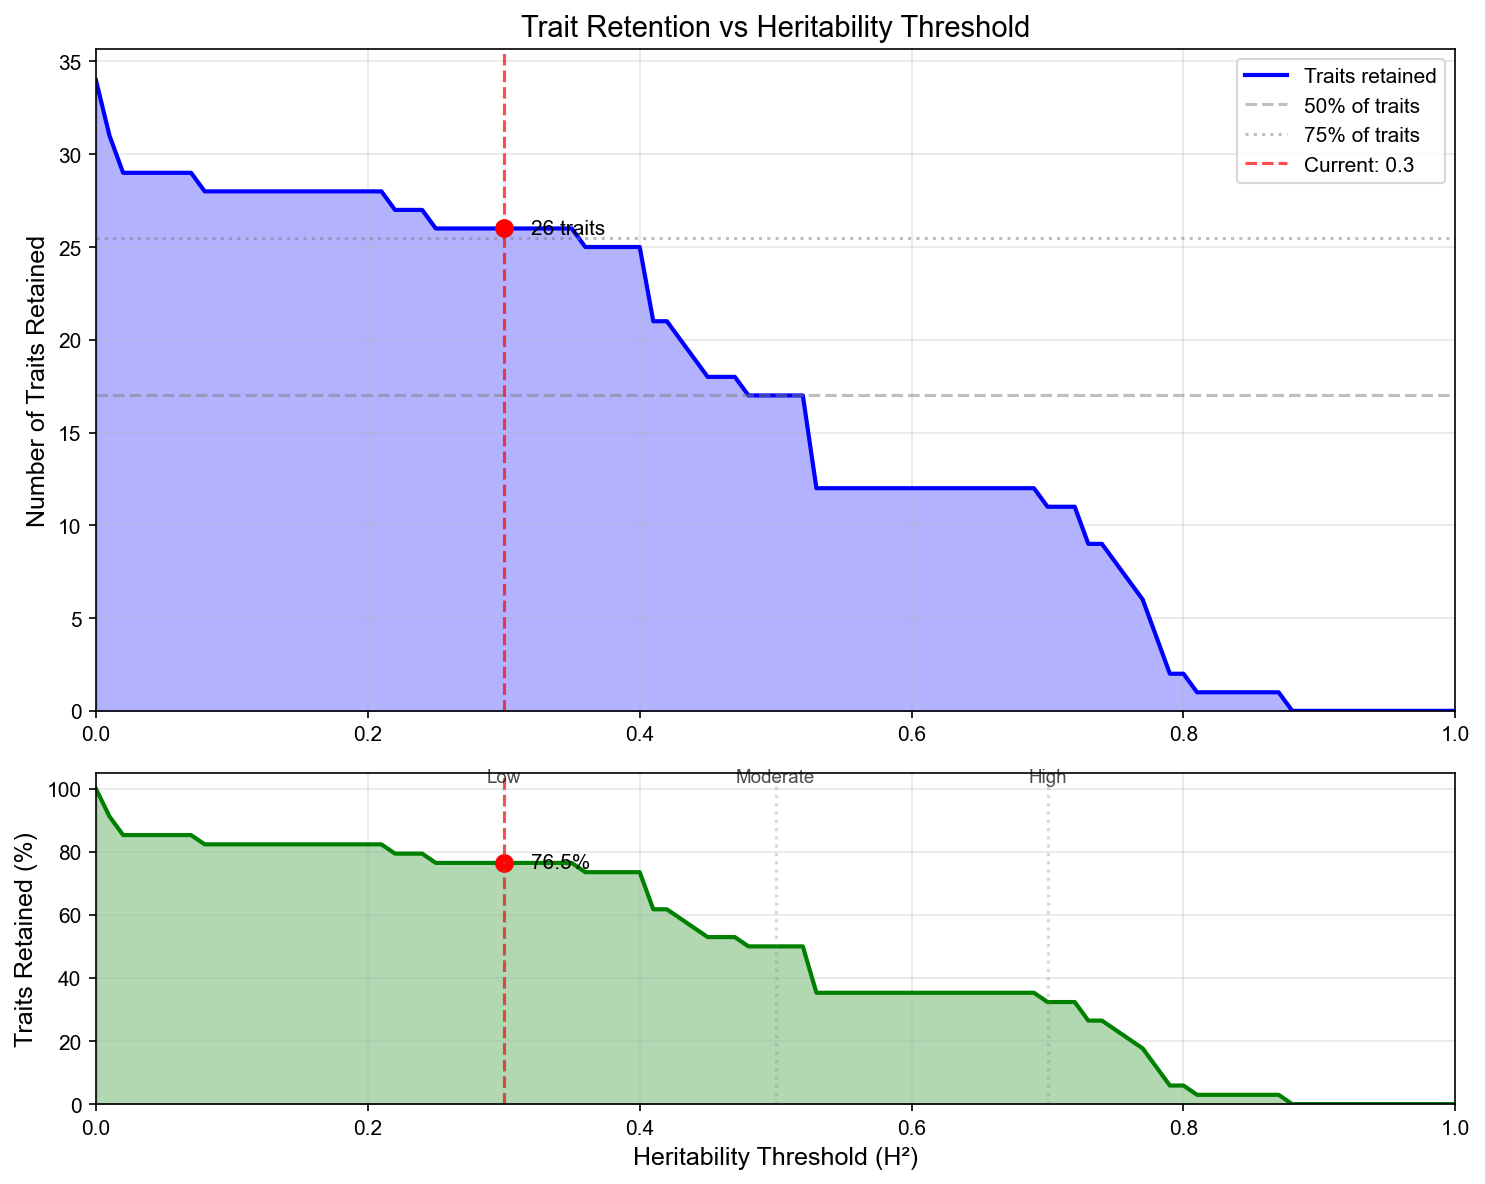

💾 Saved to: heritability_threshold_analysis_101938.png

📊 At current threshold (H² ≥ 0.3):
  - Traits retained: 26/34 (76.5%)
  - Traits removed: 8/34 (23.5%)

📈 Heritability distribution:
  - Min H²: 0.000
  - Max H²: 0.871
  - Mean H²: 0.475
  - Median H²: 0.502


In [20]:
# Analyze heritability thresholds to inform selection
if REMOVE_LOW_HERITABILITY_TRAITS and heritability_results:
    print("🔍 Analyzing heritability threshold impact...")
    
    # Analyze different threshold values
    threshold_analysis = analyze_heritability_thresholds(heritability_results)
    
    # Create threshold selection plot
    fig_threshold = create_heritability_threshold_plot(
        threshold_analysis,
        current_threshold=HERITABILITY_THRESHOLD,
        figsize=(10, 8)
    )
    
    print("\n📊 Heritability Threshold Analysis:")
    display(fig_threshold)
    
    # Save figure
    fig_path = save_figure_with_unique_name(fig_threshold, FIGURES_DIR, "heritability_threshold_analysis")
    print(f"💾 Saved to: {fig_path.name}")
    plt.close(fig_threshold)
    
    # Display summary statistics
    total_traits = threshold_analysis['total_traits']
    idx = np.argmin(np.abs(threshold_analysis['thresholds'] - HERITABILITY_THRESHOLD))
    traits_retained = int(threshold_analysis['traits_retained'][idx])
    traits_removed = total_traits - traits_retained
    
    print(f"\n📊 At current threshold (H² ≥ {HERITABILITY_THRESHOLD}):")
    print(f"  - Traits retained: {traits_retained}/{total_traits} ({traits_retained/total_traits*100:.1f}%)")
    print(f"  - Traits removed: {traits_removed}/{total_traits} ({traits_removed/total_traits*100:.1f}%)")
    
    # Show distribution of heritability values
    h2_values = threshold_analysis['h2_values']
    print(f"\n📈 Heritability distribution:")
    print(f"  - Min H²: {np.min(h2_values):.3f}")
    print(f"  - Max H²: {np.max(h2_values):.3f}")
    print(f"  - Mean H²: {np.mean(h2_values):.3f}")
    print(f"  - Median H²: {np.median(h2_values):.3f}")
else:
    print("ℹ️ Heritability-based trait removal is disabled (REMOVE_LOW_HERITABILITY_TRAITS = False)")

In [21]:
# Remove low heritability traits if enabled
if REMOVE_LOW_HERITABILITY_TRAITS and heritability_results:
    print(f"\n🧹 Removing traits with H² < {HERITABILITY_THRESHOLD}...")
    
    # Store original trait count
    original_trait_count = len(trait_cols)
    
    # Remove low heritability traits
    df_h2_filtered, removed_traits, h2_removal_summary = remove_low_heritability_traits(
        df_traits,
        heritability_results,
        heritability_threshold=HERITABILITY_THRESHOLD
    )
    
    # Update trait columns
    trait_cols_h2 = get_trait_columns(df_h2_filtered)
    
    # Save removed traits information
    if removed_traits:
        # Create DataFrame with removal details
        removed_traits_df = pd.DataFrame(h2_removal_summary['removal_details'])
        removed_traits_path = RUN_DIR / "04_heritability_removed_traits.csv"
        removed_traits_df.to_csv(removed_traits_path, index=False)
        print(f"\n✅ Saved {len(removed_traits)} removed traits to: {removed_traits_path.name}")
        
        # Save data after heritability filtering
        data_after_h2_path = RUN_DIR / "04_data_heritability_filtered.csv"
        df_h2_filtered.to_csv(data_after_h2_path, index=False)
        print(f"✅ Saved data after heritability filtering to: {data_after_h2_path.name}")
        
        # Save heritability cleanup log
        h2_cleanup_log_path = RUN_DIR / "04_heritability_cleanup_log.json"
        with open(h2_cleanup_log_path, "w") as f:
            json.dump(_convert_to_json_serializable(h2_removal_summary), f, indent=2)
        print(f"✅ Saved heritability cleanup log to: {h2_cleanup_log_path.name}")
        
        # Display removed traits
        print(f"\n🔍 Removed traits (H² < {HERITABILITY_THRESHOLD}):")
        display(removed_traits_df[['trait', 'heritability', 'reason']].head(10))
        if len(removed_traits) > 10:
            print(f"... and {len(removed_traits) - 10} more traits")
    else:
        print(f"✅ All traits have H² ≥ {HERITABILITY_THRESHOLD}, no traits removed")
        df_h2_filtered = df_traits.copy()
        trait_cols_h2 = trait_cols.copy()
    
    # Update main dataframe and trait columns
    df_traits = df_h2_filtered
    trait_cols = trait_cols_h2
    
    # Update cleanup log with heritability removal information
    if 'cleanup_log' not in locals():
        cleanup_log = {}
    
    cleanup_log['heritability_removal'] = {
        'enabled': True,
        'threshold': HERITABILITY_THRESHOLD,
        'original_traits': original_trait_count,
        'removed_traits': len(removed_traits),
        'retained_traits': len(trait_cols),
        'removed_trait_names': removed_traits,
        'summary': h2_removal_summary
    }
    
    print(f"\n📊 Heritability-based Trait Removal Summary:")
    print(f"  - Original traits: {original_trait_count}")
    print(f"  - Removed traits: {len(removed_traits)} ({len(removed_traits)/original_trait_count*100:.1f}%)")
    print(f"  - Retained traits: {len(trait_cols)} ({len(trait_cols)/original_trait_count*100:.1f}%)")
else:
    print("\nℹ️ Skipping heritability-based trait removal")
    if 'cleanup_log' not in locals():
        cleanup_log = {}
    cleanup_log['heritability_removal'] = {
        'enabled': False,
        'reason': 'REMOVE_LOW_HERITABILITY_TRAITS is False or no heritability results available'
    }


🧹 Removing traits with H² < 0.3...

✅ Saved 8 removed traits to: 04_heritability_removed_traits.csv
✅ Saved data after heritability filtering to: 04_data_heritability_filtered.csv
✅ Saved heritability cleanup log to: 04_heritability_cleanup_log.json

🔍 Removed traits (H² < 0.3):


trait  heritability                        reason
0       Maximum.Number.of.Roots  2.140269e-01  H² = 0.214 < threshold (0.3)
1           Lower.Root.Area.mm2  4.673110e-08  H² = 0.000 < threshold (0.3)
2           Average.Diameter.mm  2.428430e-01  H² = 0.243 < threshold (0.3)
3            Median.Diameter.mm  1.050447e-02  H² = 0.011 < threshold (0.3)
4           Maximum.Diameter.mm  7.978090e-02  H² = 0.080 < threshold (0.3)
5  Average.Root.Orientation.deg  9.117956e-09  H² = 0.000 < threshold (0.3)
6       Shallow.Angle.Frequency  3.745096e-09  H² = 0.000 < threshold (0.3)
7         Steep.Angle.Frequency  1.297588e-02  H² = 0.013 < threshold (0.3)


📊 Heritability-based Trait Removal Summary:
  - Original traits: 34
  - Removed traits: 8 (23.5%)
  - Retained traits: 26 (76.5%)


## 6. Save Results and Export

Remove outliers based on selected method and save all analysis outputs to timestamped run directory.

In [22]:
# Final data save - df_traits already has outliers removed and low heritability traits removed
df_cleaned = df_traits.copy()

# Create comprehensive cleanup log
full_cleanup_log = {
    "data_loading": cleanup_log if 'cleanup_log' in locals() else {},
    "heritability_removal": cleanup_log.get('heritability_removal', {}) if 'cleanup_log' in locals() else {},
    "outlier_detection": all_outlier_results if 'all_outlier_results' in locals() else {},
    "outlier_removal_method": OUTLIER_REMOVAL_METHOD if 'OUTLIER_REMOVAL_METHOD' in locals() else "none",
    "sample_tracking": {
        "original_samples": len(df_traits_original),
        "after_nan_removal": len(df_no_nan) if 'df_no_nan' in locals() else len(df_traits_original),
        "after_trait_cleanup": len(df_no_nan) if 'df_no_nan' in locals() else len(df_traits_original),
        "after_outlier_removal": len(df_cleaned_outliers) if 'df_cleaned_outliers' in locals() else len(df_traits),
        "after_heritability_filtering": len(df_cleaned),
        "total_removed": len(df_traits_original) - len(df_cleaned),
    },
    "trait_tracking": {
        "original_traits": len(get_trait_columns(df_traits_original)),
        "after_cleanup": len(get_trait_columns(df_no_nan)) if 'df_no_nan' in locals() else len(get_trait_columns(df_traits_original)),
        "after_heritability_removal": len(trait_cols),
    },
}

# Save cleaned data and log
cleaned_path, log_path = save_cleaned_data(
    df_cleaned, full_cleanup_log, RUN_DIR
)

# Also save with stage number for consistency
final_data_path = RUN_DIR / "04_FINAL_data_cleaned.csv"
df_cleaned.to_csv(final_data_path, index=False)

print(f"\n📊 Saving final data and analysis results...")
print(f"✓ Saved cleaned data to: {cleaned_path.as_posix()}")
print(f"✓ Saved final data to: {final_data_path.name}")
print(f"✓ Saved cleanup log to: {log_path.as_posix()}")

# Create pipeline summary
pipeline_summary = {
    "pipeline_version": "2.0",
    "run_timestamp": datetime.now().isoformat(),
    "configuration": {
        "max_nan_fraction": MAX_NAN_FRACTION,
        "outlier_removal_method": OUTLIER_REMOVAL_METHOD,
        "heritability_threshold": HERITABILITY_THRESHOLD if REMOVE_LOW_HERITABILITY_TRAITS else None,
        "remove_low_heritability_traits": REMOVE_LOW_HERITABILITY_TRAITS,
    },
    "pipeline_steps": {
        "1_nan_removal": {
            "samples_removed": len(df_nan_removed) if 'df_nan_removed' in locals() else 0,
            "output_file": "01_data_nan_samples_removed.csv"
        },
        "2_trait_cleanup": {
            "traits_removed": len(get_trait_columns(df_traits_original)) - len(get_trait_columns(df_no_nan)) if 'df_no_nan' in locals() else 0,
            "output_file": "02_data_traits_cleaned.csv"
        },
        "3_outlier_removal": {
            "outliers_removed": len(outliers_to_remove) if 'outliers_to_remove' in locals() and outliers_to_remove else 0,
            "method": OUTLIER_REMOVAL_METHOD,
            "output_file": "03_data_outliers_removed.csv"
        },
        "4_heritability_filtering": {
            "traits_removed": len(removed_traits) if 'removed_traits' in locals() else 0,
            "threshold": HERITABILITY_THRESHOLD if REMOVE_LOW_HERITABILITY_TRAITS else None,
            "output_file": "04_data_heritability_filtered.csv" if REMOVE_LOW_HERITABILITY_TRAITS else None
        }
    },
    "final_summary": {
        "total_samples_removed": len(df_traits_original) - len(df_cleaned),
        "total_traits_removed": len(get_trait_columns(df_traits_original)) - len(trait_cols),
        "final_samples": len(df_cleaned),
        "final_traits": len(trait_cols),
        "final_output": "04_FINAL_data_cleaned.csv"
    }
}

# Save pipeline summary
pipeline_summary_path = RUN_DIR / "pipeline_summary.json"
with open(pipeline_summary_path, "w") as f:
    json.dump(_convert_to_json_serializable(pipeline_summary), f, indent=2)
print(f"✓ Saved pipeline summary to: {pipeline_summary_path.name}")

# Save analysis results with proper conversion
if trait_stats:
    with open(ANALYSIS_DIR / "trait_statistics.json", "w") as f:
        json.dump(_convert_to_json_serializable(trait_stats), f, indent=2)
    print(f"✓ Saved trait statistics to: {(ANALYSIS_DIR / 'trait_statistics.json').name}")

if anova_results:
    anova_path = ANALYSIS_DIR / "anova_results.json"
    with open(anova_path, "w") as f:
        json.dump(_convert_to_json_serializable(anova_results), f, indent=2)
    print(f"✓ Saved ANOVA results to: {anova_path.name}")

if heritability_results:
    heritability_path = ANALYSIS_DIR / "heritability_results.json"
    with open(heritability_path, "w") as f:
        json.dump(_convert_to_json_serializable(heritability_results), f, indent=2)
    print(f"✓ Saved heritability results to: {heritability_path.name}")

# Display comprehensive summary
print(f"\n📊 Final Data Processing Summary:")
print(f"  - Original samples: {len(df_traits_original):,}")
print(f"  - After NaN removal: {len(df_no_nan):,} (-{len(df_traits_original) - len(df_no_nan)})" if 'df_no_nan' in locals() else "")
print(f"  - After outlier removal: {len(df_cleaned_outliers):,} (-{len(df_no_nan) - len(df_cleaned_outliers)})" if 'df_cleaned_outliers' in locals() else "")
print(f"  - Final samples: {len(df_cleaned):,} ({len(df_cleaned)/len(df_traits_original)*100:.1f}% of original)")

print(f"\n📊 Final Trait Processing Summary:")
print(f"  - Original traits: {len(get_trait_columns(df_traits_original))}")
if 'cleanup_log' in locals() and 'heritability_removal' in cleanup_log and cleanup_log['heritability_removal'].get('enabled'):
    h2_info = cleanup_log['heritability_removal']
    print(f"  - After heritability filtering (H² ≥ {HERITABILITY_THRESHOLD}): {h2_info['retained_traits']} (-{h2_info['removed_traits']})")
print(f"  - Final traits: {len(trait_cols)} ({len(trait_cols)/len(get_trait_columns(df_traits_original))*100:.1f}% of original)")

print(f"\n✅ Export complete! All results saved to: {RUN_DIR.as_posix()}")


📊 Saving final data and analysis results...
✓ Saved cleaned data to: c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851/cleaned_traits.csv
✓ Saved final data to: 04_FINAL_data_cleaned.csv
✓ Saved cleanup log to: c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851/cleanup_log.json
✓ Saved pipeline summary to: pipeline_summary.json
✓ Saved trait statistics to: trait_statistics.json
✓ Saved ANOVA results to: anova_results.json
✓ Saved heritability results to: heritability_results.json

📊 Final Data Processing Summary:
  - Original samples: 187
  - After NaN removal: 158 (-29)
  - After outlier removal: 154 (-4)
  - Final samples: 154 (82.4% of original)

📊 Final Trait Processing Summary:
  - Original traits: 34
  - After heritability filtering (H² ≥ 0.3): 26 (-8)
  - Final traits: 26 (76.5% of original)

✅ Export complete! All results saved to: c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851


In [23]:
# Save notebook snapshot
import shutil
from nbformat import read, write
import datetime

print("\n📓 Saving notebook snapshot...")

# Get the current notebook path
notebook_path = Path("trait_qc.ipynb")

try:
    # Read the notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = read(f, as_version=4)
    
    # Save executed version with timestamp in filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    executed_notebook_path = RUN_DIR / f"executed_notebook_{timestamp}.ipynb"
    with open(executed_notebook_path, 'w', encoding='utf-8') as f:
        write(nb, f)
    print(f"✓ Saved executed notebook to: {executed_notebook_path.name}")
    
    # Also save an initial/clean version (optional)
    initial_notebook_path = RUN_DIR / "initial_notebook.ipynb"
    shutil.copy2(notebook_path, initial_notebook_path)
    print(f"✓ Saved initial notebook copy to: {initial_notebook_path.name}")
    
except Exception as e:
    print(f"⚠️ Could not save notebook snapshot: {e}")
    print("   Note: This is normal if running in certain environments")

print(f"\n🎉 Analysis complete! All outputs saved to: {RUN_DIR}")
print(f"   📁 {RUN_DIR.as_posix()}")


📓 Saving notebook snapshot...
✓ Saved executed notebook to: executed_notebook_20250814_101940.ipynb
✓ Saved initial notebook copy to: initial_notebook.ipynb

🎉 Analysis complete! All outputs saved to: c:\repos\EDPIE_wheat_analysis\turface_analysis\runs\run_trait_qc_20250814_101851
   📁 c:/repos/EDPIE_wheat_analysis/turface_analysis/runs/run_trait_qc_20250814_101851
